In [1]:
import os
import os.path
from pathlib import Path
import rdflib
from rdflib import Graph
from typing import List, Dict, Any

import json

import numpy as np
import laspy

import open3d as o3d
import gmsh

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from shapely.geometry import Polygon, MultiPolygon

import geomapi.utils as ut
from geomapi.utils import geometryutils as gmu
from geomapi.nodes import PointCloudNode
import geomapi.tools as tl

from scipy.spatial import  distance, ConvexHull,  QhullError
from sklearn.neighbors import NearestNeighbors

from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

from concurrent.futures import ThreadPoolExecutor
import multiprocessing

import context_KUL
import utils_KUL as kul


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
current_directory=Path(os.getcwd()) 
print(current_directory)

name = 'school_v1'

path = Path(os.getcwd()).parents[0] / 'data'
pcd_input_path = path / f'{name}'
file_name = pcd_input_path / f'{name}.laz'
print(f'Pcd_input_path: {pcd_input_path}\nFile name {file_name}')


class_file = Path(os.getcwd()) / '_classes_expanded.json'
print('class_file:', class_file)

if not class_file.exists():
    print(f"class file not found: {class_file}")
else:
    print(f"class file exists: {class_file}")


c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\script
Pcd_input_path: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\data\school_v1
File name c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\data\school_v1\school_v1.laz
class_file: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\script\_classes_expanded.json
class file exists: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\script\_classes_expanded.json


In [3]:
output_folder = Path(os.getcwd()).parents[0] / 'outputs'
json_output_path = os.path.join(output_folder, f'{name}_elemnts.json') 
geometry_output_path = os.path.join(output_folder, f'{name}_elements.obj') # these are the bounding surfaces of the reference levels (optional)

file_graph_name = name
graph_path_str = str(output_folder / f'{file_graph_name}_graph.ttl')
print('Output folder', output_folder)


Output folder c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs


In [4]:
input_folder_ttl = path / 'graph_files'
print('Input folder ttl:', input_folder_ttl)

graph_path = input_folder_ttl / f'{name}_graph.ttl'
print('ttl:', graph_path)
graph_path_uri = graph_path.as_uri()
print('ttl URI:', graph_path_uri)

graph = Graph()
graph.parse(graph_path_uri, format="turtle")
print("Graph parsed successfully")

Input folder ttl: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\data\graph_files
ttl: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\data\graph_files\school_v1_graph.ttl
ttl URI: file:///c:/Users/oscar/OneDrive%20-%20Fondazione%20Bruno%20Kessler/KUL_GeometricModel/data/graph_files/school_v1_graph.ttl
Graph parsed successfully


In [5]:
output_folder = Path(os.getcwd()).parents[0] / 'outputs'
print(output_folder)

output_file_path = output_folder / f'{name}'
output_json_walls_file = output_file_path / f'{name}_walls.json'
output_json_floors_file = output_file_path / f'{name}_floors.json'
output_json_openings_file = output_file_path / f'{name}_openings.json'
output_json_columns_file = output_file_path / f'{name}_columns.json'
output_json_devices_file = output_file_path / f'{name}_devices.json'

print(f'JSON folder output {output_file_path}')

c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs
JSON folder output c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\school_v1


IMPORT GRAPH

In [6]:
with open(class_file, 'r') as file:
    json_data = json.load(file)

class_dict = {
    'classes': json_data.get('classes', []),
    'default': json_data.get('default', {}),
    'type': json_data.get('type', ''),
    'format': json_data.get('format', ''),
    'created_with': json_data.get('created_with', '')
}

print('Class dictionary:', class_dict)

Class dictionary: {'classes': [{'name': 'Unassigned', 'id': 255, 'temp_id': -1, 'color': '#9da2ab'}, {'name': 'Floors', 'id': 0, 'temp_id': 0, 'color': '#03c2fc'}, {'name': 'Ceilings', 'id': 1, 'temp_id': 1, 'color': '#e81416'}, {'name': 'Walls', 'id': 2, 'temp_id': 2, 'color': '#ffa500'}, {'name': 'Columns', 'id': 3, 'temp_id': 3, 'color': '#faeb36'}, {'name': 'Doors', 'id': 4, 'temp_id': 4, 'color': '#79c314'}, {'name': 'Windows', 'id': 5, 'temp_id': 5, 'color': '#4b369d'}, {'name': 'Lights', 'id': 6, 'temp_id': 6, 'color': '#7a93eb'}, {'name': 'Radiators', 'id': 7, 'temp_id': 7, 'color': '#d93b67'}, {'name': 'HVAC', 'id': 8, 'temp_id': 8, 'color': '#42b8a6'}], 'default': 255, 'type': 'semantic_segmentation', 'format': 'kitti', 'created_with': {'name': 'Saiga', 'version': '1.0.1'}}


In [7]:
laz, pcd, pcd_nodes, normals = kul.load_point_cloud(file_name)
print(f'Las file {laz}\nPCD {pcd}\n PCD_Nodes {pcd_nodes}\n Normals {normals}')


Las file <LasData(1.2, point fmt: <PointFormat(2, 2 bytes of extra dims)>, 3126542 points, 1 vlrs)>
PCD PointCloud with 3126542 points.
 PCD_Nodes <geomapi.nodes.pointcloudnode.PointCloudNode object at 0x000001E777354D00>
 Normals [[-0.04697317 -0.03550417  0.99826498]
 [-0.01021667  0.02556956  0.99962084]
 [ 0.03704321 -0.02480083  0.99900587]
 ...
 [-0.9998618  -0.01634594  0.0030307 ]
 [ 0.99996751 -0.0048734   0.00642091]
 [ 0.99892968  0.00289677  0.04616383]]


READ THE TTL FILE

In [8]:
node_groups, class_object_ids = kul.load_tt_graph(graph_path)
print(f'Node groups {node_groups} Classes_objects {class_object_ids}')

2 floors_nodes detected!
0 ceilings_nodes detected!
6 walls_nodes detected!
8 columns_nodes detected!
3 windows_nodes detected!
2 doors_nodes detected!
13 lights_nodes detected!
10 radiators_nodes detected!
0 hvac_nodes detected!
Node groups {'floors_nodes': [<geomapi.nodes.pointcloudnode.PointCloudNode object at 0x000001E77750CCA0>, <geomapi.nodes.pointcloudnode.PointCloudNode object at 0x000001E77750CD30>], 'ceilings_nodes': [], 'walls_nodes': [<geomapi.nodes.pointcloudnode.PointCloudNode object at 0x000001E77750E470>, <geomapi.nodes.pointcloudnode.PointCloudNode object at 0x000001E77750E4A0>, <geomapi.nodes.pointcloudnode.PointCloudNode object at 0x000001E77750E620>, <geomapi.nodes.pointcloudnode.PointCloudNode object at 0x000001E77750E740>, <geomapi.nodes.pointcloudnode.PointCloudNode object at 0x000001E77750E530>, <geomapi.nodes.pointcloudnode.PointCloudNode object at 0x000001E77750E8F0>], 'columns_nodes': [<geomapi.nodes.pointcloudnode.PointCloudNode object at 0x000001E777354E80>

PROCESS BUILDING ELEMENTS - CHECKING CORRESPONDENCE

In [9]:
building_elements = kul.extract_objects_building(laz, graph_path)


0 clutter detected
2 floors detected
0 ceilings detected
6 walls detected
8 columns detected
2 doors detected
3 windows detected
13 lights detected
10 radiators detected
0 hvac detected
0 levels detected


A - PROCESSING FLOORS AND CEILINGS

In [13]:
t_thickness_levels = 0.80
th_hull_area = 7.50

t_floor = 0.15
t_ceiling = 0.15

In [10]:
def planar_xy_hull(laz, node_ids, avg_z):
    points_2d = []
    
    for n in node_ids:
        # Since n is now a dictionary, access its class_id and object_id using dictionary keys
        idx = np.where((laz['classes'] == n['class_id']) & (laz['objects'] == n['object_id']))
        
        if idx[0].size == 0:
            continue  # Skip if no points are found for the given node_id
        
        # Extract x and y values for the selected points
        x_values = laz['x'][idx]
        y_values = laz['y'][idx]
        
        # Project to 2D by combining x and y values
        projected_points = np.column_stack((x_values, y_values))
        points_2d.extend(projected_points)
    
    # Convert list of 2D points to a numpy array
    points_2d = np.array(points_2d)
    
    # Ensure there are enough points to compute a convex hull
    if points_2d.shape[0] < 3:
        print(f"Not enough points to compute convex hull for avg_z {avg_z}")
        return None
    
    try:
        # Compute the convex hull using the 2D points
        hull = ConvexHull(points_2d)
        
        # Calculate the area of the convex hull (volume property is the area for 2D hull)
        hull_area = hull.volume
        
        if hull_area >= th_hull_area:  # Only return the hull if the area is >= 1 m²
            return hull
        else:
            print(f"Hull area {hull_area:.2f} is less than 1 m² for avg_z {avg_z}")
            return None
    except QhullError:
        # Handle errors in case the convex hull computation fails
        print(f"QhullError for avg_z {avg_z}")
        return None

# Helper function to convert PointCloudNode to a dictionary
def pointcloudnode_to_dict(node):
    return {
        'class_id': node.class_id,
        'object_id': node.object_id,
        'subject': node.subject
    }

def convexhull_to_dict(hull):
    """Convert a ConvexHull object to a dictionary."""
    return {
        'points': hull.points.tolist(),  # Convert points array to a list
        'vertices': hull.vertices.tolist(),  # Convert vertices array to a list
        'simplices': hull.simplices.tolist() if hasattr(hull, 'simplices') else None,  # Convert simplices to a list if available
        'volume': hull.volume  # For 2D hulls, this is the area
    }

def load_levels(laz, graph_path):
    # Parse the graph
    graph = Graph().parse(str(graph_path))
    nodes = tl.graph_to_nodes(graph)

    # Separate nodes by type
    ceilings_nodes = [n for n in nodes if 'ceilings' in n.subject.lower() and isinstance(n, PointCloudNode)]
    floors_nodes = [n for n in nodes if 'floors' in n.subject.lower() and isinstance(n, PointCloudNode)]
    level_nodes = [n for n in nodes if 'level' in n.subject.lower() and isinstance(n, PointCloudNode)]

    # Initialize lists for merged floor and ceiling data
    floors_z = []
    ceilings_z = []
    
    # Lists to store z_min and z_max values for bounding box computation
    floors_z_bbox = []  # (z_min, z_max) for each floor
    ceilings_z_bbox = []  # (z_min, z_max) for each ceiling

    # Calculate average z-values and z_min, z_max for floors
    for n in floors_nodes:
        idx = np.where((laz.classes == n.class_id) & (laz.objects == n.object_id))
        z_values = laz.z[idx]

        if len(z_values) > 0:
            avg_z = np.mean(z_values)
            z_min = np.min(z_values)
            z_max = np.max(z_values)

            if (z_max - z_min) > t_thickness_levels:
                continue
            
            merged = False
            for i, (existing_avg_z, floor_ids) in enumerate(floors_z):
                if abs(existing_avg_z - avg_z) <= t_floor:
                    new_avg_z = (existing_avg_z * len(floor_ids) + avg_z) / (len(floor_ids) + 1)
                    floors_z[i] = (new_avg_z, floor_ids + [pointcloudnode_to_dict(n)])
                    floors_z_bbox[i] = (min(floors_z_bbox[i][0], z_min), max(floors_z_bbox[i][1], z_max))
                    merged = True
                    break

            if not merged:
                floors_z.append((avg_z, [pointcloudnode_to_dict(n)]))
                floors_z_bbox.append((z_min, z_max))  # Store z_min and z_max for this floor

    # Calculate average z-values and z_min, z_max for ceilings
    for n in ceilings_nodes:
        idx = np.where((laz.classes == n.class_id) & (laz.objects == n.object_id))
        z_values = laz.z[idx]

        if len(z_values) > 0:
            avg_z = np.mean(z_values)
            z_min = np.min(z_values)
            z_max = np.max(z_values)

            if (z_max - z_min) > t_thickness_levels:
                continue

            merged = False
            for i, (existing_avg_z, ceiling_ids) in enumerate(ceilings_z):
                if abs(existing_avg_z - avg_z) <= t_ceiling:
                    new_avg_z = (existing_avg_z * len(ceiling_ids) + avg_z) / (len(ceiling_ids) + 1)
                    ceilings_z[i] = (new_avg_z, ceiling_ids + [pointcloudnode_to_dict(n)])
                    ceilings_z_bbox[i] = (min(ceilings_z_bbox[i][0], z_min), max(ceilings_z_bbox[i][1], z_max))
                    merged = True
                    break

            if not merged:
                ceilings_z.append((avg_z, [pointcloudnode_to_dict(n)]))
                ceilings_z_bbox.append((z_min, z_max))  # Store z_min and z_max for this ceiling

    print(f'Find {len(ceilings_nodes)} ceilings after normalization {len(ceilings_z)}')
    print(f'Find {len(floors_nodes)} floors after normalization {len(floors_z)}')
    print(f'Find {len(level_nodes)} levels')

    # Compute convex hulls and bounding boxes
    floor_hulls = []
    floor_hull_vertices = []
    floor_bboxes = []

    for avg_z, floor_ids in floors_z:
        # Get the convex hull
        hull = planar_xy_hull(laz, floor_ids, avg_z)
        
        if hull is None:  # hulls with area < 1m² are already discarded in planar_xy_hull
            continue
        
        floor_hulls.append(convexhull_to_dict(hull))  # Convert hull to dict
        
        # Get the vertices of the convex hull
        vertices = hull.points[hull.vertices]
        floor_hull_vertices.append(vertices.tolist())  # Convert vertices to list
        
        # Compute the 2D bounding box
        min_x, max_x = np.min(vertices[:, 0]), np.max(vertices[:, 0])
        min_y, max_y = np.min(vertices[:, 1]), np.max(vertices[:, 1])

        # Extend to 3D bounding box using z_min and z_max
        z_min, z_max = floors_z_bbox[floors_z.index((avg_z, floor_ids))]
        floor_bboxes.append([
            (min_x, min_y, z_min), (max_x, min_y, z_min),
            (max_x, max_y, z_min), (min_x, max_y, z_min),
            (min_x, min_y, z_max), (max_x, min_y, z_max),
            (max_x, max_y, z_max), (min_x, max_y, z_max)
        ])

    ceiling_hulls = []
    ceiling_hull_vertices = []
    ceiling_bboxes = []

    for avg_z, ceiling_ids in ceilings_z:
        # Get the convex hull
        hull = planar_xy_hull(laz, ceiling_ids, avg_z)
        
        if hull is None:  
            continue
        
        ceiling_hulls.append(convexhull_to_dict(hull))  # Convert hull to dict

        # Get the vertices of the convex hull
        vertices = hull.points[hull.vertices]
        ceiling_hull_vertices.append(vertices.tolist())  # Convert vertices to list
        
        # Compute the 2D bounding box
        min_x, max_x = np.min(vertices[:, 0]), np.max(vertices[:, 0])
        min_y, max_y = np.min(vertices[:, 1]), np.max(vertices[:, 1])
        
        # Extend to 3D bounding box using z_min and z_max
        z_min, z_max = ceilings_z_bbox[ceilings_z.index((avg_z, ceiling_ids))]
        ceiling_bboxes.append([
            (min_x, min_y, z_min), (max_x, min_y, z_min),
            (max_x, max_y, z_min), (min_x, max_y, z_min),
            (min_x, min_y, z_max), (max_x, min_y, z_max),
            (max_x, max_y, z_max), (min_x, max_y, z_max)
        ])

    # Compute average z-values for floors and ceilings
    floor_avg_z_values = [avg_z for avg_z, _ in floors_z]
    ceiling_avg_z_values = [avg_z for avg_z, _ in ceilings_z]

    floor_z_avg = np.mean(floor_avg_z_values) if floor_avg_z_values else None
    ceiling_z_avg = np.mean(ceiling_avg_z_values) if ceiling_avg_z_values else None


    thicknesses = []

    for floor_bbox, ceiling_bbox in zip(floors_z_bbox, ceilings_z_bbox):
        thickness = ceiling_bbox[0] - floor_bbox[1]  # z_min of ceiling - z_max of floor
        thicknesses.append(thickness)

    
    # Create and return the dictionary
    results = {
        'floors_nodes': floors_z,  # Now contains dictionaries instead of PointCloudNode objects
        'ceilings_nodes': ceilings_z,
        'floor_z_avg': floor_z_avg,
        'ceiling_z_avg': ceiling_z_avg,
        'level_nodes': [pointcloudnode_to_dict(n) for n in level_nodes],  # Convert level nodes to dictionaries
        'floors_z_bbox': floors_z_bbox,
        'ceilings_z_bbox': ceilings_z_bbox,
        'thicknesses': thicknesses,
        'floor_hulls': floor_hulls,  # Convex hulls for floors
        'floor_hull_vertices': floor_hull_vertices,  # Hull vertices for floors
        'ceiling_hulls': ceiling_hulls,  # Convex hulls for ceilings
        'ceiling_hull_vertices': ceiling_hull_vertices,  # Hull vertices for ceilings
        'floor_bboxes': floor_bboxes,  # 3D bounding boxes for floors
        'ceiling_bboxes': ceiling_bboxes  # 3D bounding boxes for ceilings
    }

    return results


In [15]:
# results = kul.load_levels(laz, graph_path)
levels_data = load_levels(laz, graph_path) 

Find 0 ceilings after normalization 0
Find 2 floors after normalization 2
Find 0 levels


In [11]:
def levels_bbox(floor_bboxes, ceiling_bboxes):
    # Filter out None values
    filtered_floor_bboxes = [bbox for bbox in floor_bboxes if bbox is not None]
    filtered_ceiling_bboxes = [bbox for bbox in ceiling_bboxes if bbox is not None]

    # Check if either array is empty and return empty array or continue
    if len(filtered_floor_bboxes) == 0 and len(filtered_ceiling_bboxes) == 0:
        print("Both floor and ceiling bounding boxes are empty.")
        return np.array([])  # Return an empty array if both are empty

    if len(filtered_floor_bboxes) == 0:
        print("Floor bounding boxes are empty, only ceiling bounding boxes will be used.")
        return np.array(filtered_ceiling_bboxes)  # Return only ceiling bboxes if floors are empty

    if len(filtered_ceiling_bboxes) == 0:
        print("Ceiling bounding boxes are empty, only floor bounding boxes will be used.")
        return np.array(filtered_floor_bboxes)  # Return only floor bboxes if ceilings are empty

    # Convert lists to numpy arrays
    floor_bboxes_array = np.array(filtered_floor_bboxes, dtype=object)
    ceiling_bboxes_array = np.array(filtered_ceiling_bboxes, dtype=object)

    # Concatenate floor and ceiling bounding boxes
    levels_bboxes = np.concatenate((floor_bboxes_array, ceiling_bboxes_array), axis=0)

    return levels_bboxes


In [17]:
floor_bboxes = levels_data['floor_bboxes'] 
ceiling_bboxes = levels_data['ceiling_bboxes']
print (f'floor_bboxes: {floor_bboxes} type {len(floor_bboxes)}')

level_bboxes = levels_bbox(floor_bboxes, ceiling_bboxes) 
print(f'BBox level found {len(level_bboxes)} bbox leves: {level_bboxes}')

floor_bboxes: [[(-53.813609405517575, 6.549845138549805, 3.052), (-31.08460940551758, 6.549845138549805, 3.052), (-31.08460940551758, 14.554845138549805, 3.052), (-53.813609405517575, 14.554845138549805, 3.052), (-53.813609405517575, 6.549845138549805, 3.45), (-31.08460940551758, 6.549845138549805, 3.45), (-31.08460940551758, 14.554845138549805, 3.45), (-53.813609405517575, 14.554845138549805, 3.45)], [(-53.81560940551758, 6.541845138549805, 3.4490000000000003), (-31.085609405517577, 6.541845138549805, 3.4490000000000003), (-31.085609405517577, 14.555845138549804, 3.4490000000000003), (-53.81560940551758, 14.555845138549804, 3.4490000000000003), (-53.81560940551758, 6.541845138549805, 3.882), (-31.085609405517577, 6.541845138549805, 3.882), (-31.085609405517577, 14.555845138549804, 3.882), (-53.81560940551758, 14.555845138549804, 3.882)]] type 2
Ceiling bounding boxes are empty, only floor bounding boxes will be used.
BBox level found 2 bbox leves: [[[-53.81360941   6.54984514   3.052 

In [18]:
plot = False
      
def plot_3d_bounding_boxes(results, bboxes, thicknesses=None):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    floors_nodes = results['floors_nodes']
    ceilings_nodes = results['ceilings_nodes']     

    for n in floors_nodes and ceilings_nodes:
        idx = np.where((laz.classes == n.class_id) & (laz.objects == n.object_id))
        x_values = laz.x[idx]
        y_values = laz.y[idx]
        z_values = laz.z[idx]
        coords = np.vstack((x_values, y_values, z_values)).T

        ax.scatter(coords [:, 0], coords[:, 1], coords[:,2], marker = 'o', s = 0.001, alpha = 0.10)

    for bbox in bboxes:
        if bbox.shape == (8, 3):  # Ensure bbox has 8 points each with (x, y, z)
            # Define the vertices of the bounding box
            vertices = bbox
            
            # Define the list of sides' polygons
            faces = [
                [vertices[0], vertices[1], vertices[5], vertices[4]],  # Bottom face
                [vertices[7], vertices[6], vertices[2], vertices[3]],  # Top face
                [vertices[0], vertices[1], vertices[6], vertices[7]],  # Front face
                [vertices[2], vertices[3], vertices[4], vertices[5]],  # Back face
                [vertices[0], vertices[3], vertices[7], vertices[4]],  # Left face
                [vertices[1], vertices[2], vertices[6], vertices[5]]   # Right face
            ]
            
            # Create a 3D polygon for each face and add it to the plot
            poly3d = Poly3DCollection(faces, alpha=0.25, linewidths=0.5, edgecolors='r')
            ax.add_collection3d(poly3d)

    # If thicknesses are provided, plot them as well
    if thicknesses is not None and len(thicknesses) == 3:
        ax.quiver(0, 0, 0, thicknesses[0], thicknesses[1], thicknesses[2], color='b', label='Thickness')
        
        # Include thickness in axis labels
        ax.set_xlabel(f'x axis (thickness = {thicknesses[0]})', fontsize=6)
        ax.set_ylabel(f'y axis (thickness = {thicknesses[1]})', fontsize=6)
        ax.set_zlabel(f'z axis (thickness = {thicknesses[2]})', fontsize=6)
    else:
        # Default labels if thicknesses are not provided
        ax.set_xlabel('x axis', fontsize=6)
        ax.set_ylabel('y axis', fontsize=6)
        ax.set_zlabel('z axis', fontsize=6)
    
    # Set tick labels' font size
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)
    ax.tick_params(axis='z', labelsize=6)

    # Optionally set axis limits based on the data
    x_limits = [np.min(bboxes[:, :, 0]) - 5, np.max(bboxes[:, :, 0]) + 5]
    y_limits = [np.min(bboxes[:, :, 1]) - 5, np.max(bboxes[:, :, 1]) + 5]
    z_limits = [np.min(bboxes[:, :, 2]), np.max(bboxes[:, :, 2])]

    ax.set_box_aspect([1, 1, 0.30])
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.set_zlim(z_limits)

    ax.grid(True)
    ax.grid(which = 'minor', linewidth = 0.25, color = 'gray')
    plt.title('3D BBOX FOR LEVELS NODES', fontsize=10)
    # plt.legend(loc='best')
    plt.show()

levels_bboxes = levels_bbox(floor_bboxes, ceiling_bboxes)
levels_bboxes_array = np.array(levels_bboxes, dtype=float)

if plot:
    plot_3d_bounding_boxes(levels_data, levels_bboxes_array)

print(f'Levels: {levels_bboxes_array} Number of levels: {len(levels_bboxes_array)}')

floor_bboxes = np.array((levels_data['floor_bboxes']))
ceiling_bboxes = np.array((levels_data['ceiling_bboxes']))
print('floors', floor_bboxes)
print('ceiling', ceiling_bboxes)


Ceiling bounding boxes are empty, only floor bounding boxes will be used.
Levels: [[[-53.81360941   6.54984514   3.052     ]
  [-31.08460941   6.54984514   3.052     ]
  [-31.08460941  14.55484514   3.052     ]
  [-53.81360941  14.55484514   3.052     ]
  [-53.81360941   6.54984514   3.45      ]
  [-31.08460941   6.54984514   3.45      ]
  [-31.08460941  14.55484514   3.45      ]
  [-53.81360941  14.55484514   3.45      ]]

 [[-53.81560941   6.54184514   3.449     ]
  [-31.08560941   6.54184514   3.449     ]
  [-31.08560941  14.55584514   3.449     ]
  [-53.81560941  14.55584514   3.449     ]
  [-53.81560941   6.54184514   3.882     ]
  [-31.08560941   6.54184514   3.882     ]
  [-31.08560941  14.55584514   3.882     ]
  [-53.81560941  14.55584514   3.882     ]]] Number of levels: 2
floors [[[-53.81360941   6.54984514   3.052     ]
  [-31.08460941   6.54984514   3.052     ]
  [-31.08460941  14.55484514   3.052     ]
  [-53.81360941  14.55484514   3.052     ]
  [-53.81360941   6.5498451

EXPORT LEVELS .json

    floor_bboxes
    ceiling_bboxes

In [19]:
def export_floors_ceilings_levels_to_json(results, output_json_file):
    try:
        # Open the file in write mode
        with open(output_json_file, 'w') as f:
            # Dump the results (floors, ceilings, levels data) to the JSON file with indentation for readability
            json.dump(results, f, indent=4)
        print(f"Floors, ceilings, and levels metadata successfully written to {output_json_file}")
    except Exception as e:
        print(f"Failed to write floors, ceilings, and levels metadata to JSON: {str(e)}")

# Assuming the results are generated from the load_levels function
results = load_levels(laz, graph_path)

# Set the output directory and file path
output_directory = output_file_path
output_json_file = output_json_floors_file

# Ensure the output directory exists
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Export the results to the JSON file
export_floors_ceilings_levels_to_json(results, output_json_file)


Find 0 ceilings after normalization 0
Find 2 floors after normalization 2
Find 0 levels
Floors, ceilings, and levels metadata successfully written to c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\school_v1\school_v1_floors.json


B - PROCESSING WALLS

In [20]:
def object_points(laz, graph_path):

    graph = Graph().parse(str(graph_path))
    nodes = tl.graph_to_nodes(graph)

    # Filter wall nodes
    walls_nodes = [wall for wall in nodes if 'walls' in wall.subject.lower() and isinstance(wall, PointCloudNode)]
    print(f'Number of wall nodes: {len(walls_nodes)}')

    wall_coordinates = []
    idx_list = []  # List to store indices

    for wall in walls_nodes:
        
        idx = np.where((laz.classes == wall.class_id) & (laz.objects == wall.object_id))

        if idx is not None and len(idx[0]) > 0:  # Ensure valid and non-empty indices
            coord_x = laz.x[idx]
            coord_y = laz.y[idx]
            coord_z = laz.z[idx]

            coordinates_ = np.vstack((coord_x, coord_y, coord_z)).T
            wall_coordinates.append(coordinates_)  # Store the coordinates

            # Store the index for the wall
            idx_list.append(idx)

        # Optional print to inspect
        # print(f'Wall {wall.object_id}: Index: {idx}, Number of points: {len(idx[0])}')

    return wall_coordinates, walls_nodes, idx_list  # Return indices as well

In [21]:
wall_coordinates, walls_nodes, idx_list = object_points(laz, graph_path)


Number of wall nodes: 6


In [22]:
def bounding_boxes(laz, wall_coordinates, walls_nodes):

    wall_coordinates = []
    wall_oriented_bboxes = []

    for wall in walls_nodes:
        
        idx = np.where((laz.classes == wall.class_id) & (laz.objects == wall.object_id))

        if idx is not None and len(idx[0]) > 0:  # Ensure valid and non-empty indices
            coord_x = laz.x[idx]
            coord_y = laz.y[idx]
            coord_z = laz.z[idx]

            coordinates_ = np.vstack((coord_x, coord_y, coord_z)).T
            wall_coordinates.append(coordinates_)

            # 1. Create an oriented bounding box for the wall
            point_cloud = o3d.geometry.PointCloud()  # Assuming open3d for point cloud manipulation
            point_cloud.points = o3d.utility.Vector3dVector(coordinates_)

            oriented_bounding_box = point_cloud.get_oriented_bounding_box()
            wall_oriented_bboxes.append(oriented_bounding_box)

            # 2. Compute the dominant plane using RANSAC
            plane_model, inliers = point_cloud.segment_plane(distance_threshold=0.03,
                                                                ransac_n=3,
                                                                num_iterations=1000)

            # 3. Compute the 2D normal of the wall (normal vector from plane equation)
            normal = plane_model[:3]  # Extracting the normal vector from the plane model
            normal[2] = 0  # Set the z-component to zero for 2D normal
            normal /= np.linalg.norm(normal)  # Normalize the vector

            # 4. Determine the direction of the wall
            box_center = np.asarray(oriented_bounding_box.get_center())
            face_center = point_cloud.select_by_index(inliers).get_center()
            face_center[2] = box_center[2]  # Align face center's height with the bounding box center

            sign = np.sign(np.dot(normal, face_center - box_center))  # Use dot product to determine direction

            # If sign is negative, flip the normal
            normal *= -1 if sign == -1 else 1

            # Output the result for debugging
            print(f'Wall {wall.object_id}:')
            print(f' - Oriented Bounding Box Center: {box_center}')
            print(f' - Plane Model: {plane_model}')
            print(f' - 2D Normal: {normal}')
            print(f' - Wall Direction: {"outwards" if sign == 1 else "inwards"}')

    return wall_coordinates, wall_oriented_bboxes, walls_nodes

wall_coordinates, wall_oriented_bboxes, walls_nodes = bounding_boxes(laz, wall_coordinates, walls_nodes)


Wall 0:
 - Oriented Bounding Box Center: [-53.67492641  10.21410435   4.85985361]
 - Plane Model: [-9.99907008e-01 -1.36372889e-02 -0.00000000e+00  5.36009163e+01]
 - 2D Normal: [-0.99990701 -0.01363729 -0.        ]
 - Wall Direction: inwards
Wall 1:
 - Oriented Bounding Box Center: [-42.44626613  14.17217665   4.85696622]
 - Plane Model: [ -0.0160099    0.99987183   0.         -14.94556824]
 - 2D Normal: [-0.0160099   0.99987183  0.        ]
 - Wall Direction: outwards
Wall 2:
 - Oriented Bounding Box Center: [-42.40845906   6.57613691   4.85760758]
 - Plane Model: [ 0.01412035 -0.9999003  -0.         -7.01902681]
 - 2D Normal: [ 0.01412035 -0.9999003  -0.        ]
 - Wall Direction: inwards
Wall 3:
 - Oriented Bounding Box Center: [-46.06352987  10.46287065   4.85449037]
 - Plane Model: [9.99892898e-01 1.46353486e-02 0.00000000e+00 4.58631794e+01]
 - 2D Normal: [0.9998929  0.01463535 0.        ]
 - Wall Direction: outwards
Wall 4:
 - Oriented Bounding Box Center: [-31.30813561  10.56

In [23]:
def rotate_points_2d(points, center, rotation_matrix):

        rotated_points = []

        for point in points: 

            shifted = point - center   
            rotated = np.dot(shifted, rotation_matrix)
            rotated_points.append(rotated + center)
            
        rotated_points = np.array(rotated_points)

        return rotated_points

def compute_bounding_box(points):
    
    pi2 = np.pi/2.

    # get the convex hull for the points
    hull_points = points[ConvexHull(points).vertices]

    # calculate edge angles
    edges = np.zeros((len(hull_points)-1, 2))
    edges = hull_points[1:] - hull_points[:-1]

    angles = np.zeros((len(edges)))
    angles = np.arctan2(edges[:, 1], edges[:, 0])
    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    # find rotation matrices
    # XXX both work
    rotations = np.vstack([np.cos(angles), np.cos(angles - pi2), np.cos(angles + pi2),np.cos (angles)]).T
    rotations = rotations.reshape((-1, 2, 2))

    # Covariance matrix
    cov = np.cov(points, rowvar=False)
    
    # apply rotations to the Hull points
    rot_points = np.dot(rotations, hull_points.T)

    # find the bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    # return the best box
    x1 = max_x[best_idx]
    x2 = min_x[best_idx]
    y1 = max_y[best_idx]
    y2 = min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((4, 2))
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)

    return rval, r

In [24]:
output_folder = str(path /'outputs') 
output_json_file = os.path.join(output_folder, 'walls_json.json')

In [25]:
plot = False

all_rotated_boxes = []  # List to store all rotated boxes

for i, wall_points in enumerate(wall_coordinates):
   
    points = wall_points[:, :2]  # Use only the x and y coordinates

    # Compute bounding box and center
    bounding_box, rotation_matrix = compute_bounding_box(points)
    center = np.mean(bounding_box, axis=0)

    # Rotate bounding box and points
    rotated_box = rotate_points_2d(bounding_box, center, rotation_matrix.T)
    rotated_points = rotate_points_2d(points, center, rotation_matrix.T)

    # Store the rotated box for this wall
    all_rotated_boxes.append(rotated_box)

    # Optional plotting
    if plot:
        plt.figure(figsize=(6, 6))
        plt.plot(points[:, 0], points[:, 1], 'o', markersize = 0.05, label='Wall points')
        plt.plot(rotated_points[:, 0], rotated_points[:, 1], 'o', markersize = 0.05, label='Rotated points')
        plt.plot(points[ConvexHull(points).vertices, 0], points[ConvexHull(points).vertices, 1], 'r--', lw = 1, label='Convex Hull')
        plt.plot(np.append(bounding_box[:, 0], bounding_box[0, 0]), np.append(bounding_box[:, 1], bounding_box[0, 1]), 'g-', lw = 1, label='Bounding box')
        plt.plot(np.append(rotated_box[:, 0], rotated_box[0, 0]), np.append(rotated_box[:, 1], rotated_box[0, 1]), 'g-', lw = 1, label='Rotated bounding box')
        
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(f'BOUNDING BOX COMPUTATION FOR WALL {i}', fontsize = 8)
        plt.legend(fontsize = 6)

        # Enable the major and minor ticks
        plt.minorticks_on()

        plt.tick_params(which='major', labelsize = 6) 
        plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')

        # Add minor gridlines
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

        # Customize the minor ticks (optional)
        plt.tick_params(which='minor', length=4, color='gray')
        plt.grid(True)
        plt.axis('equal')
        plt.show()

         # Vertices of rotated bounding box
        A, B, C, D = rotated_box[0], rotated_box[1], rotated_box[2], rotated_box[3]

In [26]:
plot = False

all_wall_bbox_vertices = []  # List to store bounding box vertices for all walls

for i, wall_points in enumerate(wall_coordinates):
    
    coordinates_2d = wall_points[:, :2]  # Extract X, Y coordinates from the wall points

    # ADD SOME LINES TO DELETE NOISE

    # Compute the bounding box and rotation matrix for the coordinates
    bounding_box, rotation_matrix = compute_bounding_box(coordinates_2d)
    center = np.mean(bounding_box, axis=0)

    # Rotate the bounding box and wall points around the center
    rotated_box = rotate_points_2d(bounding_box, center, rotation_matrix.T)
    rotated_points = rotate_points_2d(coordinates_2d, center, rotation_matrix.T)

    # Extract the four corners of the rotated bounding box
    A, C, B, D = rotated_box[0], rotated_box[1], rotated_box[2], rotated_box[3]

    # Ensure points are ordered in a clockwise or counterclockwise order
    new_points = np.array([A, C, B, D])

    # Reorder the points to form a proper bounding box (counterclockwise)
    bbox_vertices = new_points[[0, 3, 1, 2]]

    # Store the bounding box vertices for this wall
    all_wall_bbox_vertices.append(bbox_vertices)

    if plot:
        plt.figure(figsize=(6, 6))

        # Plot the rotated points
        plt.plot(rotated_points[:, 0], rotated_points[:, 1], 'o', markersize=0.25, label='Rotated Points')

        # Plot the original rotated bounding box
        plt.plot(np.append(rotated_box[:, 0], rotated_box[0, 0]), np.append(rotated_box[:, 1], rotated_box[0, 1]), 
                'g-', lw=2, label='Original Bounding Box')

        # Plot the adjusted bounding box (new_points)
        plt.plot(np.append(new_points[:, 0], new_points[0, 0]), np.append(new_points[:, 1], new_points[0, 1]), 
                'b-', lw=2, label='Adjusted Bounding Box')

        # Enable the major and minor ticks
        plt.minorticks_on()

        # Major grid lines
        plt.grid(which='major', linestyle='-', linewidth=0.5, color='black')

        # Minor grid lines
        plt.grid(which='minor', linestyle=':', linewidth=0.5, color='gray')

        # Tick parameters
        plt.tick_params(which='major', labelsize=6)
        plt.tick_params(which='minor', length=4, color='gray')

        # Labels and formatting
        plt.xlabel('x', fontsize=8)
        plt.ylabel('y', fontsize=8)
        plt.title(f'Bounding Box Adjustments for Wall {i}', fontsize=10)

        # Enable legend
        plt.legend(fontsize=8)

        # Equal axis scaling
        plt.axis('equal')

        # Show the plot
        plt.show()


In [29]:
def extract_min_max_z_from_bboxes(bboxes):
    
    z_values = []
    
    # Loop through each bounding box and extract z values
    for bbox in bboxes:
        bbox_z_values = [point[2] for point in bbox]  # Extract z-coordinates (3rd element of each point)
        z_values.extend(bbox_z_values)  # Add all z-values to the list
    
    if z_values:
        z_min = np.min(z_values)
        z_max = np.max(z_values)
    else:
        z_min = None
        z_max = None

    return z_min, z_max

def compute_3d_features(laz, wall_coordinates, rotated_boxes, rotation_matrix, graph_path, floor_bboxes, ceiling_bboxes):
    
    all_base_vertices = []  # Store base vertices for all walls
    all_top_vertices = []  # Store top vertices for all walls
    wall_properties = []  # Store other wall properties like length, thickness, etc.

    # Loop through each set of wall points
    for i, wall_points in enumerate(wall_coordinates):
    
        coordinates = wall_points[:, :3]
        print(f"Coordinates for Wall {i}:\n", coordinates)
    
        z_values = coordinates[:, 2]
        min_z = np.min(z_values)
        max_z = np.max(z_values)

        # Get the rotated box for the current wall (from rotated_boxes list)
        rotated_box = rotated_boxes[i]

        # Ensure rotated_box is 2D (x, y)
        if rotated_box.shape[1] != 2:
            raise ValueError(f"rotated_box for Wall {i} does not have the correct shape: {rotated_box.shape}")

        # Compute the center as the mean of the rotated box
        center_r = np.mean(rotated_box, axis=0)

        # Ensure the center is 2D and append z=0 for 3D
        center = np.array([center_r[0], center_r[1], 0])

        # Vertices of the bounding box
        A, B, C, D = rotated_box

        # Calculate edges of the bounding box
        a = B - A
        b = C - B
        c = D - C
        d = A - D

        # Stack the edges into an array
        edges = np.vstack([a, b, c, d])

        # Compute rotation angle
        angle = np.arctan2(rotation_matrix[1, 0], rotation_matrix[0, 0])
        rotation = np.degrees(angle)

        # Dimensions 
        # thickness = np.min(np.linalg.norm(edges, axis=1))  # Fix: Compute norm over axis 1 (for each edge)
        length = np.max(np.linalg.norm(edges, axis=1))

        # Extract z_min and z_max from both floor_bboxes and ceiling_bboxes
        floor_z_min, floor_z_max = extract_min_max_z_from_bboxes(floor_bboxes)  # Floor bounding boxes
        ceiling_z_min, ceiling_z_max = extract_min_max_z_from_bboxes(ceiling_bboxes)  # Ceiling bounding boxes

        # Determine z_base from floors and z_top from ceilings
        if floor_z_min is not None:
            z_base = floor_z_min
        else:
            z_base = min_z  # Fallback to min_z if no floor data

        if ceiling_z_max is not None:
            z_top = ceiling_z_max
        else:
            z_top = max_z  # Fallback to max_z if no ceiling data

        # Calculate the height of the wall
        height = z_top - z_base

        # Redefine the bounding box in 3D
        A_3d_base = np.append(A, z_base)
        B_3d_base = np.append(B, z_base)
        C_3d_base = np.append(C, z_base)
        D_3d_base = np.append(D, z_base)

        A_3d_top = np.append(A, z_top)
        B_3d_top = np.append(B, z_top)
        C_3d_top = np.append(C, z_top)
        D_3d_top = np.append(D, z_top)

        # Store the 3D bounding box vertices (base and top) for this wall
        base_vertices = np.array([A_3d_base, B_3d_base, C_3d_base, D_3d_base])
        top_vertices = np.array([A_3d_top, B_3d_top, C_3d_top, D_3d_top])

        all_base_vertices.append(base_vertices)  # Save base vertices for this wall
        all_top_vertices.append(top_vertices)    # Save top vertices for this wall

        # List of vertices
        vertices = [A_3d_base, B_3d_base, C_3d_base, D_3d_base, A_3d_top, B_3d_top, C_3d_top, D_3d_top]

        # Compute all pairwise distances between vertices
        distances = []
        for i in range(len(vertices)):
            for j in range(i + 1, len(vertices)):
                distance = np.linalg.norm(np.array(vertices[i] - np.array(vertices[j])))
                distances.append(distance)

        # Find the minimum distance (which will be taken as the thickness)
        thickness = min(distances)

        # Save other wall properties
        wall_properties.append({
            'length': length,
            'thickness': thickness,
            'height': height,
            'center': center,
            'rotation': rotation
        })

        # Print out details of the wall for debugging
        print(f'Wall {i}: Thickness: {thickness}\n Length: {length}\n z_base: {z_base}, z_top: {z_top}\n Height: {height}\n Location: {center}\n Rotation: {rotation}')

    return all_base_vertices, all_top_vertices, wall_properties

In [30]:
plot = False

wall_coordinates, wall_oriented_bboxes, walls_nodes = bounding_boxes(laz, wall_coordinates, walls_nodes)

base_vertices = []
top_vertices = []
lengths = [] 
thicknesses = [] 
heights = [] 
centers = [] 
rotations = []

for i, wall_points in enumerate(wall_coordinates):
    
    coordinates = wall_points[:, :3]  # Extract 3D coordinates
    print(f"Wall {i} coordinates:\n", coordinates)

    graph = Graph().parse(str(graph_path))
    nodes = tl.graph_to_nodes(graph)
    print(f'Graph {graph} nodes {nodes}')
    
    # Check if the ceiling and floor nodes are present (re-enable this as needed)
    ceilings_nodes = [n for n in nodes if 'ceilings' in n.subject.lower() and isinstance(n, PointCloudNode)]
    floors_nodes = [n for n in nodes if 'floors' in n.subject.lower() and isinstance(n, PointCloudNode)]
  
    # Compute 3D features for the current wall
    all_base_vertices, all_top_vertices, wall_properties = compute_3d_features(
        laz, wall_coordinates, all_rotated_boxes, rotation_matrix, graph_path, floor_bboxes, ceiling_bboxes)

    # Plot the results
    if plot:
        plt.figure(figsize=(8, 6))

        # Plot the wall points
        plt.plot(coordinates[:, 0], coordinates[:, 1], 'o', markersize=0.5, label='Wall Points')

        # Plot the original bounding box (before adjustment)
        base = all_base_vertices[i]  # Get the base vertices for this wall
        plt.plot(np.append(base[:, 0], base[0, 0]), np.append(base[:, 1], base[0, 1]), 
                 'g-', lw=2, label='Original Bounding Box')

        # Plot the adjusted bounding box (if available)
        top = all_top_vertices[i]  # Get the top vertices for this wall
        plt.plot(np.append(top[:, 0], top[0, 0]), np.append(top[:, 1], top[0, 1]), 
                 'b-', lw=2, label='Adjusted Bounding Box')

        # Enable the major and minor ticks
        plt.minorticks_on()

        # Major grid lines
        plt.grid(which='major', linestyle='-', linewidth=0.5, color='black')

        # Minor grid lines
        plt.grid(which='minor', linestyle=':', linewidth=0.5, color='gray')

        # Tick parameters
        plt.tick_params(which='major', labelsize=6)
        plt.tick_params(which='minor', length=4, color='gray')

        # Labels and formatting
        plt.xlabel('x', fontsize=8)
        plt.ylabel('y', fontsize=8)
     
        plt.title(f'Bounding Box Adjustments for Wall {i}')
        plt.legend(fontsize=8)
        plt.grid(True)
        plt.axis('equal')
        plt.show()

    # Store the extracted properties from each wall
    base_vertices.append(all_base_vertices[i])
    top_vertices.append(all_top_vertices[i])
    lengths.append(wall_properties[i]['length'])
    thicknesses.append(wall_properties[i]['thickness'])
    heights.append(wall_properties[i]['height'])
    centers.append(wall_properties[i]['center'])
    rotations.append(wall_properties[i]['rotation'])

Wall 0:
 - Oriented Bounding Box Center: [-53.67492641  10.21410435   4.85985361]
 - Plane Model: [-9.99903124e-01 -1.39191145e-02 -0.00000000e+00  5.35988018e+01]
 - 2D Normal: [-0.99990312 -0.01391911 -0.        ]
 - Wall Direction: inwards
Wall 1:
 - Oriented Bounding Box Center: [-42.44626613  14.17217665   4.85696622]
 - Plane Model: [ -0.01591523   0.99987334   0.         -14.94621394]
 - 2D Normal: [-0.01591523  0.99987334  0.        ]
 - Wall Direction: outwards
Wall 2:
 - Oriented Bounding Box Center: [-42.40845906   6.57613691   4.85760758]
 - Plane Model: [ 0.0142303  -0.99989874 -0.         -7.02110365]
 - 2D Normal: [ 0.0142303  -0.99989874 -0.        ]
 - Wall Direction: inwards
Wall 3:
 - Oriented Bounding Box Center: [-46.06352987  10.46287065   4.85449037]
 - Plane Model: [9.99892918e-01 1.46339674e-02 0.00000000e+00 4.58607582e+01]
 - 2D Normal: [0.99989292 0.01463397 0.        ]
 - Wall Direction: outwards
Wall 4:
 - Oriented Bounding Box Center: [-31.30813561  10.56

In [31]:
plot = False

def compute_features_bbox(base_vertices, top_vertices, wall_idx):

    vertices = np.vstack([base_vertices, top_vertices])

    # Edges connecting the base, top, and vertical sides
    edges = [
        [base_vertices[0], base_vertices[1]], 
        [base_vertices[1], base_vertices[2]],  
        [base_vertices[2], base_vertices[3]],  
        [base_vertices[3], base_vertices[0]],  
        [top_vertices[0], top_vertices[1]],    
        [top_vertices[1], top_vertices[2]],    
        [top_vertices[2], top_vertices[3]],    
        [top_vertices[3], top_vertices[0]],    
        [base_vertices[0], top_vertices[0]],  
        [base_vertices[1], top_vertices[1]],   
        [base_vertices[2], top_vertices[2]],   
        [base_vertices[3], top_vertices[3]]    
    ]

    # Faces of the 3D bounding box
    faces = [
        [base_vertices[0], base_vertices[1], base_vertices[2], base_vertices[3]],  
        [top_vertices[0], top_vertices[1], top_vertices[2], top_vertices[3]], 
        [base_vertices[0], top_vertices[0], top_vertices[1], base_vertices[1]],  
        [base_vertices[1], top_vertices[1], top_vertices[2], base_vertices[2]], 
        [base_vertices[2], top_vertices[2], top_vertices[3], base_vertices[3]],  
        [base_vertices[3], top_vertices[3], top_vertices[0], base_vertices[0]]   
    ]

    # Base and Top edges
    base_edges = [
        [base_vertices[0], base_vertices[1]], 
        [base_vertices[1], base_vertices[2]],  
        [base_vertices[2], base_vertices[3]],  
        [base_vertices[3], base_vertices[0]]  
    ]
    
    top_edges = [
        [top_vertices[0], top_vertices[1]],    
        [top_vertices[1], top_vertices[2]],    
        [top_vertices[2], top_vertices[3]],    
        [top_vertices[3], top_vertices[0]]    
    ]
    
    # Calculate center points of the base, top, and middle edges
    base_edge_centers = [(edge[0] + edge[1]) / 2 for edge in base_edges]
    top_edge_centers = [(edge[0] + edge[1]) / 2 for edge in top_edges]

    middle_edge_centers = [
        (base_vertices[0] + top_vertices[0]) / 2,
        (base_vertices[1] + top_vertices[1]) / 2,
        (base_vertices[2] + top_vertices[2]) / 2,
        (base_vertices[3] + top_vertices[3]) / 2
    ]

    # Calculate internal lines that connect the base centers to the top centers
    internal_lines = [[base_edge_centers[i], top_edge_centers[i]] for i in range(4)]

    # Determine which are the shorter edges based on length
    edge_lengths = [np.linalg.norm(base_vertices[0] - base_vertices[1]), np.linalg.norm(base_vertices[1] - base_vertices[2])]
    
    if edge_lengths[0] < edge_lengths[1]:
        # Edge 0-1 and 2-3 are shorter
        shorter_edges_indices = [0, 2]
    else:
        # Edge 1-2 and 3-0 are shorter
        shorter_edges_indices = [1, 3]

    # Connect the corresponding base and top center vertices of the shorter edges
    shorter_internal_lines = [
        [base_edge_centers[shorter_edges_indices[0]], top_edge_centers[shorter_edges_indices[0]]],
        [base_edge_centers[shorter_edges_indices[1]], top_edge_centers[shorter_edges_indices[1]]]
    ]

    # Connect the top center vertices (shorter edges)
    top_center_lines = [
        [top_edge_centers[shorter_edges_indices[0]], top_edge_centers[shorter_edges_indices[1]]]
    ]
    
    # Connect the base center vertices (shorter edges)
    base_center_lines = [
        [base_edge_centers[shorter_edges_indices[0]], base_edge_centers[shorter_edges_indices[1]]]
    ]

    # Prepare results for output
    result = {
        'vertices': vertices,
        'edges': edges,
        'faces': faces,
        'base_centers': base_edge_centers,
        'top_centers': top_edge_centers,
        'middle_centers': middle_edge_centers,
        'shorter_internal_lines': shorter_internal_lines,
        'top_center_lines': top_center_lines,
        'base_center_lines': base_center_lines
    }

    # Call the plot function
    plot_bounding_box(vertices, edges, faces, base_edge_centers, top_edge_centers, shorter_internal_lines, top_center_lines, base_center_lines, wall_idx)

    return result

# Function to plot the bounding box, including internal lines and surfaces
def plot_bounding_box(vertices, edges, faces, base_edge_centers, top_edge_centers, shorter_internal_lines, top_center_lines, base_center_lines, wall_idx):
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111, projection='3d')

        # Add faces of the bounding box
        ax.add_collection3d(Poly3DCollection(faces, facecolors='grey', linewidths=0.50, edgecolors='r', alpha=0.10))

        # Plot the edges of the bounding box
        for edge in edges:
            ax.plot([edge[0][0], edge[1][0]], [edge[0][1], edge[1][1]], [edge[0][2], edge[1][2]], color='r', linewidth=0.50)

            # Plot the top center lines (connecting the shorter edges on the top)
        for line in top_center_lines:
            ax.plot(
                [line[0][0], line[1][0]], [line[0][1], line[1][1]], [line[0][2], line[1][2]], color='black', linestyle='--', linewidth = 0.75)

        # Plot the base center lines (connecting the shorter edges on the base)
        for line in base_center_lines:
            ax.plot(
                [line[0][0], line[1][0]], [line[0][1], line[1][1]], [line[0][2], line[1][2]], color='black', linestyle='--', linewidth = 0.75)

        # Plot the middle lines between middle edge centers
        for i in range(0, len(base_edge_centers)):  # Iterate for center edges
            ax.plot(
                [base_edge_centers[i][0], top_edge_centers[i][0]],  # X coordinates
                [base_edge_centers[i][1], top_edge_centers[i][1]],  # Y coordinates
                [base_edge_centers[i][2], top_edge_centers[i][2]],  # Z coordinates
                color='black', linestyle='--', linewidth = 0.75
            )

        # Plot the vertices as points
        ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], color='blue', label='Vertices', s = 10)

        # Plot the centers of base and top edges
        ax.scatter(np.array(base_edge_centers)[:, 0], np.array(base_edge_centers)[:, 1], np.array(base_edge_centers)[:, 2], 
                color='black', label='Base Edge Centers', s = 10)
        ax.scatter(np.array(top_edge_centers)[:, 0], np.array(top_edge_centers)[:, 1], np.array(top_edge_centers)[:, 2], 
                color='black', label='Top Edge Centers', s = 10)

        # Set labels and title
        ax.set_xlabel('x - direction', fontsize = 6)
        ax.set_ylabel('y - direction', fontsize = 6)
        ax.set_zlabel('z - direction', fontsize = 6)
        plt.title(f'BOUNDING BOX COMPUTATION FOR WALL {wall_idx}', fontsize = 8)

        # Customize grid and ticks
        plt.minorticks_on()
        plt.tick_params(which='major', labelsize=6)
        plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

        # Compute the axis limits based on vertices to center the plot
        x_limits = [np.min(vertices[:, 0]) - 0.50, np.max(vertices[:, 0]) + 0.50]
        y_limits = [np.min(vertices[:, 1]) - 0.50, np.max(vertices[:, 1]) + 0.50]
        z_limits = [np.min(vertices[:, 2]) - 0.50, np.max(vertices[:, 2]) + 0.50]

        # Set the axis limits to center the bounding box in the plot
        ax.set_xlim(x_limits)
        ax.set_ylim(y_limits)
        ax.set_zlim(z_limits)
        
        # Show the plot
        plt.legend(fontsize=6)
        ax.set_box_aspect([1, 1, 1.25])  # Equal aspect ratio
        plt.show()

walls_results = []  # To store the results for each wall

if plot:

    for i in range(len(base_vertices)):
        result = compute_features_bbox(base_vertices[i], top_vertices[i], i)  # Compute features for each wall
        walls_results.append(result)  # Store the result for later use


EXPORT WALLS .obj

In [32]:
def export_obj(vertices, faces, file_name):
    with open(file_name, 'w') as file:
        # Write vertices
        for v in vertices:
            file.write(f"v {v[0]} {v[1]} {v[2]}\n")
        
        # Write faces
        for f in faces:
            # OBJ format starts indexing at 1
            file.write(f"f {f[0]+1} {f[1]+1} {f[2]+1} {f[3]+1}\n")
    
    print(f"Exported OBJ file: {file_name}")

def export_bounding_box_as_obj(results, file_name = f"{name}_bbox.obj"):
    for i, wall in enumerate(results):
        vertices = wall['vertices']
        
        # Define faces (using indices in the vertices array)
        faces = [
            [0, 1, 2, 3],  # Bottom face
            [4, 5, 6, 7],  # Top face
            [0, 4, 5, 1],  # Side faces
            [1, 5, 6, 2],
            [2, 6, 7, 3],
            [3, 7, 4, 0]
        ]
        
        # Export to OBJ
        export_obj(vertices, faces, f"{file_name}_wall_{i}.obj")
export_bounding_box_as_obj(walls_results)

def export_internal_surface_as_obj(results, file_name = f"{name}_surface.obj"):
    for i, wall in enumerate(results):
        # Combine base and top center lines into a single array
        base_centers = wall['base_center_lines'][0]
        top_centers = wall['top_center_lines'][0]
        
        vertices = np.vstack([base_centers, top_centers])
        
        # Define a face connecting the base and top centers (shorter edges)
        faces = [
            [0, 1, 3, 2],  # Internal surface from shorter edges
        ]
        
        # Export to OBJ
        export_obj(vertices, faces, f"{file_name}_wall_{i}.obj")
export_internal_surface_as_obj(walls_results)


WINDOWS AND DOORS

In [33]:
def windows_doors_points(laz, graph_path):

    graph = Graph().parse(str(graph_path))
    nodes = tl.graph_to_nodes(graph)

    # Filter door and window nodes
    doors_nodes = [node for node in nodes if 'doors' in node.subject.lower() and isinstance(node, PointCloudNode)]
    windows_nodes = [node for node in nodes if 'windows' in node.subject.lower() and isinstance(node, PointCloudNode)]

    print(f'Number of door nodes: {len(doors_nodes)}')
    print(f'Number of window nodes: {len(windows_nodes)}')

    doors_coordinates = []
    windows_coordinates = []
    idx_list_doors = []  # List to store indices for doors
    idx_list_windows = []  # List to store indices for windows

    # Process door nodes
    for door in doors_nodes:
        # Find indices in laz data where classes and objects match the current door node
        idx_doors = np.where((laz.classes == door.class_id) & (laz.objects == door.object_id))

        # Check if the idx is valid and non-empty
        if idx_doors is not None and len(idx_doors[0]) > 0:
            coord_x = laz.x[idx_doors]
            coord_y = laz.y[idx_doors]
            coord_z = laz.z[idx_doors]

            # Stack coordinates into a (n, 3) array (where n is the number of points)
            coordinates_ = np.vstack((coord_x, coord_y, coord_z)).T
            doors_coordinates.append(coordinates_)  # Store the door coordinates

            # Store the index for the current door node
            idx_list_doors.append(idx_doors)

    # Process window nodes
    for window in windows_nodes:
        # Find indices in laz data where classes and objects match the current window node
        idx_windows = np.where((laz.classes == window.class_id) & (laz.objects == window.object_id))

        # Check if the idx is valid and non-empty
        if idx_windows is not None and len(idx_windows[0]) > 0:
            coord_x = laz.x[idx_windows]
            coord_y = laz.y[idx_windows]
            coord_z = laz.z[idx_windows]

            # Stack coordinates into a (n, 3) array (where n is the number of points)
            coordinates_ = np.vstack((coord_x, coord_y, coord_z)).T
            windows_coordinates.append(coordinates_)  # Store the window coordinates

            # Store the index for the current window node
            idx_list_windows.append(idx_windows)

    # Return the coordinates and index lists for doors and windows
    return doors_coordinates, windows_coordinates, idx_list_doors, idx_list_windows


In [75]:
doors_coordinates, windows_coordinates, doors_nodes, windows_nodes =  windows_doors_points(laz, graph_path)

Number of door nodes: 2
Number of window nodes: 3


In [76]:
def bounding_boxes(opening_coordinates, opening_nodes, name='name'):

    opening_coordinates = []
    opening_oriented_bboxes = []

    # Conditionally select the appropriate nodes based on the 'name' parameter
    if name.lower() == 'doors':
        opening_nodes = [node for node in nodes if 'doors' in node.subject.lower() and isinstance(node, PointCloudNode)]
    elif name.lower() == 'windows':
        opening_nodes = [node for node in nodes if 'windows' in node.subject.lower() and isinstance(node, PointCloudNode)]
    else:
        raise ValueError(f"Invalid name: {name}. Expected 'doors' or 'windows'.")

    # Loop through each selected opening node (doors or windows)
    for opening in opening_nodes:
        
        # Extract the indices from the laz data based on class and object id
        opening_idx = np.where((laz.classes == opening.class_id) & (laz.objects == opening.object_id))

        if opening_idx is not None and len(opening_idx[0]) > 0:  # Ensure valid and non-empty indices
            coord_opening_x = laz.x[opening_idx]
            coord_opening_y = laz.y[opening_idx]
            coord_opening_z = laz.z[opening_idx]

            opening_coordinates_ = np.vstack((coord_opening_x, coord_opening_y, coord_opening_z)).T
            opening_coordinates.append(opening_coordinates_)

            # Create a point cloud for the current opening
            point_opening_cloud = o3d.geometry.PointCloud()  # Assuming open3d for point cloud manipulation
            point_opening_cloud.points = o3d.utility.Vector3dVector(opening_coordinates_)

            # 1. Create an oriented bounding box for the opening
            oriented_bounding_box = point_opening_cloud.get_oriented_bounding_box()
            opening_oriented_bboxes.append(oriented_bounding_box)

            # 2. Compute the dominant plane using RANSAC
            plane_opening_model, opening_inliers = point_opening_cloud.segment_plane(
                distance_threshold=0.03, ransac_n=3, num_iterations=1000
            )

            # 3. Compute the 2D normal of the opening (normal vector from the plane equation)
            opening_normal = plane_opening_model[:3]  # Extracting the normal vector from the plane model
            opening_normal[2] = 0  # Set the z-component to zero for 2D normal (XY plane)
            opening_normal /= np.linalg.norm(opening_normal)  # Normalize the vector

            # 4. Determine the direction of the opening (based on its center and normal)
            box_opening_center = np.asarray(oriented_bounding_box.get_center())
            face_opening_center = point_opening_cloud.select_by_index(opening_inliers).get_center()
            face_opening_center[2] = box_opening_center[2]  # Align face center's height with the bounding box center

            sign = np.sign(np.dot(opening_normal, face_opening_center - box_opening_center))  # Use dot product to determine direction

            # If sign is negative, flip the normal
            opening_normal *= -1 if sign == -1 else 1

            # Output the result for debugging
            print(f'{name.capitalize()} {opening.object_id}:')
            print(f' - Oriented Bounding Box Center: {box_opening_center}')
            print(f' - Plane Model: {plane_opening_model}')
            print(f' - 2D Normal: {opening_normal}')
            print(f' - Direction: {"outwards" if sign == 1 else "inwards"}')

    return opening_coordinates, opening_oriented_bboxes, opening_nodes

In [77]:
doors_coordinates, doors_oriented_bboxes, doors_nodes = bounding_boxes(doors_coordinates, doors_nodes, name = 'doors')
windows_coordinates, windows_oriented_bboxes, windows_nodes = bounding_boxes(windows_coordinates, windows_nodes, name = 'windows')


Doors 0:
 - Oriented Bounding Box Center: [-52.43190197  14.07378057   4.82416955]
 - Plane Model: [ -0.02996437   0.99955097   0.         -15.68630165]
 - 2D Normal: [-0.02996437  0.99955097  0.        ]
 - Direction: outwards
Doors 1:
 - Oriented Bounding Box Center: [-45.27699242  14.20016942   4.83042385]
 - Plane Model: [-8.64302205e-03  9.99962648e-01  0.00000000e+00 -1.46498988e+01]
 - 2D Normal: [-0.00864302  0.99996265  0.        ]
 - Direction: outwards
Windows 0:
 - Oriented Bounding Box Center: [-35.12153871   6.68397967   5.27635094]
 - Plane Model: [-0.02076675  0.99978435  0.         -7.51398318]
 - 2D Normal: [-0.02076675  0.99978435  0.        ]
 - Direction: outwards
Windows 1:
 - Oriented Bounding Box Center: [-41.71301701   6.5754637    5.24039653]
 - Plane Model: [-0.01462962  0.99989298  0.         -7.27807114]
 - 2D Normal: [-0.01462962  0.99989298  0.        ]
 - Direction: outwards
Windows 2:
 - Oriented Bounding Box Center: [-49.70700152   6.47760456   5.26828

In [78]:
def compute_3d_opertures_features(opening_coordinates, rotated_opening_boxes):
    
    all_opening_base_vertices = []
    all_opening_top_vertices = []
    opening_properties = []

    # Loop through each set of opening points
    for i, opening_points in enumerate(opening_coordinates):
        opening_coordinates = opening_points[:, :3]
        # print(f"Coordinates for Opening {i}:\n", opening_coordinates)

        z_opening_values = opening_coordinates[:, 2]
        min_opening_z = np.min(z_opening_values)
        max_opening_z = np.max(z_opening_values)

        # Get the rotated box for the current opening (from rotated_boxes list)
        rotated_opening_box = rotated_opening_boxes[i]
        rotated_opening_box_points = np.asarray(rotated_opening_box.get_box_points())

        # Ensure rotated_box_points is 3D (x, y, z)
        if rotated_opening_box_points.shape[1] != 3:
            raise ValueError(f"rotated_box for Opening {i} does not have the correct shape: {rotated_opening_box_points.shape}")

        # Compute the center as the mean of the rotated box
        center_opening_r = np.mean(rotated_opening_box_points[:, :2], axis=0)
        opening_center = np.array([center_opening_r[0], center_opening_r[1], 0])

        # Vertices of the bounding box (assuming a 4-vertex box in 2D)
        A, B, C, D = rotated_opening_box_points[:4, :2]

        # Calculate edges of the bounding box
        a = B - A  # Vector along one edge
        d = D - A  # Vector along the other edge

        # Normalize vectors for orientation (rotation matrix)
        x_axis = a / np.linalg.norm(a)  # Unit vector along the x-axis of the box
        y_axis = d / np.linalg.norm(d)  # Unit vector along the y-axis of the box

        # Create 2x2 rotation matrix using normalized vectors
        rotation_opening_matrix = np.array([x_axis, y_axis])

        # Calculate dimensions 
        opening_thickness = np.min(np.linalg.norm([a, d], axis=1))
        opening_length = np.max(np.linalg.norm([a, d], axis=1))
        opening_height = max_opening_z - min_opening_z

        # Redefine the bounding box in 3D
        A_opening_3d_base = np.append(A, min_opening_z)
        B_opening_3d_base = np.append(B, min_opening_z)
        C_opening_3d_base = np.append(C, min_opening_z)
        D_opening_3d_base = np.append(D, min_opening_z)

        A_opening_3d_top = np.append(A, max_opening_z)
        B_opening_3d_top = np.append(B, max_opening_z)
        C_opening_3d_top = np.append(C, max_opening_z)
        D_opening_3d_top = np.append(D, max_opening_z)

        # Store the 3D bounding box vertices (base and top)
        base_opening_vertices = np.array([A_opening_3d_base, B_opening_3d_base, C_opening_3d_base, D_opening_3d_base])
        top_opening_vertices = np.array([A_opening_3d_top, B_opening_3d_top, C_opening_3d_top, D_opening_3d_top])

        all_opening_base_vertices.append(base_opening_vertices)
        all_opening_top_vertices.append(top_opening_vertices)
        bounding_box = np.vstack((all_opening_base_vertices, all_opening_top_vertices))

        # Save other opening properties
        opening_properties.append({
            'Opening id': {i},
            'bbox_vertices': bounding_box,
            'length': opening_length,
            'thickness': opening_thickness,
            'height': opening_height,
            'center': opening_center,
            'rotation': rotation_opening_matrix,  # 2D rotation matrix
        })

        # Print out details of the opening for debugging
        print(f'Opening {i}:\n bbox_vertices: {bounding_box} Thickness: {opening_thickness}\n Length: {opening_length}\n z_base: {min_opening_z}, z_top: {max_opening_z}\n Height: {opening_height}\n Location: {opening_center}\n Rotation Matrix:\n{rotation_opening_matrix}')
            
    return all_opening_base_vertices, all_opening_top_vertices, opening_properties


OPENNGS PROPERTIES

            'length': opening_length,
            'thickness': opening_thickness,
            'height': opening_height,
            'center': opening_center,
            'rotation': rotation_opening_matrix,  # 2D rotation matrix


INTERSECTION BETWEEN WALLS AND OPENINGS

In [36]:
def compute_features_walls_bbox(base_vertices, top_vertices, wall_idx):

    vertices = np.vstack([base_vertices, top_vertices])

    # Edges connecting the base, top, and vertical sides
    edges = [
        [base_vertices[0], base_vertices[1]], 
        [base_vertices[1], base_vertices[2]],  
        [base_vertices[2], base_vertices[3]],  
        [base_vertices[3], base_vertices[0]],  
        [top_vertices[0], top_vertices[1]],    
        [top_vertices[1], top_vertices[2]],    
        [top_vertices[2], top_vertices[3]],    
        [top_vertices[3], top_vertices[0]],    
        [base_vertices[0], top_vertices[0]],  
        [base_vertices[1], top_vertices[1]],   
        [base_vertices[2], top_vertices[2]],   
        [base_vertices[3], top_vertices[3]]    
    ]

    # Faces of the 3D bounding box
    faces = [
        [base_vertices[0], base_vertices[1], base_vertices[2], base_vertices[3]],  
        [top_vertices[0], top_vertices[1], top_vertices[2], top_vertices[3]], 
        [base_vertices[0], top_vertices[0], top_vertices[1], base_vertices[1]],  
        [base_vertices[1], top_vertices[1], top_vertices[2], base_vertices[2]], 
        [base_vertices[2], top_vertices[2], top_vertices[3], base_vertices[3]],  
        [base_vertices[3], top_vertices[3], top_vertices[0], base_vertices[0]]   
    ]

    # Base and Top edges
    base_edges = [
        [base_vertices[0], base_vertices[1]], 
        [base_vertices[1], base_vertices[2]],  
        [base_vertices[2], base_vertices[3]],  
        [base_vertices[3], base_vertices[0]]  
    ]
    
    top_edges = [
        [top_vertices[0], top_vertices[1]],    
        [top_vertices[1], top_vertices[2]],    
        [top_vertices[2], top_vertices[3]],    
        [top_vertices[3], top_vertices[0]]    
    ]
    
    # Calculate center points of the base, top, and middle edges
    base_edge_centers = [(edge[0] + edge[1]) / 2 for edge in base_edges]
    top_edge_centers = [(edge[0] + edge[1]) / 2 for edge in top_edges]

    middle_edge_centers = [
        (base_vertices[0] + top_vertices[0]) / 2,
        (base_vertices[1] + top_vertices[1]) / 2,
        (base_vertices[2] + top_vertices[2]) / 2,
        (base_vertices[3] + top_vertices[3]) / 2
    ]

    # Calculate internal lines that connect the base centers to the top centers
    internal_lines = [[base_edge_centers[i], top_edge_centers[i]] for i in range(4)]

    # Determine which are the shorter edges based on length
    edge_lengths = [np.linalg.norm(base_vertices[0] - base_vertices[1]), np.linalg.norm(base_vertices[1] - base_vertices[2])]
    
    if edge_lengths[0] < edge_lengths[1]:
        # Edge 0-1 and 2-3 are shorter
        shorter_edges_indices = [0, 2]
    else:
        # Edge 1-2 and 3-0 are shorter
        shorter_edges_indices = [1, 3]

    # Connect the corresponding base and top center vertices of the shorter edges
    shorter_internal_lines = [
        [base_edge_centers[shorter_edges_indices[0]], top_edge_centers[shorter_edges_indices[0]]],
        [base_edge_centers[shorter_edges_indices[1]], top_edge_centers[shorter_edges_indices[1]]]
    ]

    # Connect the top center vertices (shorter edges)
    top_center_lines = [
        [top_edge_centers[shorter_edges_indices[0]], top_edge_centers[shorter_edges_indices[1]]]
    ]
    
    # Connect the base center vertices (shorter edges)
    base_center_lines = [
        [base_edge_centers[shorter_edges_indices[0]], base_edge_centers[shorter_edges_indices[1]]]
    ]

    # Prepare results for output
    result = {
        'vertices': vertices,
        'edges': edges,
        'faces': faces,
        'base_edge_centers': base_edge_centers,
        'top_edge_centers': top_edge_centers,
        'middle_edge_centers': middle_edge_centers,
        'shorter_internal_lines': shorter_internal_lines,
        'top_center_lines': top_center_lines,
        'base_center_lines': base_center_lines
    }
    
    return result


In [37]:
walls_results = []  # To store the results for each wall

for i in range(len(base_vertices)):

    result = compute_features_walls_bbox(base_vertices[i], top_vertices[i], i)  # Compute features for each wall
    walls_results.append(result)  # Store the result for later use

for i in range(len(base_vertices)):

    # Access the precomputed results from walls_results
    result = walls_results[i]
    
    print(f"Wall {i + 1} Results:")

    print("\nVertices:")
    for vertex in result['vertices']:
        print(vertex)

    print("\nEdges:")
    for edge in result['edges']:
        print(edge)

    print("\nFaces:")
    for face in result['faces']:
        print(face)

    print("\nBase Centers:")
    for base_center in result['base_edge_centers']:
        print(base_center)

    print("\nTop Centers:")
    for top_center in result['top_edge_centers']:
        print(top_center)

    print("\nMiddle Edge Centers:")
    for middle_edge_center in result['middle_edge_centers']:
        print(middle_edge_center)

    print("\nShorter Internal Lines:")
    for line in result['shorter_internal_lines']:
        print(line)

    print("\nTop Center Lines:")
    for line in result['top_center_lines']:
        print(line)

    print("\nBase Center Lines:")
    for line in result['base_center_lines']:
        print(line)


Wall 1 Results:

Vertices:
[-53.43970227   6.68747445   3.052     ]
[-53.9395799    6.68747445   3.052     ]
[-53.9395799   13.71310761   3.052     ]
[-53.43970227  13.71310761   3.052     ]
[-53.43970227   6.68747445   6.657     ]
[-53.9395799    6.68747445   6.657     ]
[-53.9395799   13.71310761   6.657     ]
[-53.43970227  13.71310761   6.657     ]

Edges:
[array([-53.43970227,   6.68747445,   3.052     ]), array([-53.9395799 ,   6.68747445,   3.052     ])]
[array([-53.9395799 ,   6.68747445,   3.052     ]), array([-53.9395799 ,  13.71310761,   3.052     ])]
[array([-53.9395799 ,  13.71310761,   3.052     ]), array([-53.43970227,  13.71310761,   3.052     ])]
[array([-53.43970227,  13.71310761,   3.052     ]), array([-53.43970227,   6.68747445,   3.052     ])]
[array([-53.43970227,   6.68747445,   6.657     ]), array([-53.9395799 ,   6.68747445,   6.657     ])]
[array([-53.9395799 ,   6.68747445,   6.657     ]), array([-53.9395799 ,  13.71310761,   6.657     ])]
[array([-53.9395799

C1 - CONNECTIVITY

In [222]:
from topologicpy.Topology import Topology
from topologicpy.Face import Face
from topologicpy.Wire import Wire
from topologicpy.Vertex import Vertex
from topologicpy.Shell import Shell  
from topologicpy.Topology import Topology


distance = 0.50
tolerance = 1e-6  

def create_topologic_face(surface_vertices):

    # Create Topologic vertices
    vertices = [Vertex.ByCoordinates(*v) for v in surface_vertices]
    
    # Create a closed wire (boundary) for the face
    wire = Wire.ByVertices(vertices + [vertices[0]])  # Close the wire
    
    # Create a face using the wire
    face = Face.ByWire(wire)
    
    if face is None:
        print(f"Error: Failed to create face for vertices: {surface_vertices}")
    
    return face

def check_face_edges(face):

    edges = Topology.Edges(face)
    edge_info = []

    for edge in edges:
        
        vertices = Topology.Vertices(edge)
        v1, v2 = vertices[0].Coordinates(), vertices[1].Coordinates()
        edge_info.append((v1, v2))
        print(f"Edge from {v1} to {v2}")

    return edge_info

def check_face_connectivity(face1, face2):
 
    edges1 = set(check_face_edges(face1))
    edges2 = set(check_face_edges(face2))
    
    # Check for shared edges between the two faces
    common_edges = edges1.intersection(edges2)
    if common_edges:
        print(f"Faces are connected with shared edges: {common_edges}")
    else:
        print("Faces are not connected. No shared edges found.")

    return common_edges

def check_face_orientation(face):
  
    vertices = Topology.Vertices(face)
    if len(vertices) >= 3:
        v1, v2, v3 = vertices[0].Coordinates(), vertices[1].Coordinates(), vertices[2].Coordinates()
        normal = np.cross(np.array(v2) - np.array(v1), np.array(v3) - np.array(v1))
        print(f"Normal of the face: {normal}")
        return normal
    else:
        print("Face has fewer than 3 vertices.")
        
    return None



In [223]:
walls_surfaces = []  # Store the face objects

for i, wall in enumerate(walls_results):

    try:
        # Extract the relevant points for the surface from the wall dictionary
        top_center_lines = np.array(wall['top_center_lines'])
        base_center_lines = np.array(wall['base_center_lines'])

        t1v = top_center_lines[0][0]  # First vertex from top_center_lines
        t2v = top_center_lines[0][1]  # Second vertex from top_center_lines
        b1v = base_center_lines[0][0]  # First vertex from base_center_lines
        b2v = base_center_lines[0][1]  # Second vertex from base_center_lines

        # Create the 3D surface with the four vertices (t1v, t2v, b1v, b2v)
        surface_vertices = [t1v, t2v, b2v, b1v]

        # Convert the surface vertices to a Topologic face
        face = create_topologic_face(surface_vertices)
        
        if face:
            walls_surfaces.append(face)

            print(f"Face {i+1} created successfully.")
            # Check edges and orientation
            print(f"Checking edges for face {i+1}:")
            check_face_edges(face)
            print(f"Checking orientation for face {i+1}:")
            check_face_orientation(face)
        else:
            print(f"Error: Could not create face for wall {i+1}")

    except KeyError as e:
        print(f"Error: Missing key in wall data: {e}")
    except Exception as e:
        print(f"Error processing wall {i+1}: {e}")


Face 1 created successfully.
Checking edges for face 1:
Edge from (-53.68964108674759, 6.687474449347631, 6.657) to (-53.68964108674759, 13.713107609287842, 6.657)
Edge from (-53.68964108674759, 13.713107609287842, 6.657) to (-53.68964108674759, 13.713107609287842, 3.052)
Edge from (-53.68964108674759, 13.713107609287842, 3.052) to (-53.68964108674759, 6.687474449347631, 3.052)
Edge from (-53.68964108674759, 6.687474449347631, 3.052) to (-53.68964108674759, 6.687474449347631, 6.657)
Checking orientation for face 1:
Normal of the face: [-25.32740754   0.           0.        ]
Face 2 created successfully.
Checking edges for face 2:
Edge from (-53.82544207993614, 14.223614000180076, 6.657) to (-31.079621159695222, 14.223614000180078, 6.657)
Edge from (-31.079621159695222, 14.223614000180078, 6.657) to (-31.079621159695222, 14.223614000180078, 3.052)
Edge from (-31.079621159695222, 14.223614000180078, 3.052) to (-53.82544207993614, 14.223614000180076, 3.052)
Edge from (-53.82544207993614, 

C2 - CONNECT SURFACES

In [88]:
threshold = 0.50
neighborhood_threshold = 0.50
neighborhood_threshold = 1
tolerance = 1
threshold_merge_radious = 2

In [85]:
def neighborhood_walls(p1, p2, threshold = threshold):

    return np.linalg.norm(np.array(p1) - np.array(p2)) <= threshold

def point_to_line_distance(point, line_start, line_end):

    line_vector = line_end - line_start
    point_vector = point - line_start

    # Project point onto the line (find projection scalar 't')
    line_len_sq = np.dot(line_vector, line_vector)  # Squared length of the line segment
    if line_len_sq == 0.0:
        return np.linalg.norm(point_vector)  # line_start and line_end are the same point
    
    t = np.dot(point_vector, line_vector) / line_len_sq
    t = max(0, min(1, t))  # Clamp t to the range [0, 1]
    
    # Find the closest point on the line segment
    closest_point = line_start + t * line_vector
    return np.linalg.norm(point - closest_point)  # Distance from point to the closest point on the line

def point_near_line(point, line_start, line_end, threshold = threshold):

    return point_to_line_distance(np.array(point), np.array(line_start), np.array(line_end)) <= threshold


In [87]:
adjacent_walls = []

for i, wall in enumerate(walls_results):

    try:
        # Extract the relevant points for the surface from the wall dictionary
        top_center_lines = np.array(wall['top_center_lines'])
        base_center_lines = np.array(wall['base_center_lines'])

        t1v = top_center_lines[0][0]  # First vertex from top_center_lines
        t2v = top_center_lines[0][1]  # Second vertex from top_center_lines
        b1v = base_center_lines[0][0]  # First vertex from base_center_lines
        b2v = base_center_lines[0][1]  # Second vertex from base_center_lines

        # Check for adjacent walls based on both top and base center lines of neighboring walls
        for j, other_wall in enumerate(walls_results):

            if i == j:
                continue  # Skip the same wall

            other_top_center_lines = np.array(other_wall['top_center_lines'])
            other_base_center_lines = np.array(other_wall['base_center_lines'])

            other_t1v = other_top_center_lines[0][0]  # First vertex from other wall's top_center_lines
            other_t2v = other_top_center_lines[0][1]  # Second vertex from other wall's top_center_lines
            other_b1v = other_base_center_lines[0][0]  # First vertex from other wall's base_center_lines
            other_b2v = other_base_center_lines[0][1]  # Second vertex from other wall's base_center_lines

            # Original condition: Check vertex-to-vertex adjacency
            vertex_to_vertex_adjacency = (
                neighborhood_walls(t1v, other_t1v, neighborhood_threshold) or
                neighborhood_walls(t1v, other_t2v, neighborhood_threshold) or
                neighborhood_walls(t2v, other_t1v, neighborhood_threshold) or
                neighborhood_walls(t2v, other_t2v, neighborhood_threshold) or
                neighborhood_walls(b1v, other_b1v, neighborhood_threshold) or
                neighborhood_walls(b1v, other_b2v, neighborhood_threshold) or
                neighborhood_walls(b2v, other_b1v, neighborhood_threshold) or
                neighborhood_walls(b2v, other_b2v, neighborhood_threshold)
            )

            # New condition: Check if any vertex from one wall is close to a line on the other wall
            vertex_to_line_adjacency = (
                point_near_line(t1v, other_t1v, other_t2v, neighborhood_threshold) or
                point_near_line(t2v, other_t1v, other_t2v, neighborhood_threshold) or
                point_near_line(b1v, other_t1v, other_t2v, neighborhood_threshold) or
                point_near_line(b2v, other_t1v, other_t2v, neighborhood_threshold) or
                point_near_line(t1v, other_b1v, other_b2v, neighborhood_threshold) or
                point_near_line(t2v, other_b1v, other_b2v, neighborhood_threshold) or
                point_near_line(b1v, other_b1v, other_b2v, neighborhood_threshold) or
                point_near_line(b2v, other_b1v, other_b2v, neighborhood_threshold)
            )

            # Also check if vertices from the other wall are close to lines on the current wall
            cross_vertex_to_line_adjacency = (
                point_near_line(other_t1v, t1v, t2v, neighborhood_threshold) or
                point_near_line(other_t2v, t1v, t2v, neighborhood_threshold) or
                point_near_line(other_b1v, t1v, t2v, neighborhood_threshold) or
                point_near_line(other_b2v, t1v, t2v, neighborhood_threshold) or
                point_near_line(other_t1v, b1v, b2v, neighborhood_threshold) or
                point_near_line(other_t2v, b1v, b2v, neighborhood_threshold) or
                point_near_line(other_b1v, b1v, b2v, neighborhood_threshold) or
                point_near_line(other_b2v, b1v, b2v, neighborhood_threshold)
            )

            # Check if any condition is true
            if vertex_to_vertex_adjacency or vertex_to_line_adjacency or cross_vertex_to_line_adjacency:
                # If they are adjacent, store them
                adjacent_walls.append((wall, other_wall))
                print(f"Wall {i} is adjacent to Wall {j} based on vertex-to-vertex or vertex-to-line proximity")

    except KeyError as e:
        print(f"Missing data in wall {i}: {e}")

Wall 0 is adjacent to Wall 2 based on vertex-to-vertex or vertex-to-line proximity
Wall 1 is adjacent to Wall 3 based on vertex-to-vertex or vertex-to-line proximity
Wall 1 is adjacent to Wall 4 based on vertex-to-vertex or vertex-to-line proximity
Wall 1 is adjacent to Wall 5 based on vertex-to-vertex or vertex-to-line proximity
Wall 2 is adjacent to Wall 0 based on vertex-to-vertex or vertex-to-line proximity
Wall 2 is adjacent to Wall 5 based on vertex-to-vertex or vertex-to-line proximity
Wall 3 is adjacent to Wall 1 based on vertex-to-vertex or vertex-to-line proximity
Wall 4 is adjacent to Wall 1 based on vertex-to-vertex or vertex-to-line proximity
Wall 5 is adjacent to Wall 1 based on vertex-to-vertex or vertex-to-line proximity
Wall 5 is adjacent to Wall 2 based on vertex-to-vertex or vertex-to-line proximity


In [89]:
def line_line_intersection(p1_start, p1_end, p2_start, p2_end):

    # Direction vectors of the lines
    p1_dir = p1_end - p1_start
    p2_dir = p2_end - p2_start
    
    # Set up the linear system
    A = np.vstack([p1_dir[:2], -p2_dir[:2]]).T  # Only consider x and y for 2D intersection
    b = p2_start[:2] - p1_start[:2]
    
    try:
        # Solve for the intersection parameter t1 and t2
        t1, t2 = np.linalg.solve(A, b)
        # Calculate the intersection point using the first line's parametric equation
        intersection_point = p1_start + t1 * p1_dir
        return intersection_point
    except np.linalg.LinAlgError:
        # Lines are parallel (no intersection)
        return None

def point_line_intersection(point, line_start, line_end):

    # Direction vector of the line
    line_vec = line_end - line_start
    line_len_sq = np.dot(line_vec, line_vec)  # Squared length of the line
    
    if line_len_sq == 0:
        return line_start  # The line is a single point, return that point
    
    # Project the point onto the line (find projection scalar 't')
    t = np.dot(point - line_start, line_vec) / line_len_sq
    
    # Compute the closest point on the line
    closest_point = line_start + t * line_vec
    
    return closest_point

def point_to_line_distance(point, line_start, line_end):
    
    line_vec = line_end - line_start
    point_vec = point - line_start

    # Project point onto the line (find projection scalar 't')
    line_len_sq = np.dot(line_vec, line_vec)  # Squared length of the line segment
    if line_len_sq == 0.0:
        return np.linalg.norm(point_vec)  # line_start and line_end are the same point
    
    t = np.dot(point_vec, line_vec) / line_len_sq
    t = max(0, min(1, t))  # Clamp t to the range [0, 1]
    
    # Find the closest point on the line segment
    closest_point = line_start + t * line_vec
    return np.linalg.norm(point - closest_point)  # Distance from point to the closest point on the line


In [90]:
adjacent_walls = []
intersection_points = [] 

for i, wall in enumerate(walls_results):

    try:
        # Extract the relevant points for the surface from the wall dictionary
        top_center_lines = np.array(wall['top_center_lines'])
        base_center_lines = np.array(wall['base_center_lines'])

        t1v = top_center_lines[0][0]  # First vertex from top_center_lines
        t2v = top_center_lines[0][1]  # Second vertex from top_center_lines
        b1v = base_center_lines[0][0]  # First vertex from base_center_lines
        b2v = base_center_lines[0][1]  # Second vertex from base_center_lines

        # Check for adjacent walls based on both top and base center lines of neighboring walls
        for j, other_wall in enumerate(walls_results):

            if i == j:
                continue  # Skip the same wall

            other_top_center_lines = np.array(other_wall['top_center_lines'])
            other_base_center_lines = np.array(other_wall['base_center_lines'])

            other_t1v = other_top_center_lines[0][0]  # First vertex from other wall's top_center_lines
            other_t2v = other_top_center_lines[0][1]  # Second vertex from other wall's top_center_lines
            other_b1v = other_base_center_lines[0][0]  # First vertex from other wall's base_center_lines
            other_b2v = other_base_center_lines[0][1]  # Second vertex from other wall's base_center_lines

            # Original condition: Check vertex-to-vertex adjacency
            vertex_to_vertex_adjacency = (
                neighborhood_walls(t1v, other_t1v, neighborhood_threshold) or
                neighborhood_walls(t1v, other_t2v, neighborhood_threshold) or
                neighborhood_walls(t2v, other_t1v, neighborhood_threshold) or
                neighborhood_walls(t2v, other_t2v, neighborhood_threshold) or
                neighborhood_walls(b1v, other_b1v, neighborhood_threshold) or
                neighborhood_walls(b1v, other_b2v, neighborhood_threshold) or
                neighborhood_walls(b2v, other_b1v, neighborhood_threshold) or
                neighborhood_walls(b2v, other_b2v, neighborhood_threshold)
            )

            # Check for line-line intersections, storing coordinates if they exist
            line_line_intersection_point_top = line_line_intersection(t1v, t2v, other_t1v, other_t2v)
            line_line_intersection_point_base = line_line_intersection(b1v, b2v, other_b1v, other_b2v)

            if line_line_intersection_point_top is not None:
                intersection_points.append(line_line_intersection_point_top)
                print(f"Line-Line Intersection (Top): {line_line_intersection_point_top}")

            if line_line_intersection_point_base is not None:
                intersection_points.append(line_line_intersection_point_base)
                print(f"Line-Line Intersection (Base): {line_line_intersection_point_base}")

            # Check for point-line intersections (vertex to line), storing points if they exist
            point_line_intersection_points = []
            for point in [t1v, t2v, b1v, b2v]:
                closest_point_top = point_line_intersection(point, other_t1v, other_t2v)
                closest_point_base = point_line_intersection(point, other_b1v, other_b2v)

                if closest_point_top is not None:
                    point_line_intersection_points.append(closest_point_top)
                    print(f"Point-Line Intersection (Top): {closest_point_top}")

                if closest_point_base is not None:
                    point_line_intersection_points.append(closest_point_base)
                    print(f"Point-Line Intersection (Base): {closest_point_base}")

            # Check if any condition is true (vertex adjacency, line intersection, point-line intersection)
            if vertex_to_vertex_adjacency or line_line_intersection_point_top is not None or \
               line_line_intersection_point_base is not None or len(point_line_intersection_points) > 0:
                # If they are adjacent or intersect, store them
                adjacent_walls.append((wall, other_wall))
                print(f"Wall {i} is adjacent or intersects with Wall {j}")

    except KeyError as e:
        print(f"Missing data in wall {i}: {e}")


Line-Line Intersection (Top): [-53.68964109  14.223614     6.657     ]
Line-Line Intersection (Base): [-53.68964109  14.223614     3.052     ]
Point-Line Intersection (Top): [-53.68964109  14.223614     6.657     ]
Point-Line Intersection (Base): [-53.68964109  14.223614     3.052     ]
Point-Line Intersection (Top): [-53.68964109  14.223614     6.657     ]
Point-Line Intersection (Base): [-53.68964109  14.223614     3.052     ]
Point-Line Intersection (Top): [-53.68964109  14.223614     6.657     ]
Point-Line Intersection (Base): [-53.68964109  14.223614     3.052     ]
Point-Line Intersection (Top): [-53.68964109  14.223614     6.657     ]
Point-Line Intersection (Base): [-53.68964109  14.223614     3.052     ]
Wall 0 is adjacent or intersects with Wall 1
Line-Line Intersection (Top): [-53.68964109   6.59106985   6.657     ]
Line-Line Intersection (Base): [-53.68964109   6.59106985   3.052     ]
Point-Line Intersection (Top): [-53.68964109   6.59106985   6.657     ]
Point-Line Inters

In [91]:
tolerance = 0.50
threshold_merge_radious = 0.25

In [92]:
def extract_vertices_from_face(face):
  
    vertices_list = []
    face.Vertices(face, vertices_list)  # Extract vertices into vertices_list
    return np.array([[vertex.X(), vertex.Y(), vertex.Z()] for vertex in vertices_list])

def point_to_line_distance(point, line_start, line_end):

    line_vec = line_end - line_start
    point_vec = point - line_start
    line_len_sq = np.dot(line_vec, line_vec)

    if line_len_sq == 0.0:
        return np.linalg.norm(point_vec)

    t = np.dot(point_vec, line_vec) / line_len_sq
    t = np.clip(t, 0, 1)
    closest_point = line_start + t * line_vec
    return np.linalg.norm(point - closest_point)

def update_wall_vertices(wall_vertices, intersection_points, tolerance = tolerance):
  
    updated_vertices = list(wall_vertices)
    
    for intersection in intersection_points:
        for i in range(len(wall_vertices)):
            v1 = wall_vertices[i]
            v2 = wall_vertices[(i + 1) % len(wall_vertices)]
            distance = point_to_line_distance(np.array(intersection), np.array(v1), np.array(v2))
            if distance <= tolerance:
                updated_vertices.append(intersection)
    
    rounded_vertices = np.round(updated_vertices, decimals = 3)
    unique_vertices = np.unique(rounded_vertices, axis=0)
    
    return unique_vertices

def merge_close_points(points, merge_radius):
    """
    Merges points that are within 'merge_radius' of each other by replacing them with their centroid.
    """
    if len(points) == 0:
        return points

    merged_points = []
    visited = np.zeros(len(points), dtype=bool)  # Track which points have been processed

    for i, point in enumerate(points):
        if visited[i]:
            continue

        # Find all points within the merge_radius of the current point
        close_points = [point]
        visited[i] = True

        for j, other_point in enumerate(points):
            if i != j and not visited[j]:
                dist = np.linalg.norm(point - other_point)
                if dist < merge_radius:
                    close_points.append(other_point)
                    visited[j] = True

        # Compute the centroid (average) of the close points and add to merged_points
        merged_point = np.mean(close_points, axis=0)
        merged_points.append(merged_point)

    return np.array(merged_points)

def line_intersection(line1_start, line1_end, line2_start, line2_end):

    # Convert lines to 2D
    p1, p2 = np.array(line1_start[:2]), np.array(line1_end[:2])
    p3, p4 = np.array(line2_start[:2]), np.array(line2_end[:2])

    # Line directions
    d1 = p2 - p1
    d2 = p4 - p3

    # Check if lines are parallel
    denominator = np.cross(d1, d2)
    if np.abs(denominator) < 1e-10:
        return None  # Lines are parallel, no intersection

    # Intersection calculation
    t = np.cross(p3 - p1, d2) / denominator
    intersection = p1 + t * d1
    return intersection

def find_wall_intersections(walls_surfaces):

    intersection_points = []

    for i, wall1 in enumerate(walls_surfaces):

        vertices1 = extract_vertices_from_face(wall1)
        for j, wall2 in enumerate(walls_surfaces):
            if i >= j:
                continue
            vertices2 = extract_vertices_from_face(wall2)
            for k in range(len(vertices1)):
                for l in range(len(vertices2)):
                    p1, p2 = vertices1[k], vertices1[(k + 1) % len(vertices1)]
                    p3, p4 = vertices2[l], vertices2[(l + 1) % len(vertices2)]
                    intersection = line_intersection(p1, p2, p3, p4)
                    if intersection is not None:
                        intersection_points.append(intersection)

    return np.array(intersection_points)

def redefine_wall_vertices(walls_surfaces, intersection_points, tolerance=0.01, merge_radius=0.05):
    """
    Redefines the vertices of wall surfaces by incorporating intersection points and merging close vertices.
    """
    new_walls_surfaces = []

    for wall_idx, wall in enumerate(walls_surfaces):
        try:
            # Extract the original vertices from the wall
            original_vertices = extract_vertices_from_face(wall)
            if len(original_vertices) == 0:
                print(f"Warning: Wall {wall_idx+1} has no valid vertices.")
                continue

            # Add intersection points to the original vertices
            updated_vertices = update_wall_vertices(original_vertices, intersection_points, tolerance)

            # Merge close points that are within the specified merge_radius
            merged_vertices = merge_close_points(updated_vertices, merge_radius)

            if len(merged_vertices) > 2:
                # Sort vertices to maintain wall structure
                centroid = np.mean(merged_vertices[:, :2], axis=0)
                sorted_vertices = sorted(merged_vertices, key=lambda v: np.arctan2(v[1] - centroid[1], v[0] - centroid[0]))

                # Store the new wall with the merged vertices
                new_wall_surface = {'vertices': np.array(sorted_vertices)}
                new_walls_surfaces.append(new_wall_surface)
            else:
                print(f"Warning: Wall {wall_idx+1} has fewer than 3 vertices after processing, skipping.")
        except Exception as e:
            print(f"Error processing wall {wall_idx+1}: {e}")

    return new_walls_surfaces

def process_walls(walls_surfaces, intersection_points, tolerance = tolerance, merge_radius = threshold_merge_radious):
    all_vertices = []

    for i, wall in enumerate(walls_surfaces):
        # Extract vertices for each face object (assuming walls_surfaces is a list of faces)
        vertices = extract_vertices_from_face(wall)
        if vertices.size == 0:
            print(f"Skipping wall {i+1} due to no vertices extracted.")
            continue

        # Update vertices with intersection points
        updated_vertices = update_wall_vertices(vertices, intersection_points, tolerance)

        # Merge vertices that are close to each other
        final_vertices = merge_close_points(updated_vertices, merge_radius)

        all_vertices.append(final_vertices)

    return all_vertices

def process_walls_with_intersections(walls_surfaces, tolerance = tolerance, merge_radius = threshold_merge_radious):
    # Find wall-wall intersections
    intersection_points_wall = find_wall_intersections(walls_surfaces)

    # Redefine wall vertices with intersection points
    new_walls_surfaces = redefine_wall_vertices(walls_surfaces, intersection_points_wall, tolerance, merge_radius)

    return new_walls_surfaces

In [93]:
new_walls_surfaces =  redefine_wall_vertices(walls_surfaces, intersection_points, tolerance = tolerance, merge_radius = threshold_merge_radious) 
print (f'N. of walls: {len(new_walls_surfaces)}\nNew walls: {new_walls_surfaces}')


N. of walls: 6
New walls: [{'vertices': array([[-53.69 ,   6.639,   3.052],
       [-53.69 ,   6.639,   6.657],
       [-53.69 ,  13.713,   3.052],
       [-53.69 ,  13.713,   6.657]])}, {'vertices': array([[-53.7575,  14.224 ,   3.052 ],
       [-53.7575,  14.224 ,   6.657 ],
       [-46.093 ,  14.224 ,   3.052 ],
       [-46.093 ,  14.224 ,   6.657 ],
       [-38.87  ,  14.224 ,   3.052 ],
       [-38.87  ,  14.224 ,   6.657 ],
       [-31.1885,  14.224 ,   3.052 ],
       [-31.1885,  14.224 ,   6.657 ]])}, {'vertices': array([[-31.297,   6.591,   3.052],
       [-31.297,   6.591,   6.657],
       [-31.559,   6.591,   3.052],
       [-31.559,   6.591,   6.657],
       [-38.87 ,   6.591,   3.052],
       [-38.87 ,   6.591,   6.657],
       [-46.093,   6.591,   3.052],
       [-46.093,   6.591,   6.657],
       [-53.69 ,   6.591,   3.052],
       [-53.69 ,   6.591,   6.657],
       [-53.27 ,   6.591,   3.052],
       [-53.27 ,   6.591,   6.657]])}, {'vertices': array([[-46.093,   7.102

In [63]:
def plot_vertices_of_new_walls(new_walls_surfaces):
    """
    Plots only the vertices from the new_walls_surfaces after intersection and merging operations in 3D.
    """

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Loop through each wall in new_walls_surfaces
    for wall_idx, wall in enumerate(new_walls_surfaces):
        # Extract the computed vertices for the current wall
        vertices = np.array(wall['vertices'])

        # If no vertices are found, skip the wall
        if len(vertices) == 0:
            print(f"Skipping Wall {wall_idx+1}: No vertices found to plot.")
            continue

        # Plot the vertices as scatter points in 3D (one color for all vertices)
        ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], color='blue', s=20, label=f'Wall {wall_idx+1} Vertices')

    # Set labels and title
    ax.set_xlabel('X - direction', fontsize=6)
    ax.set_ylabel('Y - direction', fontsize=6)
    ax.set_zlabel('Z - direction', fontsize=6)
    plt.title('Vertices of Updated Wall Surfaces After Intersection and Merging', fontsize=8)

    # Customize grid and ticks
    plt.minorticks_on()
    plt.tick_params(which='major', labelsize=6)
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

    # Automatically adjust axis limits to fit all the vertices
    all_vertices = np.vstack([np.array(wall['vertices']) for wall in new_walls_surfaces if len(wall['vertices']) > 0])
    x_limits = [np.min(all_vertices[:, 0]) - 0.50, np.max(all_vertices[:, 0]) + 0.50]
    y_limits = [np.min(all_vertices[:, 1]) - 0.50, np.max(all_vertices[:, 1]) + 0.50]
    z_limits = [np.min(all_vertices[:, 2]) - 0.50, np.max(all_vertices[:, 2]) + 0.50]
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.set_zlim(z_limits)

    # Add a legend
    ax.legend(loc='upper right', fontsize=8)

    # Show the plot
    plt.show()

In [94]:
plot = False

if plot:

    plot_vertices_of_new_walls(new_walls_surfaces)


In [95]:
def extract_vertices_from_face(face):

    vertices_list = []
    face.Vertices(face, vertices_list)  # Extract vertices into vertices_list
    return np.array([[vertex.X(), vertex.Y(), vertex.Z()] for vertex in vertices_list])

def merge_close_points(points, merge_radius):

    if len(points) == 0:
        return points

    # Initialize visited list to track which points have been processed
    visited = np.zeros(len(points), dtype=bool)
    merged_points = []

    # Loop through each point
    for i, point in enumerate(points):
        if visited[i]:
            continue

        # Find all points within the merge_radius
        close_points = [point]
        visited[i] = True

        for j, other_point in enumerate(points):
            if i != j and not visited[j]:
                distance = np.linalg.norm(point - other_point)
                if distance < merge_radius:
                    close_points.append(other_point)
                    visited[j] = True

        # Compute centroid of close points
        merged_point = np.mean(close_points, axis=0)
        merged_points.append(merged_point)

    return np.array(merged_points)

def update_wall_vertices(wall_vertices, intersection_points, tolerance= tolerance):

    updated_vertices = list(wall_vertices)
    
    for intersection in intersection_points:
        for i in range(len(wall_vertices)):
            v1 = wall_vertices[i]
            v2 = wall_vertices[(i + 1) % len(wall_vertices)]
            distance = np.linalg.norm(np.cross(v2 - v1, v1 - intersection)) / np.linalg.norm(v2 - v1)
            if distance <= tolerance:
                updated_vertices.append(intersection)
    
    # Remove duplicates by rounding vertices and ensuring uniqueness
    rounded_vertices = np.round(updated_vertices, decimals=int(-np.log10(tolerance)))
    unique_vertices = np.unique(rounded_vertices, axis=0)
    
    return unique_vertices

def redefine_wall_vertices(walls_surfaces, intersection_points, tolerance=tolerance, merge_radius=threshold_merge_radious):

    new_walls_surfaces = []

    for wall_idx, wall in enumerate(walls_surfaces):
        try:
            # Extract original vertices from the wall
            original_vertices = extract_vertices_from_face(wall)
            if len(original_vertices) == 0:
                print(f"Warning: Wall {wall_idx+1} has no valid vertices.")
                continue

            # Add intersection points to the original vertices
            updated_vertices = update_wall_vertices(original_vertices, intersection_points, tolerance)

            # Merge close points
            merged_vertices = merge_close_points(updated_vertices, merge_radius)

            if len(merged_vertices) > 2:
                # Sort vertices by angle relative to the centroid to maintain wall structure
                centroid = np.mean(merged_vertices[:, :2], axis=0)
                sorted_vertices = sorted(merged_vertices, key=lambda v: np.arctan2(v[1] - centroid[1], v[0] - centroid[0]))

                # Store the new wall with merged vertices
                new_wall_surface = {'vertices': np.array(sorted_vertices)}
                new_walls_surfaces.append(new_wall_surface)
            else:
                print(f"Warning: Wall {wall_idx+1} has fewer than 3 vertices after processing, skipping.")
        except Exception as e:
            print(f"Error processing wall {wall_idx+1}: {e}")

    return new_walls_surfaces

def plot_vertices_of_new_walls(new_walls_surfaces):

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Loop through each wall in new_walls_surfaces
    for wall_idx, wall in enumerate(new_walls_surfaces):
        vertices = np.array(wall['vertices'])

        if len(vertices) == 0:
            print(f"Skipping Wall {wall_idx+1}: No vertices found to plot.")
            continue

        # Plot vertices as scatter points
        ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], color='blue', s=20)

        # Set labels and title
        ax.set_xlabel('X - direction', fontsize=6)
        ax.set_ylabel('Y - direction', fontsize=6)
        ax.set_zlabel('Z - direction', fontsize=6)
        plt.title('Vertices of Updated Wall Surfaces After Intersection and Merging', fontsize=8)

        # Customize grid and ticks
        plt.minorticks_on()
        plt.tick_params(which='major', labelsize=6)
        plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

        # Automatically adjust axis limits to fit all the vertices
        all_vertices = np.vstack([np.array(wall['vertices']) for wall in new_walls_surfaces if len(wall['vertices']) > 0])
        x_limits = [np.min(all_vertices[:, 0]) - 0.50, np.max(all_vertices[:, 0]) + 0.50]
        y_limits = [np.min(all_vertices[:, 1]) - 0.50, np.max(all_vertices[:, 1]) + 0.50]
        z_limits = [np.min(all_vertices[:, 2]) - 0.50, np.max(all_vertices[:, 2]) + 0.50]
        ax.set_xlim(x_limits)
        ax.set_ylim(y_limits)
        ax.set_zlim(z_limits)

        # Add a legend
        ax.legend(loc='upper right', fontsize=8)

        # Show the plot
        plt.show()

In [96]:
doors_base_vertices, doors_top_vertices, doors_properties = compute_3d_opertures_features(doors_coordinates, doors_oriented_bboxes) 
windows_base_vertices, windows_top_vertices, windows_properties = compute_3d_opertures_features(windows_coordinates, windows_oriented_bboxes)

Opening 0:
 bbox_vertices: [[[-51.61600348  14.1845001    3.715     ]
  [-51.69812068  14.18889404   3.715     ]
  [-53.1673407   14.17234133   3.715     ]
  [-51.61434604  13.97082588   3.715     ]]

 [[-51.61600348  14.1845001    5.939     ]
  [-51.69812068  14.18889404   5.939     ]
  [-53.1673407   14.17234133   5.939     ]
  [-51.61434604  13.97082588   5.939     ]]] Thickness: 0.08223467192467784
 Length: 0.21368065475952955
 z_base: 3.715, z_top: 5.939
 Height: 2.224
 Location: [-52.43190197  14.07378057   0.        ]
 Rotation Matrix:
[[-0.99857151  0.05343163]
 [ 0.0077566  -0.99996992]]
Opening 1:
 bbox_vertices: [[[-51.61600348  14.1845001    3.715     ]
  [-51.69812068  14.18889404   3.715     ]
  [-53.1673407   14.17234133   3.715     ]
  [-51.61434604  13.97082588   3.715     ]]

 [[-44.41451868  14.03082891   3.733     ]
  [-44.47295751  14.0853797    3.733     ]
  [-46.07925321  14.01976263   3.733     ]
  [-44.41629279  14.32602541   3.733     ]]

 [[-51.61600348  14.1

In [97]:
frame = 0.05
extension_value = 0.10

In [98]:
# Combine base and top vertices for doors and windows
doors_vertices = np.hstack((doors_base_vertices, doors_top_vertices)).reshape(-1, 8, 3)
windows_vertices = np.hstack((windows_base_vertices, windows_top_vertices)).reshape(-1, 8, 3)

print(f'doors_vertices: {doors_vertices} Number of doors: {len(doors_vertices)}')
print(f'windows_vertices: {windows_vertices} Number of windows: {len(windows_vertices)}')

# Extend bounding boxes for doors and windows
def extended_bbox_xy(vertices, extension):
    vertices = np.array(vertices).reshape(-1, 3)
    if len(vertices) != 8:
        raise ValueError(f"Expected 8 vertices, but got {len(vertices)}")
    
    base_vertices, top_vertices = vertices[:4], vertices[4:]
    min_x, max_x = np.min(base_vertices[:, 0]) - extension, np.max(base_vertices[:, 0]) + extension
    min_y, max_y = np.min(base_vertices[:, 1]) - extension, np.max(base_vertices[:, 1]) + extension

    base_vertices[:, 0], base_vertices[:, 1] = [min_x, max_x, max_x, min_x], [min_y, min_y, max_y, max_y]
    top_vertices[:, 0], top_vertices[:, 1] = [min_x, max_x, max_x, min_x], [min_y, min_y, max_y, max_y]

    return np.vstack((base_vertices, top_vertices))

# Extend bounding boxes
extended_doors_vertices = [extended_bbox_xy(door, extension_value) for door in doors_vertices]
extended_windows_vertices = [extended_bbox_xy(window, extension_value) for window in windows_vertices]

# Extract edges from vertices
def extract_edges(vertices):
    base_vertices, top_vertices = vertices[:4], vertices[4:]
    edges = [(base_vertices[i], base_vertices[(i + 1) % 4]) for i in range(4)]
    edges += [(top_vertices[i], top_vertices[(i + 1) % 4]) for i in range(4)]
    edges += [(base_vertices[i], top_vertices[i]) for i in range(4)]
    return edges

doors_edges_flat = [edge for door_edges in extended_doors_vertices for edge in extract_edges(door_edges)]
windows_edges_flat = [edge for window_edges in extended_windows_vertices for edge in extract_edges(window_edges)]

# Line-plane intersection remains the same
def line_plane_intersection(p1, p2, plane):
    p1, p2, plane = np.array(p1), np.array(p2), np.array(plane)
    if plane.shape[0] < 2:
        return None
    
    line_vec = p2 - p1
    plane_normal, D = plane[:3], plane[3] if plane.shape[0] >= 4 else 0
    
    denominator = np.dot(plane_normal, line_vec)
    if np.isclose(denominator, 0):
        return None  # The line is parallel to the plane
    
    t = -(np.dot(plane_normal, p1) + D) / denominator
    if t < 0 or t > 1:
        return None  # Intersection is outside the line segment
    
    intersection = p1 + t * line_vec
    return intersection

# Calculate the plane equation from vertices
def calculate_plane_equation(vertices):
    
    v1, v2, v3 = vertices[0], vertices[1], vertices[2]
    vector1 = np.array(v2) - np.array(v1)
    vector2 = np.array(v3) - np.array(v1)
    
    normal = np.cross(vector1, vector2)
    normal = normal / np.linalg.norm(normal)
    
    D = -np.dot(normal, v1)
    
    return normal, D

def process_intersections(edges_flat, walls_surfaces):
    intersections = []
    
    for edge in edges_flat:
        for wall_face in walls_surfaces:
            # Prepare an empty list to hold the vertices
            wall_vertices = []
            
            # Try calling the Vertices() method with the face itself as the host topology
            try:
                wall_face.Vertices(wall_face, wall_vertices)  # Passing face as host and collecting vertices
            except Exception as e:
                raise AttributeError(f"Failed to retrieve vertices: {str(e)}")
            
            # Extract the coordinates from the topologic_core.Vertex objects
            vertices_coords = []
            for vertex in wall_vertices:
                # Assuming there is a method like Coordinates() to get the (x, y, z) of each vertex
                vertices_coords.append(vertex.Coordinates())  # Replace Coordinates() with actual method
            
            # Now that we have the coordinates, process them
            if len(vertices_coords) >= 3:
                normal, D = calculate_plane_equation(vertices_coords)
                plane = np.append(normal, D)
                
                # Find the intersection point between the edge and the wall's plane
                intersection = line_plane_intersection(edge[0], edge[1], plane)
                
                if intersection is not None:
                    intersections.append(intersection)
    
    return np.array(intersections)

# Now process the intersections using the vertex-based approach
doors_intersections = process_intersections(doors_edges_flat, walls_surfaces)
windows_intersections = process_intersections(windows_edges_flat, walls_surfaces)

print(f"Doors Intersections: {doors_intersections} Number of intersections: {len(doors_intersections)}")
print(f"Windows Intersections: {windows_intersections} Number of intersections: {len(windows_intersections)}")

# Group vertices into sets of 4
def group_vertices(vertices):
    return [vertices[i:i + 4] for i in range(0, len(vertices), 4) if len(vertices[i:i + 4]) == 4]

grouped_doors_intersections = group_vertices(doors_intersections)
grouped_windows_intersections = group_vertices(windows_intersections)

print(f'Grouped doors intersections: {grouped_doors_intersections}')
print(f'Grouped windows intersections: {grouped_windows_intersections}')

# Process the vertices into edges and surfaces
def process_vertices(vertices):
    edges_openings = []
    surfaces_openings = []
    
    for vertex_set in vertices:
        if len(vertex_set) != 4:
            continue
        v1, v2, v3, v4 = vertex_set
        edges = [(v1, v2), (v2, v4), (v3, v4), (v3, v1)]
        edges_openings.extend(edges)
        surfaces_openings.append([v1, v2, v3, v4])
    
    return edges_openings, surfaces_openings

# Process vertices for doors and windows
edges_doors_projected, surfaces_doors_projected = process_vertices(grouped_doors_intersections)
edges_windows_projected, surfaces_windows_projected = process_vertices(grouped_windows_intersections)

# Output results
def output_results(label, edges, surfaces):
    print(f"Extracted edges for {label}: {edges}")
    print(f"Extracted surfaces for {label}: {surfaces}")

output_results("doors", edges_doors_projected, surfaces_doors_projected)
output_results("windows", edges_windows_projected, surfaces_windows_projected)

doors_vertices: [[[-51.61600348  14.1845001    3.715     ]
  [-51.69812068  14.18889404   3.715     ]
  [-53.1673407   14.17234133   3.715     ]
  [-51.61434604  13.97082588   3.715     ]
  [-51.61600348  14.1845001    5.939     ]
  [-51.69812068  14.18889404   5.939     ]
  [-53.1673407   14.17234133   5.939     ]
  [-51.61434604  13.97082588   5.939     ]]

 [[-44.41451868  14.03082891   3.733     ]
  [-44.47295751  14.0853797    3.733     ]
  [-46.07925321  14.01976263   3.733     ]
  [-44.41629279  14.32602541   3.733     ]
  [-44.41451868  14.03082891   5.952     ]
  [-44.47295751  14.0853797    5.952     ]
  [-46.07925321  14.01976263   5.952     ]
  [-44.41629279  14.32602541   5.952     ]]] Number of doors: 2
windows_vertices: [[[-38.504876     6.83359935   4.571     ]
  [-31.60133109   6.91193759   4.571     ]
  [-38.64589682   6.85920538   4.571     ]
  [-38.5007255    6.43041573   4.571     ]
  [-38.504876     6.83359935   5.985     ]
  [-31.60133109   6.91193759   5.985    

EXPORT OPENINGS .json

In [234]:
# Step 1: Function that retrieves points for doors and windows
def windows_doors_points(laz, graph_path):
    graph = Graph().parse(str(graph_path))
    nodes = tl.graph_to_nodes(graph)

    # Filter door and window nodes
    doors_nodes = [node for node in nodes if 'doors' in node.subject.lower() and isinstance(node, PointCloudNode)]
    windows_nodes = [node for node in nodes if 'windows' in node.subject.lower() and isinstance(node, PointCloudNode)]

    doors_coordinates = []
    windows_coordinates = []
    idx_list_doors = []
    idx_list_windows = []

    # Process door nodes
    for door in doors_nodes:
        idx_doors = np.where((laz.classes == door.class_id) & (laz.objects == door.object_id))
        if idx_doors is not None and len(idx_doors[0]) > 0:
            coord_x = laz.x[idx_doors]
            coord_y = laz.y[idx_doors]
            coord_z = laz.z[idx_doors]
            coordinates_ = np.vstack((coord_x, coord_y, coord_z)).T
            doors_coordinates.append(coordinates_)
            idx_list_doors.append(idx_doors)

    # Process window nodes
    for window in windows_nodes:
        idx_windows = np.where((laz.classes == window.class_id) & (laz.objects == window.object_id))
        if idx_windows is not None and len(idx_windows[0]) > 0:
            coord_x = laz.x[idx_windows]
            coord_y = laz.y[idx_windows]
            coord_z = laz.z[idx_windows]
            coordinates_ = np.vstack((coord_x, coord_y, coord_z)).T
            windows_coordinates.append(coordinates_)
            idx_list_windows.append(idx_windows)

    return doors_coordinates, windows_coordinates, doors_nodes, windows_nodes

# Step 2: Compute bounding boxes and 3D features
def bounding_boxes(opening_coordinates, opening_nodes, name='name'):
    opening_oriented_bboxes = []

    for opening in opening_nodes:
        idx = np.where((laz.classes == opening.class_id) & (laz.objects == opening.object_id))
        if idx is not None and len(idx[0]) > 0:
            coord_x = laz.x[idx]
            coord_y = laz.y[idx]
            coord_z = laz.z[idx]
            coordinates_ = np.vstack((coord_x, coord_y, coord_z)).T
            opening_coordinates.append(coordinates_)

            point_cloud = o3d.geometry.PointCloud()
            point_cloud.points = o3d.utility.Vector3dVector(coordinates_)

            oriented_bounding_box = point_cloud.get_oriented_bounding_box()
            opening_oriented_bboxes.append(oriented_bounding_box)

            # RANSAC plane fitting for the opening's dominant plane
            plane_model, inliers = point_cloud.segment_plane(
                distance_threshold=0.03, ransac_n=3, num_iterations=1000
            )
            normal = plane_model[:3]
            normal[2] = 0
            normal /= np.linalg.norm(normal)

            box_center = np.asarray(oriented_bounding_box.get_center())
            face_center = point_cloud.select_by_index(inliers).get_center()
            face_center[2] = box_center[2]

            sign = np.sign(np.dot(normal, face_center - box_center))
            if sign == -1:
                normal *= -1

            print(f'{name.capitalize()} {opening.object_id}:')
            print(f' - Oriented Bounding Box Center: {box_center}')
            print(f' - Plane Model: {plane_model}')
            print(f' - 2D Normal: {normal}')
            print(f' - Direction: {"outwards" if sign == 1 else "inwards"}')

    return opening_coordinates, opening_oriented_bboxes, opening_nodes

# Step 3: Compute 3D features for doors and windows
def compute_3d_openings_features(opening_coordinates, rotated_opening_boxes):
    all_opening_base_vertices = []
    all_opening_top_vertices = []
    opening_properties = []

    num_openings = len(opening_coordinates)
    num_boxes = len(rotated_opening_boxes)

    if num_openings != num_boxes:
        print(f"Warning: Number of opening coordinates ({num_openings}) does not match number of bounding boxes ({num_boxes})")

    for i, opening_points in enumerate(opening_coordinates):
        if i >= num_boxes:
            print(f"Skipping opening {i} due to missing bounding box")
            continue

        opening_coordinates = opening_points[:, :3]
        z_opening_values = opening_coordinates[:, 2]
        min_opening_z = np.min(z_opening_values)
        max_opening_z = np.max(z_opening_values)

        rotated_opening_box = rotated_opening_boxes[i]
        rotated_opening_box_points = np.asarray(rotated_opening_box.get_box_points())

        A, B, C, D = rotated_opening_box_points[:4, :2]
        a = B - A
        d = D - A
        x_axis = a / np.linalg.norm(a)
        y_axis = d / np.linalg.norm(d)
        rotation_opening_matrix = np.array([x_axis, y_axis])

        opening_thickness = np.min(np.linalg.norm([a, d], axis=1))
        opening_length = np.max(np.linalg.norm([a, d], axis=1))
        opening_height = max_opening_z - min_opening_z

        A_opening_3d_base = np.append(A, min_opening_z)
        B_opening_3d_base = np.append(B, min_opening_z)
        C_opening_3d_base = np.append(C, min_opening_z)
        D_opening_3d_base = np.append(D, min_opening_z)
        A_opening_3d_top = np.append(A, max_opening_z)
        B_opening_3d_top = np.append(B, max_opening_z)
        C_opening_3d_top = np.append(C, max_opening_z)
        D_opening_3d_top = np.append(D, max_opening_z)

        base_opening_vertices = np.array([A_opening_3d_base, B_opening_3d_base, C_opening_3d_base, D_opening_3d_base])
        top_opening_vertices = np.array([A_opening_3d_top, B_opening_3d_top, C_opening_3d_top, D_opening_3d_top])

        all_opening_base_vertices.append(base_opening_vertices)
        all_opening_top_vertices.append(top_opening_vertices)
        bounding_box = np.vstack((base_opening_vertices, top_opening_vertices))

        opening_properties.append({
            'Opening id': i,
            'bbox_vertices': bounding_box.tolist(),
            'length': opening_length,
            'thickness': opening_thickness,
            'height': opening_height,
            'rotation_matrix': rotation_opening_matrix.tolist(),
        })

    return all_opening_base_vertices, all_opening_top_vertices, opening_properties



In [241]:
def export_openings_to_json(opening_properties, output_json_openings_file):
    
    try:
        with open(output_json_openings_file, 'w') as f:

            json.dump(opening_properties, f, indent=4)
        print(f"3D openings features successfully exported to {output_json_openings_file}")

    except Exception as e:
        print(f"Error exporting to JSON: {str(e)}")


In [242]:
# Main Workflow
doors_coordinates, windows_coordinates, doors_nodes, windows_nodes = windows_doors_points(laz, graph_path)
doors_coordinates, doors_oriented_bboxes, doors_nodes = bounding_boxes(doors_coordinates, doors_nodes, name='doors')
windows_coordinates, windows_oriented_bboxes, windows_nodes = bounding_boxes(windows_coordinates, windows_nodes, name='windows')

# Compute 3D features for doors and windows
doors_base_vertices, doors_top_vertices, doors_properties = compute_3d_openings_features(doors_coordinates, doors_oriented_bboxes)
windows_base_vertices, windows_top_vertices, windows_properties = compute_3d_openings_features(windows_coordinates, windows_oriented_bboxes)

# Combine and export to JSON
openings_info = {
    'doors': doors_properties,
    'windows': windows_properties
}

export_openings_to_json(openings_info, output_json_openings_file)

Doors 0:
 - Oriented Bounding Box Center: [-52.43190197  14.07378057   4.82416955]
 - Plane Model: [ -0.02458126   0.99969784   0.         -15.41289316]
 - 2D Normal: [-0.02458126  0.99969784  0.        ]
 - Direction: outwards
Doors 1:
 - Oriented Bounding Box Center: [-45.27699242  14.20016942   4.83042385]
 - Plane Model: [-1.17062667e-02  9.99931479e-01  0.00000000e+00 -1.48086762e+01]
 - 2D Normal: [-0.01170627  0.99993148  0.        ]
 - Direction: outwards
Windows 0:
 - Oriented Bounding Box Center: [-35.12153871   6.68397967   5.27635094]
 - Plane Model: [-0.0181317   0.99983561  0.         -7.37984456]
 - 2D Normal: [-0.0181317   0.99983561  0.        ]
 - Direction: outwards
Windows 1:
 - Oriented Bounding Box Center: [-41.71301701   6.5754637    5.24039653]
 - Plane Model: [-0.01356906  0.99990794  0.         -7.19280091]
 - 2D Normal: [-0.01356906  0.99990794  0.        ]
 - Direction: outwards
Windows 2:
 - Oriented Bounding Box Center: [-49.70700152   6.47760456   5.26828

A_ WALL PROPERTIES

In [100]:
walls_surfaces = []

def compute_plane_4_points(v1, v2, v3, v4):
    
    f1 = kul.compute_plane_from_points(v1, v2, v4)
    f2 = kul.compute_plane_from_points(v2, v3, v4)

    return f1, f2

def compute_plane_3_points(v1, v2, v3):
    v1 = np.array(v1)
    v2 = np.array(v2)
    v3 = np.array(v3)
    
    vec1 = v2 - v1
    vec2 = v3 - v1
    
    # Cross product to get the normal of the plane
    normal = np.cross(vec1, vec2)
    
    # Normalizing normal vector (optional but may help)
    normal = normal / np.linalg.norm(normal)

    A, B, C = normal
    D = -np.dot(normal, v1)  # D is calculated using any of the three points on the plane

    return A, B, C, D

##________________________________
# 1
def is_point_on_wall(A, B, C, D, point, tolerance=1):
    """
    Check if a given 3D point lies on the plane defined by Ax + By + Cz + D = 0
    with a specified tolerance.
    """
    if len(point) != 3:
        raise ValueError("Point must be a 3D coordinate [x, y, z]")
    
    x, y, z = point

    # Calculate the distance from the point to the wall plane
    distance_to_wall = A * x + B * y + C * z + D

    # Check if the point is within the tolerance
    is_on_plane = np.isclose(distance_to_wall, 0, atol=tolerance)

    return is_on_plane, distance_to_wall

# 2. Check intersections and report how close points are to the wall plane
def check_intersections_on_wall_plane(A, B, C, D, intersections, tolerance=100):
    """
    Check if all intersection points lie on the wall plane within a certain tolerance.
    """
    points_on_plane = []

    for point in intersections:
        is_on_plane, distance_to_wall = is_point_on_wall(A, B, C, D, point, tolerance)

        if is_on_plane:
            points_on_plane.append(point)
        else:
            print(f"Point {point} does not lie on the wall plane, distance: {distance_to_wall:.4f}")

    return points_on_plane


def plot_wall_and_openings(new_wall_vertices, openings_vertices):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the new wall vertices (after openings have been subtracted)
    for wall_section in new_wall_vertices:
        wall_vertices = np.array(wall_section)
        poly = Poly3DCollection([wall_vertices], color='cyan', alpha=0.5, edgecolor='k')
        ax.add_collection3d(poly)

    # Plot the openings (doors and windows)
    for opening in openings_vertices:
        opening_vertices = np.array(opening)
        poly = Poly3DCollection([opening_vertices], color='red', alpha=0.7, edgecolor='r')
        ax.add_collection3d(poly)

    # Set axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Set title and show plot
    plt.title('Wall with Openings')
    plt.show()


def redefine_wall_with_openings(wall_vertices, openings_vertices_list, tolerance=1e-3):

    new_wall_vertices = []  # To store the redefined wall vertices

    # Walls_surfaces: these are the original corner vertices of the wall
    t1v, t2v, b1v, b2v = wall_vertices

    # Keep the top and bottom wall vertices initially
    remaining_top_vertices = [t1v, t2v]
    remaining_bottom_vertices = [b1v, b2v]

    # Process each opening and add the internal vertices to the wall
    for opening in openings_vertices_list:
        # Each opening has 4 vertices: [v1, v2, v3, v4]
        v1, v2, v3, v4 = opening
        
        # Add the opening vertices to the wall structure
        # v1, v2 go on the top part of the wall
        remaining_top_vertices.insert(-1, v1)  # Insert v1 just before the last top vertex (t2v)
        remaining_top_vertices.insert(-1, v2)  # Insert v2 just before the last top vertex (t2v)

        # v3, v4 go on the bottom part of the wall
        remaining_bottom_vertices.insert(-1, v3)  # Insert v3 just before the last bottom vertex (b2v)
        remaining_bottom_vertices.insert(-1, v4)  # Insert v4 just before the last bottom vertex (b2v)

    # Combine the top and bottom parts of the wall into quadrilateral surfaces
    for i in range(len(remaining_top_vertices) - 1):
        # Each segment of the wall between openings will be a quadrilateral surface
        upper_left = remaining_top_vertices[i]
        upper_right = remaining_top_vertices[i + 1]
        lower_left = remaining_bottom_vertices[i]
        lower_right = remaining_bottom_vertices[i + 1]

        # Define the new wall section (a quadrilateral)
        wall_section = [upper_left, upper_right, lower_right, lower_left]
        new_wall_vertices.append(wall_section)

    # Also add the original corners of the wall (if needed, though already part of the list)
    if len(openings_vertices_list) == 0:
        # No openings, just return the full wall
        new_wall_vertices.append([t1v, t2v, b2v, b1v])

    return new_wall_vertices


for wall in walls_results:

    # Get the wall's top and base vertices
    top_center_lines = np.array(wall['top_center_lines'])
    base_center_lines = np.array(wall['base_center_lines'])
    
    t1v = top_center_lines[0][0]  # First vertex from top_center_lines (top-left corner of the wall)
    t2v = top_center_lines[0][1]  # Second vertex from top_center_lines (top-right corner of the wall)
    b1v = base_center_lines[0][0]  # First vertex from base_center_lines (bottom-left corner of the wall)
    b2v = base_center_lines[0][1]  # Second vertex from base_center_lines (bottom-right corner of the wall)

    # Compute the plane equation of the wall
    A, B, C, D = compute_plane_3_points(t1v, t2v, b1v)
    print(f"Wall Plane Equation: {A}x + {B}y + {C}z + {D} = 0")

    # Combine all intersections for this wall (doors and windows)
    doors_intersections = np.array(doors_intersections)
    windows_intersections = np.array(windows_intersections)

    # Handle cases where one or both arrays are empty
    if doors_intersections.size == 0:
        intersections = windows_intersections  # If doors_intersections is empty, use windows_intersections only
    elif windows_intersections.size == 0:
        intersections = doors_intersections  # If windows_intersections is empty, use doors_intersections only
    else:
        # If both are non-empty, stack them
        intersections = np.vstack((doors_intersections, windows_intersections))

    print(f"Intersections {intersections} Intersections shape: {intersections.shape}")

    # Check if the intersections lie on the wall plane
    valid_intersections = check_intersections_on_wall_plane(A, B, C, D, intersections)

    # If valid intersections are found, redefine the wall vertices by subtracting the openings
    if valid_intersections:
        openings_vertices = []

        for intersection_group in valid_intersections:
            # Assuming each group contains 4 vertices (intersection points)
            if len(intersection_group) == 4:
                v1, v2, v3, v4 = intersection_group

                print(f"Defining quadrilateral surface for intersections {v1}, {v2}, {v3}, {v4}")
                openings_vertices.append([v1, v2, v3, v4])

        # Redefine the wall vertices by subtracting the area of the openings
        wall_vertices = [t1v, t2v, b1v, b2v]  # Original wall vertices
        new_wall_vertices = redefine_wall_with_openings(wall_vertices, openings_vertices)

        # Store or plot the redefined wall vertices and openings
        print(f"New Wall Vertices After Subtracting Openings: {new_wall_vertices}\n N. {len(new_wall_vertices)} ")


Wall Plane Equation: -1.0x + 0.0y + 0.0z + -53.68964108674759 = 0
Intersections [[-51.51434604  14.223614     3.715     ]
 [-53.2673407   14.223614     3.715     ]
 [-51.51434604  14.223614     5.939     ]
 [-53.2673407   14.223614     5.939     ]
 [-46.09307121  13.91976263   3.733     ]
 [-44.31451868  14.223614     3.733     ]
 [-46.09307121  14.42602541   3.733     ]
 [-46.17925321  14.223614     3.733     ]
 [-46.09307121  13.91976263   5.952     ]
 [-44.31451868  14.223614     5.952     ]
 [-46.09307121  14.42602541   5.952     ]
 [-46.17925321  14.223614     5.952     ]
 [-31.50133109   6.59106985   4.571     ]
 [-38.74589682   6.59106985   4.571     ]
 [-31.50133109   6.59106985   5.985     ]
 [-38.74589682   6.59106985   5.985     ]
 [-38.86994837   6.27002306   4.627     ]
 [-38.78725455   6.59106985   4.627     ]
 [-38.86994837   6.8127846    4.627     ]
 [-44.63494976   6.59106985   4.627     ]
 [-38.86994837   6.27002306   5.855     ]
 [-38.78725455   6.59106985   5.855   

MERGING ELEMENTS

In [101]:
def extract_vertices(data):

    vertices_list = []

    for i, shape in enumerate(data):
        print(f"{i+1} vertices:")

        shape_vertices = []
        
        for vertex in shape:
            shape_vertices.append(tuple(vertex))
            print(vertex)
        
        vertices_list.append(shape_vertices)
        print("\n")  # Line break between different sets of vertices

    return vertices_list

In [102]:
floors_vertices = extract_vertices(floor_bboxes)
ceiling_vertices = extract_vertices(ceiling_bboxes)


1 vertices:
[-53.81360941   6.54984514   3.052     ]
[-31.08460941   6.54984514   3.052     ]
[-31.08460941  14.55484514   3.052     ]
[-53.81360941  14.55484514   3.052     ]
[-53.81360941   6.54984514   3.45      ]
[-31.08460941   6.54984514   3.45      ]
[-31.08460941  14.55484514   3.45      ]
[-53.81360941  14.55484514   3.45      ]


2 vertices:
[-53.81560941   6.54184514   3.449     ]
[-31.08560941   6.54184514   3.449     ]
[-31.08560941  14.55584514   3.449     ]
[-53.81560941  14.55584514   3.449     ]
[-53.81560941   6.54184514   3.882     ]
[-31.08560941   6.54184514   3.882     ]
[-31.08560941  14.55584514   3.882     ]
[-53.81560941  14.55584514   3.882     ]




In [104]:
adjacency_threshold = 0.45  # Adjacency threshold for intersection checking

walls_vertices = []
final_wall_mesh_list = []  # Store the final mesh for each wall separately

# Extend the plane in 3D by modifying the bounding box based on adjacency threshold
def extend_plane(surface_vertices, extension_length=adjacency_threshold):
    """Extend a plane in 3D by modifying its bounding box by a specified length."""
    min_xyz = np.min(surface_vertices, axis=0)
    max_xyz = np.max(surface_vertices, axis=0)

    # Extend the boundaries along each axis (x, y only)
    extended_start = min_xyz[:2] - extension_length  # Extend along x, y axes
    extended_end = max_xyz[:2] + extension_length  # Extend along x, y axes

    # z_value remains the same for both starting and ending points
    z_min = np.min(surface_vertices[:, 2])
    z_max = np.max(surface_vertices[:, 2])
    plane_height = z_max - z_min

    # Rebuild the start and end points in 3D with correct z-values
    extended_start = np.array([extended_start[0], extended_start[1], z_min])
    extended_end = np.array([extended_end[0], extended_end[1], z_min])

    return np.array([extended_start, extended_end]), z_max, z_min, plane_height

# Check if two extended planes intersect within a certain adjacency threshold
def find_plane_intersections(plane1_vertices, plane2_vertices, threshold):
    """Check if two extended planes intersect within a certain adjacency threshold."""
    # Extend both planes
    extended_plane1, z_max1, z_min1, plane_height1 = extend_plane(plane1_vertices, threshold)
    extended_plane2, z_max2, z_min2, plane_height2 = extend_plane(plane2_vertices, threshold)

    # Convert the vertices into Open3D PointCloud objects for distance calculation
    pcd1 = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(extended_plane1))
    pcd2 = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(extended_plane2))

    # Use Open3D to compute the distance between two point clouds
    dist = pcd1.compute_point_cloud_distance(pcd2)

    # Check if the minimum distance is within the adjacency threshold
    return min(dist) <= threshold

# Create the final mesh from the extended and intersected planes
def create_mesh_from_planes(planes_vertices):
    """Create and return a mesh from the extended and intersected planes."""
    pointList = []
    for plane_vertices, z_max, z_min, plane_height in planes_vertices:
        # Extend the vertices by their height (z-direction) to create the 3D wall
        pointList.extend(plane_vertices)
        pointList.extend(np.array(plane_vertices) + np.array([0, 0, plane_height]))

    # Create a point cloud from all points
    pcd = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(pointList))

    # Generate the oriented bounding box
    box = pcd.get_oriented_bounding_box()

    # Generate a triangle mesh from the bounding box
    wall_mesh = o3d.geometry.TriangleMesh.create_from_oriented_bounding_box(box)

    # Optionally color the wall mesh
    wall_mesh.paint_uniform_color([0.8, 0.8, 0.8])  # Example: light gray

    return wall_mesh

# Compute the volume of the mesh
def compute_mesh_volume(mesh):

    vertices = np.asarray(mesh.vertices)
    triangles = np.asarray(mesh.triangles)

    volume = 0.0

    # Iterate over all triangles in the mesh
    for tri in triangles:
        v0 = vertices[tri[0]]
        v1 = vertices[tri[1]]
        v2 = vertices[tri[2]]

        # Compute the signed volume of the tetrahedron formed by the triangle and the origin
        tetra_volume = np.dot(v0, np.cross(v1, v2)) / 6.0
        volume += tetra_volume

    return abs(volume)

# Plot the mesh using matplotlib Poly3DCollection
def plot_mesh_from_triangles(vertices, triangles, wall_index):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Prepare triangles to be plotted
    mesh_triangles = [[vertices[tri[0]], vertices[tri[1]], vertices[tri[2]]] for tri in triangles]

    # Create the Poly3DCollection from the triangles
    poly3d = Poly3DCollection(mesh_triangles, facecolors='lightgray', linewidths=0.5, edgecolors='k', alpha=0.7)

    # Add the collection to the axis
    ax.add_collection3d(poly3d)

    # Plot the vertices
    ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], color='r')  # Plot points

    # Set labels and axis limits
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.title(f"Wall {wall_index} Mesh Visualization")
    plt.show()

# First, process all wall surfaces and extract their vertices
for surface in walls_surfaces:
    surface_vertices = np.array([vertex.tolist() for vertex in surface])  # Convert to numpy array
    walls_vertices.append(surface_vertices)  # Collect vertices for each wall
    
    final_planes = []

    # For each wall, process and check intersections with all other walls
    for i, plane1 in enumerate(walls_vertices):
        for j, plane2 in enumerate(walls_vertices):
            if i != j:
                if find_plane_intersections(plane1, plane2, adjacency_threshold):
                    # Extend the current wall (plane1) if it intersects with plane2
                    extended_plane, z_max, z_min, plane_height = extend_plane(plane1, adjacency_threshold)
                    final_planes.append((extended_plane, z_max, z_min, plane_height))

    # After processing intersections, create a separate mesh for this wall
    if final_planes:
        final_wall_mesh = create_mesh_from_planes(final_planes)  # Create a mesh for this wall
        final_wall_mesh_list.append(final_wall_mesh)  # Store the individual wall's mesh

# Function to check if plane has enough unique x, y points for triangulation
def has_enough_unique_points(vertices):
    """Check if the plane has at least 3 unique x, y points for triangulation."""
    xy_unique = np.unique(vertices[:, :2], axis=0)  # Get unique x, y points
    return xy_unique.shape[0] >= 3


C_THERMAL ELEMENTS

In [105]:
def tecnhologic_objects_points(laz, graph_path):
    
    graph = Graph().parse(str(graph_path))
    nodes = tl.graph_to_nodes(graph)

    # Filter light and radiator nodes
    lights_nodes = [node for node in nodes if 'lights' in node.subject.lower() and isinstance(node, PointCloudNode)]
    radiators_nodes = [node for node in nodes if 'radiators' in node.subject.lower() and isinstance(node, PointCloudNode)]
    print(f'Number of lights nodes: {len(lights_nodes)}')
    print(f'Number of radiators nodes: {len(radiators_nodes)}')

    lights_coordinates = []
    radiators_coordinates = []
    idx_list_lights = [] 
    idx_list_radiators = [] 

    # Process light nodes
    for light in lights_nodes:
        # Find indices in laz data where classes and objects match the current light node
        idx_lights = np.where((laz.classes == light.class_id) & (laz.objects == light.object_id))

        # Check if the idx is valid and non-empty
        if idx_lights is not None and len(idx_lights[0]) > 0:
            coord_l_x = laz.x[idx_lights]
            coord_l_y = laz.y[idx_lights]
            coord_l_z = laz.z[idx_lights]

            # Stack coordinates into a (n, 3) array (where n is the number of points)
            coordinates_l = np.vstack((coord_l_x, coord_l_y, coord_l_z)).T
            lights_coordinates.append(coordinates_l)  # Store the light coordinates

            # Store the index for the current light node
            idx_list_lights.append(idx_lights)

    # Process radiator nodes
    for radiator in radiators_nodes:
        # Find indices in laz data where classes and objects match the current radiator node
        idx_radiators = np.where((laz.classes == radiator.class_id) & (laz.objects == radiator.object_id))

        # Check if the idx is valid and non-empty
        if idx_radiators is not None and len(idx_radiators[0]) > 0:
            coord_r_x = laz.x[idx_radiators]
            coord_r_y = laz.y[idx_radiators]
            coord_r_z = laz.z[idx_radiators]

            # Stack coordinates into a (n, 3) array (where n is the number of points)
            coordinates_r = np.vstack((coord_r_x, coord_r_y, coord_r_z)).T
            radiators_coordinates.append(coordinates_r)  # Store the radiator coordinates

            # Store the index for the current radiator node
            idx_list_radiators.append(idx_radiators)

    # Return the coordinates and index lists for lights and radiators, along with the nodes
    return lights_coordinates, radiators_coordinates, idx_list_lights, idx_list_radiators, lights_nodes, radiators_nodes

In [106]:
lights_coordinates, radiators_coordinates, idx_list_lights, idx_list_radiators, lights_nodes, radiators_nodes = tecnhologic_objects_points(laz, graph_path)

Number of lights nodes: 13
Number of radiators nodes: 10


In [107]:
def compute_rotation_matrix_from_vectors(v1, v2):
    v1 = v1 / np.linalg.norm(v1)
    v2 = v2 / np.linalg.norm(v2)
    cross = np.cross(v1, v2)
    dot = np.dot(v1, v2)
    if np.isclose(dot, 1):
        return np.identity(3)
    if np.isclose(dot, -1):
        return -np.identity(3)
    skew = np.array([[0, -cross[2], cross[1]], [cross[2], 0, -cross[0]], [-cross[1], cross[0], 0]])
    return np.identity(3) + skew + (skew @ skew) * ((1 - dot) / (np.linalg.norm(cross) ** 2))

def tech_bounding_boxes(tech_nodes, laz):

    idx_list_techs = []
    all_tech_bbox_vertices = []

    for tech in tech_nodes:
        # Find indices for the tech node in the point cloud data
        idx_tech = np.where((laz.classes == tech.class_id) & (laz.objects == tech.object_id))

        if idx_tech is not None and len(idx_tech[0]) > 0:
            # Extract coordinates for the tech node
            coord_tech_x = laz.x[idx_tech]
            coord_tech_y = laz.y[idx_tech]
            coord_tech_z = laz.z[idx_tech]
            coordinates_tech = np.vstack((coord_tech_x, coord_tech_y, coord_tech_z)).T

            # Create Open3D PointCloud and get the oriented bounding box
            point_cloud = o3d.geometry.PointCloud()
            point_cloud.points = o3d.utility.Vector3dVector(coordinates_tech)
            oriented_tech_bbox = point_cloud.get_oriented_bounding_box()

            # Plane segmentation to get the normal
            plane_model, inliers = point_cloud.segment_plane(distance_threshold=0.03, ransac_n=3, num_iterations=1000)
            normal = plane_model[:3]
            normal[2] = 0  # Force the normal to lie on the xy-plane
            normal /= np.linalg.norm(normal)  # Normalize the normal vector

            # Compute rotation matrix to align the normal with z-axis
            bbox_center_tech = np.asarray(oriented_tech_bbox.get_center())
            face_center = np.asarray(point_cloud.select_by_index(inliers).get_center())
            face_center[2] = bbox_center_tech[2]
            sign = np.sign(np.dot(normal, face_center - bbox_center_tech))
            normal *= -1 if sign == -1 else 1

            # Get the 8 corner points of the bounding box and rotate them
            rotated_tech_box = oriented_tech_bbox.get_box_points()  # This returns 8 points

            # Append all 8 vertices to the list
            all_tech_bbox_vertices.append(rotated_tech_box)

            # Store the index list for this tech node
            idx_list_techs.append(idx_tech)

    return all_tech_bbox_vertices, idx_list_techs

def define_tech_features(all_tech_bbox_vertices):

    all_edges = []
    all_faces = []

    for bbox_vertices in all_tech_bbox_vertices:
        base_vertices = bbox_vertices[:4]
        top_vertices = bbox_vertices[4:] if len(bbox_vertices) > 4 else base_vertices + 1

        # Define edges
        edges = [
            [base_vertices[0], base_vertices[1]], [base_vertices[1], base_vertices[2]],
            [base_vertices[2], base_vertices[3]], [base_vertices[3], base_vertices[0]],
            [top_vertices[0], top_vertices[1]], [top_vertices[1], top_vertices[2]],
            [top_vertices[2], top_vertices[3]], [top_vertices[3], top_vertices[0]],
            [base_vertices[0], top_vertices[0]], [base_vertices[1], top_vertices[1]],
            [base_vertices[2], top_vertices[2]], [base_vertices[3], top_vertices[3]]
        ]
        all_edges.append(edges)

        # Define faces
        faces = [
            [base_vertices[0], base_vertices[1], base_vertices[2], base_vertices[3]],  # Bottom
            [top_vertices[0], top_vertices[1], top_vertices[2], top_vertices[3]],      # Top
            [base_vertices[0], top_vertices[0], top_vertices[1], base_vertices[1]],    # Side 1
            [base_vertices[1], top_vertices[1], top_vertices[2], base_vertices[2]],    # Side 2
            [base_vertices[2], top_vertices[2], top_vertices[3], base_vertices[3]],    # Side 3
            [base_vertices[3], top_vertices[3], top_vertices[0], base_vertices[0]]     # Side 4
        ]
        all_faces.append(faces)

    return all_edges, all_faces

In [108]:
# Extract bounding boxes and features for lights and radiators
all_lights_bbox_vertices, idx_list_lights = tech_bounding_boxes(lights_nodes, laz)
all_radiators_bbox_vertices, idx_list_radiators = tech_bounding_boxes(radiators_nodes, laz)

# Define edges and faces for both lights and radiators
all_lights_edges, all_lights_faces = define_tech_features(all_lights_bbox_vertices)
all_radiators_edges, all_radiators_faces = define_tech_features(all_radiators_bbox_vertices)

# Combine edges and faces for all tech systems (lights + radiators)
all_tech_edges = all_lights_edges + all_radiators_edges
all_tech_faces = all_lights_faces + all_radiators_faces


PLOTTING RESULTS

Opening 1:
Edges:
  [-51.51434604  14.223614     3.715     ] -> [-53.2673407  14.223614    3.715    ]
  [-53.2673407  14.223614    3.715    ] -> [-53.2673407  14.223614    5.939    ]
  [-51.51434604  14.223614     5.939     ] -> [-53.2673407  14.223614    5.939    ]
  [-51.51434604  14.223614     5.939     ] -> [-51.51434604  14.223614     3.715     ]
Surface (Rectangle/Quadrilateral):
  [array([-51.51434604,  14.223614  ,   3.715     ]), array([-53.2673407,  14.223614 ,   3.715    ]), array([-51.51434604,  14.223614  ,   5.939     ]), array([-53.2673407,  14.223614 ,   5.939    ])]
----------------------------------------
Opening 2:
Edges:
  [-46.09307121  13.91976263   3.733     ] -> [-44.31451868  14.223614     3.733     ]
  [-44.31451868  14.223614     3.733     ] -> [-46.17925321  14.223614     3.733     ]
  [-46.09307121  14.42602541   3.733     ] -> [-46.17925321  14.223614     3.733     ]
  [-46.09307121  14.42602541   3.733     ] -> [-46.09307121  13.91976263   3.733     ]
Sur

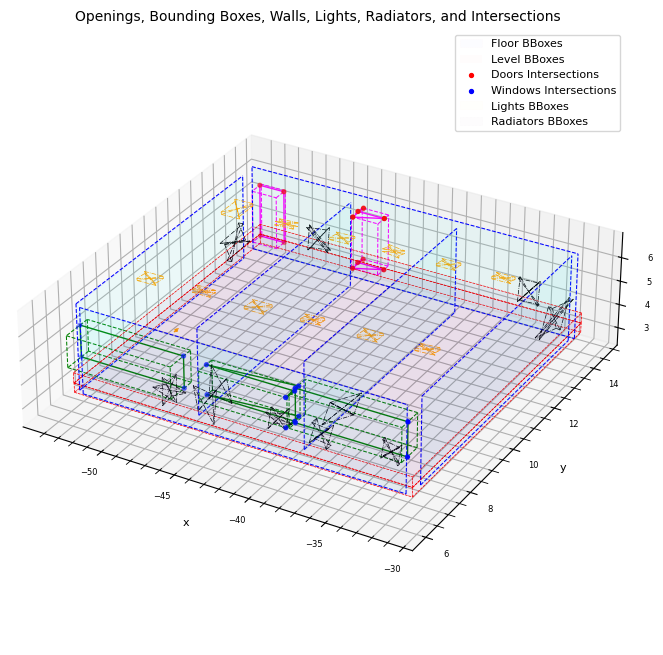

In [110]:
# Function to plot 3D bounding boxes with both surfaces and edges
def plot_levels_bboxes(ax, bboxes, color='blue', edge_color='black', label=None, linewidth=1, linestyle='-'):
    for bbox in bboxes:
        assert len(bbox) == 8, "Each bounding box should have 8 vertices."
        
        verts = [
            [bbox[0], bbox[1], bbox[2], bbox[3]],  # Bottom face
            [bbox[4], bbox[5], bbox[6], bbox[7]],  # Top face
            [bbox[0], bbox[1], bbox[5], bbox[4]],  # Side face
            [bbox[1], bbox[2], bbox[6], bbox[5]],  # Side face
            [bbox[2], bbox[3], bbox[7], bbox[6]],  # Side face
            [bbox[3], bbox[0], bbox[4], bbox[7]],  # Side face
        ]
        
        ax.add_collection3d(Poly3DCollection(verts, color=color, alpha=0.01, edgecolor=edge_color, linewidths=linewidth, linestyle=linestyle, label=label))
        
        # Plot edges of the bounding box (lines between vertices)
        edges = [
            (bbox[0], bbox[1]), (bbox[1], bbox[2]), (bbox[2], bbox[3]), (bbox[3], bbox[0]),  # Bottom edges
            (bbox[4], bbox[5]), (bbox[5], bbox[6]), (bbox[6], bbox[7]), (bbox[7], bbox[4]),  # Top edges
            (bbox[0], bbox[4]), (bbox[1], bbox[5]), (bbox[2], bbox[6]), (bbox[3], bbox[7])   # Vertical edges
        ]
        for edge in edges:
            p1, p2 = edge
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color=edge_color, linewidth=linewidth, linestyle=linestyle)
        label = None  # Avoid repeating the label

# Function to plot bounding box edges
def plot_edges(ax, edges, color='cyan', label=None, linewidth=1, linestyle='-'):
    for edge in edges:
        assert len(edge) == 2, "Each edge should be a pair of points."
        p1, p2 = edge
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color=color, linewidth=linewidth, linestyle=linestyle)

# Function to plot walls and surfaces
def plot_wall_lines(ax, walls_results):
    for i, result in enumerate(walls_results):
        top_center_lines = result['top_center_lines']
        base_center_lines = result['base_center_lines']
        
        # Plot top and base center lines
        for line in top_center_lines:
            ax.plot([p[0] for p in line], [p[1] for p in line], [p[2] for p in line], color='b', linewidth=0.75, linestyle='--')
        for line in base_center_lines:
            ax.plot([p[0] for p in line], [p[1] for p in line], [p[2] for p in line], color='b', linewidth=0.75, linestyle='--')
        
        # Plot vertical edges linking top and base center lines
        for top_line, base_line in zip(top_center_lines, base_center_lines):
            for top_point, base_point in zip(top_line, base_line):
                ax.plot([base_point[0], top_point[0]], [base_point[1], top_point[1]], [base_point[2], top_point[2]], color='b', linewidth=0.75, linestyle='--')

        # Plot surfaces enclosed by top and base lines and vertical edges
        for top_line, base_line in zip(top_center_lines, base_center_lines):
            for j in range(len(top_line) - 1):
                points = [base_line[j], base_line[j+1], top_line[j+1], top_line[j]]
                verts = [list(zip([p[0] for p in points], [p[1] for p in points], [p[2] for p in points]))]
                ax.add_collection3d(Poly3DCollection(verts, color='cyan', alpha=0.05, edgecolor='b'))

# Plot configuration and data

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

def process_vertices(vertices):
    # Initialize lists to store edges and surfaces
    edges_openings_projected = []
    surfaces_openings_projected = []

    for i, vertex_set in enumerate(vertices):
        # Check if there are exactly 4 vertices for a surface
        if len(vertex_set) != 4:
            print(f"Skipping {i + 1}: Expected 4 vertices, but got {len(vertex_set)}")
            continue

        # Extract the four vertices
        v1, v2, v3, v4 = vertex_set

        # Define edges by connecting adjacent vertices in a rectangle (in correct order)
        edges = [
            (v1, v2),  # Edge from vertex 1 to vertex 2
            (v2, v4),  # Edge from vertex 2 to vertex 3
            (v3, v4),  # Edge from vertex 3 to vertex 4
            (v3, v1)   # Closing the loop from vertex 4 to vertex 1
        ]

        # Store edges in the list
        edges_openings_projected.extend(edges)

        surface = [v1, v2, v3, v4]
        surfaces_openings_projected.append(surface)

        # Optional: Output results for debugging or logging
        print(f"Opening {i + 1}:")
        print("Edges:")
        for edge in edges:
            print(f"  {edge[0]} -> {edge[1]}")
        
        print("Surface (Rectangle/Quadrilateral):")
        print(f"  {surface}")
        print("-" * 40)

    return edges_openings_projected, surfaces_openings_projected


edges_doors_projected, surfaces_doors_projected = process_vertices(grouped_doors_intersections)

# Plot doors and windows if available
if doors_edges_flat is not None and len(doors_edges_flat) > 0:
    plot_edges(ax, doors_edges_flat, color='magenta', label='Doors BBox', linewidth=0.75, linestyle='--')
if windows_edges_flat is not None and len(windows_edges_flat) > 0:
    plot_edges(ax, windows_edges_flat, color='green', label='Windows BBox', linewidth=0.75, linestyle='--')
if edges_doors_projected is not None and len(edges_doors_projected) > 0:
    plot_edges(ax, edges_doors_projected, color='magenta', label='Doors Edges', linewidth=1)
if edges_windows_projected is not None and len(edges_windows_projected) > 0:
    plot_edges(ax, edges_windows_projected, color='green', label='Windows Edges', linewidth=1)

# Plot floor and ceiling bounding boxes if available
if floor_bboxes is not None and len(floor_bboxes) > 0:
    plot_levels_bboxes(ax, floor_bboxes, color='blue', edge_color='r', label='Floor BBoxes', linewidth=0.50, linestyle='--')
if ceiling_bboxes is not None and len(ceiling_bboxes) > 0:
    plot_levels_bboxes(ax, ceiling_bboxes, color='green', edge_color='r', label='Ceiling BBoxes', linewidth=0.50, linestyle='--')

# Plot combined level bounding boxes if available
if level_bboxes is not None and len(level_bboxes) > 0:
    plot_levels_bboxes(ax, level_bboxes, color='red', edge_color='r', label='Level BBoxes', linewidth=0.10, linestyle='--')

# Plot walls if available
if walls_results is not None and len(walls_results) > 0:
    plot_wall_lines(ax, walls_results)

# Plot doors and windows intersection points if available
if doors_intersections is not None and doors_intersections.size > 0:
    ax.scatter(doors_intersections[:, 0], doors_intersections[:, 1], doors_intersections[:, 2], color='red', label="Doors Intersections", s=8)
if windows_intersections is not None and windows_intersections.size > 0:
    ax.scatter(windows_intersections[:, 0], windows_intersections[:, 1], windows_intersections[:, 2], color='blue', label="Windows Intersections", s=8)

# Plot lights and radiators bounding boxes if available
if all_lights_bbox_vertices is not None and len(all_lights_bbox_vertices) > 0:
    plot_levels_bboxes(ax, all_lights_bbox_vertices, color='yellow', edge_color='orange', label='Lights BBoxes', linewidth=0.5, linestyle='-.')
if all_radiators_bbox_vertices is not None and len(all_radiators_bbox_vertices) > 0:
    plot_levels_bboxes(ax, all_radiators_bbox_vertices, color='purple', edge_color='black', label='Radiators BBoxes', linewidth=0.5, linestyle='-.')

# Plot tech system edges (lights and radiators) if available
if all_tech_edges is not None and len(all_tech_edges) > 0:
    # Check if each edge is a pair of 3D points
    valid_edges = []
    for edge in all_tech_edges:
        if len(edge) == 2 and all(len(point) == 3 for point in edge):
            valid_edges.append(edge)  # Only add valid edges to be plotted
        else:
            print(f"Invalid edge format: {edge}")

    # Plot valid edges
    if len(valid_edges) > 0:
        plot_edges(ax, valid_edges, color='yellow', label='Tech System Edges', linewidth=1)
    else:
        print("No valid tech system edges to plot.")

# Set labels and title
ax.set_xlabel('x', fontsize = 8) 
ax.set_ylabel('y', fontsize= 8)
ax.set_zlabel('z', fontsize= 8)
plt.title('Openings, Bounding Boxes, Walls, Lights, Radiators, and Intersections', fontsize=10)

# Customize grid and ticks
plt.minorticks_on()
plt.tick_params(which='major', labelsize= 6)
plt.grid(which='major', linestyle='-', linewidth=0.35, color='black')
plt.grid(which='minor', linestyle=':', linewidth=0.5, color='lightgray')

# Set aspect ratio and limits for better visualization
ax.set_box_aspect([1, 1, 0.3])

# Add legend (ensure no duplicates)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize=8)

# Show the plot
plt.show()


ASSOCIATE Z VALUES - WATER TANK MODEL

N.B. Wall results is the wall_data or metadata

In [38]:
walls_results

[{'vertices': array([[-53.43970227,   6.68747445,   3.052     ],
         [-53.9395799 ,   6.68747445,   3.052     ],
         [-53.9395799 ,  13.71310761,   3.052     ],
         [-53.43970227,  13.71310761,   3.052     ],
         [-53.43970227,   6.68747445,   6.657     ],
         [-53.9395799 ,   6.68747445,   6.657     ],
         [-53.9395799 ,  13.71310761,   6.657     ],
         [-53.43970227,  13.71310761,   6.657     ]]),
  'edges': [[array([-53.43970227,   6.68747445,   3.052     ]),
    array([-53.9395799 ,   6.68747445,   3.052     ])],
   [array([-53.9395799 ,   6.68747445,   3.052     ]),
    array([-53.9395799 ,  13.71310761,   3.052     ])],
   [array([-53.9395799 ,  13.71310761,   3.052     ]),
    array([-53.43970227,  13.71310761,   3.052     ])],
   [array([-53.43970227,  13.71310761,   3.052     ]),
    array([-53.43970227,   6.68747445,   3.052     ])],
   [array([-53.43970227,   6.68747445,   6.657     ]),
    array([-53.9395799 ,   6.68747445,   6.657     ])]

In [39]:
def extract_z_levels(floor_bboxes, ceiling_bboxes):
    # Convert the NumPy arrays to lists for easy manipulation
    floor_bboxes_list = list(floor_bboxes)
    ceiling_bboxes_list = list(ceiling_bboxes)

    # Concatenate the lists of floor and ceiling bounding boxes
    levels_bboxes = floor_bboxes_list + ceiling_bboxes_list

    z_min_values = []
    z_max_values = []
    
    # Extract z_min and z_max from each bounding box (assuming list or tuple structure)
    for bbox in levels_bboxes:
        # Assuming z_min is the first element and z_max is the second element
        z_min = bbox[0]  # Access the z_min value by index
        z_max = bbox[1]  # Access the z_max value by index
        z_min_values.append(z_min)
        z_max_values.append(z_max)
        print(f'Bounding Box z_min: {z_min}, z_max: {z_max}')
    
    return levels_bboxes, z_min_values, z_max_values


In [113]:
levels_bboxes, z_min_values, z_max_values = extract_z_levels(floor_bboxes, ceiling_bboxes)
print(type(level_bboxes))

Bounding Box z_min: [-53.81360941   6.54984514   3.052     ], z_max: [-31.08460941   6.54984514   3.052     ]
Bounding Box z_min: [-53.81560941   6.54184514   3.449     ], z_max: [-31.08560941   6.54184514   3.449     ]
<class 'numpy.ndarray'>


WATERTANK COMPLEX CELL MODEL (WCCM)

In [40]:
z_threshold = 0.50

In [ ]:
# kul.process_laz_nodes

In [63]:
def compute_obb(coordinates_):
    # Check if coordinates_ is already a NumPy array
    if isinstance(coordinates_, np.ndarray):
        coordinates = coordinates_  # Directly use the array if it's already a single NumPy array
    elif isinstance(coordinates_, list) and all(isinstance(item, np.ndarray) for item in coordinates_):
        coordinates = np.vstack(coordinates_)  # Vertically stack all arrays into one
    else:
        raise ValueError("Expected a list of NumPy arrays or a single NumPy array.")

    # Ensure we have valid coordinates
    if coordinates.shape[1] != 3:
        raise ValueError(f"Expected 3D coordinates, but got shape: {coordinates.shape}")

    # Compute the center of the points
    obb_center = np.mean(coordinates, axis=0)

    # Use PCA to find the principal axes (rotation matrix)
    cov_matrix = np.cov(coordinates.T)
    eig_values, eig_vectors = np.linalg.eigh(cov_matrix)

    # Sort the eigenvalues and eigenvectors
    sort_indices = np.argsort(eig_values)[::-1]
    eig_values = eig_values[sort_indices]
    eig_vectors = eig_vectors[:, sort_indices]

    # The rotation matrix is made from the eigenvectors
    rotation_matrix = eig_vectors

    # Rotate the points to align with the principal axes
    rotated_points = (coordinates - obb_center) @ rotation_matrix

    # Find the min and max extents along each axis
    min_extent = np.min(rotated_points, axis=0)
    max_extent = np.max(rotated_points, axis=0)

    # The extents are the half-lengths of the OBB in each direction
    obb_extent = (max_extent - min_extent) / 2

    # The 8 vertices of the OBB in the rotated space
    obb_vertices_local = np.array([
        [min_extent[0], min_extent[1], min_extent[2]],
        [min_extent[0], min_extent[1], max_extent[2]],
        [min_extent[0], max_extent[1], min_extent[2]],
        [min_extent[0], max_extent[1], max_extent[2]],
        [max_extent[0], min_extent[1], min_extent[2]],
        [max_extent[0], min_extent[1], max_extent[2]],
        [max_extent[0], max_extent[1], min_extent[2]],
        [max_extent[0], max_extent[1], max_extent[2]]
    ])

    # Transform the OBB vertices back to the original coordinate system
    obb_vertices_list = (obb_vertices_local @ rotation_matrix.T) + obb_center

    return obb_center, obb_extent, obb_vertices_list, rotation_matrix


def bbox_topology(floor_bboxes, ceiling_bboxes, obb_extent, obb_vertices_list, rotation_matrix, coordinates_, z_threshold):
    # Compute the bounding box center
    bbox_center = np.mean(obb_vertices_list, axis=0)

    # Compute the base, middle, and top points for the bounding box
    start_point_base = obb_vertices_list[0]
    end_point_base = obb_vertices_list[4]  # Corresponding vertices in OBB
    start_point_top = obb_vertices_list[1]
    end_point_top = obb_vertices_list[5]
    
    start_point_middle = (start_point_base + start_point_top) / 2
    end_point_middle = (end_point_base + end_point_top) / 2

    # Compute length and thickness of the wall
    length = np.linalg.norm(end_point_base - start_point_base)

    # Ensure obb_extent is a vector (like an array or list) with at least two values
    if isinstance(obb_extent, (list, np.ndarray)) and len(obb_extent) > 1:
        # Compute thickness as the minimum extent (i.e., smallest dimension)
        thickness = min(obb_extent)
    else:
        raise ValueError(f"obb_extent is not a valid vector: {obb_extent}")
        
    # Compute extents (x, y, z)
    extents = np.ptp(obb_vertices_list, axis=0)  # Peak-to-peak (range) for each axis

    # Compute extents (x, y, z)
    extents = np.ptp(obb_vertices_list, axis=0)  # Peak-to-peak (range) for each axis
    extent_x, extent_y, extent_z = extents

    # Adjust the Z-values based on the Z-threshold
    adjusted_min_z = np.min(coordinates_[:, 2]) + z_threshold
    adjusted_max_z = np.max(coordinates_[:, 2]) - z_threshold

    return (
        bbox_center, start_point_middle, end_point_middle, start_point_base, end_point_base,
        start_point_top, end_point_top, length, thickness, extents, extent_x, extent_y, extent_z, 
        obb_extent, adjusted_min_z, adjusted_max_z, rotation_matrix
    )


In [64]:
obb_center, obb_extent, obb_vertices_list, rotation_matrix = compute_obb(wall_coordinates)

In [65]:
for wall in walls_nodes:
    # Extract class_id and object_id from the wall node
    class_id = wall.class_id  # Assuming wall node has a class_id attribute
    object_id = wall.object_id  # Assuming wall node has an object_id attribute

    # Extract the points that belong to this specific wall from the laz dataset
    idx = np.where((laz.classes == class_id) & (laz.objects == object_id))

    if idx is not None and len(idx[0]) > 0:  # Ensure valid and non-empty indices
        coord_x = laz.x[idx]
        coord_y = laz.y[idx]
        coord_z = laz.z[idx]

        # Combine the x, y, z coordinates into a single NumPy array
        coordinates_ = np.vstack((coord_x, coord_y, coord_z)).T  # Shape (n, 3) where n is the number of points

        # Append the coordinates to the list
        wall_coordinates.append(coordinates_)

        # Now package class_id, object_id, and coordinates_ into wall_data
        wall_data = (class_id, object_id, coordinates_)

In [66]:
def process_wall(walls_nodes, laz, floor_bboxes, ceiling_bboxes, z_threshold):
    wall_metadata = []

    for wall in walls_nodes:
        # Extract class_id and object_id from the wall node
        class_id = wall.class_id  # Assuming wall node has a class_id attribute
        object_id = wall.object_id  # Assuming wall node has an object_id attribute

        # Extract the points that belong to this specific wall from the laz dataset
        idx = np.where((laz.classes == class_id) & (laz.objects == object_id))

        if idx is not None and len(idx[0]) > 0:  # Ensure valid and non-empty indices
            coord_x = laz.x[idx]
            coord_y = laz.y[idx]
            coord_z = laz.z[idx]

            # Combine the x, y, z coordinates into a single NumPy array
            coordinates_ = np.vstack((coord_x, coord_y, coord_z)).T  # Shape (n, 3) where n is the number of points

            # Now package class_id, object_id, and coordinates_ into wall_data
            wall_data = (class_id, object_id, coordinates_)
        
            # Process the wall data
            if len(coordinates_) > 3:  # Ensure we have enough coordinates to compute OBB
                
                # Compute the OBB (Oriented Bounding Box) for the wall
                obb_center, obb_extent, obb_vertices_list, rotation_matrix = compute_obb(coordinates_)

                # Compute the bounding box topology
                bbox_topology_data = bbox_topology(
                    floor_bboxes, ceiling_bboxes, obb_extent, obb_vertices_list, 
                    rotation_matrix, coordinates_, z_threshold
                )

                (bbox_center, start_point_middle, end_point_middle, start_point_base, end_point_base,
                 start_point_top, end_point_top, length, thickness, extents, extent_x, extent_y, extent_z, 
                 obb_extent, adjusted_min_z, adjusted_max_z, rotation_matrix) = bbox_topology_data

                # Create the wall metadata dictionary
                wall_metadata_entry = {
                    'object_id': object_id,
                    'class_id': class_id,
                    'min_z': float(adjusted_min_z),
                    'max_z': float(adjusted_max_z),
                    'height': float(adjusted_max_z - adjusted_min_z),
                    'start_point_base': [float(x) for x in start_point_base],
                    'end_point_base': [float(x) for x in end_point_base],
                    'start_point_middle': [float(x) for x in start_point_middle],
                    'end_point_middle': [float(x) for x in end_point_middle],
                    'start_point_top': [float(x) for x in start_point_top],
                    'end_point_top': [float(x) for x in end_point_top],
                    'length': float(length),
                    'thickness': float(thickness),
                    'normal': rotation_matrix[:, 2].tolist(),
                    'z_axes': rotation_matrix[:, 2].tolist(),
                    'angle_degrees': float(np.rad2deg(np.arctan2(rotation_matrix[1, 0], rotation_matrix[0, 0])))
                }

                wall_metadata.append(wall_metadata_entry)

    return wall_metadata

In [67]:
wall_metadata = process_wall(walls_nodes, laz, floor_bboxes, ceiling_bboxes, z_threshold)

EXPORT WALL json

In [68]:
output_file_path = output_folder / f'{name}'
output_json_walls_file = output_file_path / f'{name}_walls.json'
output_json_floors_file = output_file_path / f'{name}_floors.json'
output_json_openings_file = output_file_path / f'{name}_openings.json'
output_json_columns_file = output_file_path / f'{name}_columns.json'
output_json_devices_file = output_file_path / f'{name}_devices.json'

print(f'JSON folder output {output_file_path}')

JSON folder output c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\school_v1


In [69]:
# Function to write wall metadata to a JSON file
def export_metadata_to_json(wall_metadata, output_json_file):
    try:
        # Open the file in write mode
        with open(output_json_file, 'w') as f:
            # Dump the wall_metadata to the JSON file with indentation for readability
            json.dump(wall_metadata, f, indent=4)
        print(f"Metadata successfully written to {output_json_file}")
    except Exception as e:
        print(f"Failed to write metadata to JSON: {str(e)}")

# Example usage after processing the wall metadata
output_directory = output_file_path

# Make sure the directory exists
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

output_json_file = output_json_walls_file
# os.path.join(output_directory, 'wall_metadata_output.json')

wall_metadata = process_wall(walls_nodes, laz, floor_bboxes, ceiling_bboxes, z_threshold)
export_metadata_to_json(wall_metadata, output_json_file)


Metadata successfully written to c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\school_v1\school_v1_walls.json


In [43]:
z_threshold = 0.15
t_intersection=0.5
t_orthogonal=0.5

def compute_normal(start_point, end_point):
    """Compute the normal vector to the wall plane given start and end points."""
    direction = np.array(end_point) - np.array(start_point)
    normal = np.array([-direction[1], direction[0], 0])  # 2D normal vector for the wall
    normalized_normal = normal / np.linalg.norm(normal)
    return normal, normalized_normal

def extract_z_levels(floor_bboxes, ceiling_bboxes):
    """Extract z_min and z_max values from floor and ceiling bounding boxes."""
    z_min_values = [bbox[2][2] for bbox in floor_bboxes]
    z_max_values = [bbox[6][2] for bbox in ceiling_bboxes]
    return z_min_values, z_max_values

def find_closest_level(z_value, z_values, threshold):
    """Find the closest level to a given z_value within a threshold."""
    for i, z in enumerate(z_values):
        if abs(z_value - z) < threshold:
            return i, z
    return None, None

def intersect_line_2d(start1, end1, start2, end2, strict=True):
    """Find intersection point of two lines in 2D."""
    def ccw(A, B, C):
        return (C[1] - A[1]) * (B[0] - A[0]) > (B[1] - A[1]) * (C[0] - A[0])

    A, B, C, D = start1, end1, start2, end2
    return (ccw(A, C, D) != ccw(B, C, D)) and (ccw(A, B, C) != ccw(A, B, D))

def get_oriented_bounding_box(start_point, end_point, normal, thickness, height):
    """
    Generates an oriented bounding box for a wall based on its axis, normal, thickness, and height.

    Args:
        start_point (np.ndarray): The starting point of the wall (base of the wall).
        end_point (np.ndarray): The ending point of the wall (base of the wall).
        normal (np.ndarray): The outward normal vector of the wall.
        thickness (float): The thickness of the wall.
        height (float): The height of the wall.

    Returns:
        o3d.geometry.OrientedBoundingBox: The oriented bounding box representing the 3D wall geometry.
    """
    # Calculate the direction of the wall axis (normalized)
    direction = (end_point - start_point) / np.linalg.norm(end_point - start_point)

    # Compute the outward normal in the XY plane if not already normalized
    outward_normal = np.cross(direction, np.array([0, 0, 1]))

    # Ensure the normal is normalized
    outward_normal = outward_normal / np.linalg.norm(outward_normal)

    # Create the 4 base corner points of the wall (before adding height)
    base_points = [
        start_point + outward_normal * thickness / 2,  # Top-left base
        start_point - outward_normal * thickness / 2,  # Bottom-left base
        end_point + outward_normal * thickness / 2,    # Top-right base
        end_point - outward_normal * thickness / 2     # Bottom-right base
    ]

    # Add height to each of the base points to create the upper corners
    upper_points = [p + np.array([0, 0, height]) for p in base_points]

    # Combine base and upper points to form a complete set of 8 points
    all_points = np.array(base_points + upper_points)

    # Create a point cloud from the wall points
    pcd = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(all_points))

    # Generate the oriented bounding box from the point cloud
    oriented_bbox = pcd.get_oriented_bounding_box()

    return oriented_bbox

walls_data = object_points(laz, graph_path)

Number of wall nodes: 6


In [44]:
def walls_topology(walls_data, floor_bboxes, ceiling_bboxes, laz, t_intersection, t_orthogonal):
   
    for wall_data in walls_data:
        
        wall_metadata = process_wall_data(laz, wall_data)
                
        if wall_metadata is None:
            continue

        z_min_wall = float(wall_metadata['min_z'])
        z_max_wall = float(wall_metadata['max_z'])
        height_wall = float(wall_metadata['height'])
       
        start_point_base = np.array(wall_metadata['start_point_base'])
        end_point_base = np.array(wall_metadata['end_point_base'])
        length = np.linalg.norm(end_point_base - start_point_base)
        print(f'Wall {wall_metadata["object_id"]} length {length} height: {height_wall}')

        # Compute normal
        normal, normalized_normal = compute_normal(start_point_base, end_point_base)
        wall_thickness = float(wall_metadata['thickness'])

        # Get the oriented bounding box for the wall
        oriented_bbox = get_oriented_bounding_box(start_point_base, end_point_base, normal, wall_thickness, height_wall)
        
        # Create the TriangleMesh for the wall
        n_wall = o3d.geometry.TriangleMesh.create_from_oriented_bounding_box(oriented_bbox)
        
        # Create the LineSet for the wall bounding box
        wallBox = o3d.geometry.LineSet.create_from_oriented_bounding_box(oriented_bbox)
        wallBox.paint_uniform_color([0, 0, 1])  # Blue for the wall box

        # Add the wall and bounding box to metadata
        wall_metadata['wall'] = n_wall
        wall_metadata['wallBox'] = wallBox

        print(f'name: {wall_metadata["object_id"]}, wall: {n_wall}')


In [42]:
walls_topology(wall_metadata, floor_bboxes, ceiling_bboxes, laz, t_intersection, t_orthogonal)

NameError: name 'wall_metadata' is not defined

In [113]:
def walls_topology(walls_data, floor_bboxes, ceiling_bboxes, laz, t_intersection, t_orthogonal):
    
    for wall_data in walls_data:
        
        wall_metadata = process_wall_data(laz, wall_data)
                
        if wall_metadata is None:
            continue

        z_min_wall = float(wall_metadata['min_z'])
        z_max_wall = float(wall_metadata['max_z'])
        height_wall = float(wall_metadata['height'])
       
        start_point_base = np.array(wall_metadata['start_point_base'])
        end_point_base = np.array(wall_metadata['end_point_base'])
        length = np.linalg.norm(end_point_base - start_point_base)
        print(f'Wall {wall_metadata["object_id"]} length {length} height: {height_wall}')

        # Compute orthogonal curves
        normal, normalized_normal = compute_normal(start_point_base, end_point_base)
        wall_thickness = float(wall_metadata['thickness'])
        orthogonal_startpoint = start_point_base + normal * wall_thickness / 2
        orthogonal_endpoint = end_point_base + normal * wall_thickness / 2

        # Extract z values from levels
        z_min_values, z_max_values = extract_z_levels(floor_bboxes, ceiling_bboxes)

        # Find closest levels for z_min and z_max
        min_level_idx, min_z_level = find_closest_level(z_min_wall, z_min_values, z_threshold)
        max_level_idx, max_z_level = find_closest_level(z_max_wall, z_max_values, z_threshold)

        # Print closest floor and ceiling levels
        if min_level_idx is not None:
            print(f'Wall {wall_metadata["object_id"]} is close to floor level {min_level_idx} with z_min {min_z_level}')
        if max_level_idx is not None:
            print(f'Wall {wall_metadata["object_id"]} is close to ceiling level {max_level_idx} with z_max {max_z_level}')

        # Compute intersections with nearby walls
        axisPoints = np.array([start_point_base, end_point_base])
        axisPointsOrthogonal = np.array([orthogonal_startpoint, orthogonal_endpoint])

        # Create a list of resources excluding the current wall
        resources = [w['resource'] for w in walls_data if w['object_id'] != wall_metadata['object_id']]
        print("Number of resources:", len(resources))

        if resources:
            # Assuming gmu.create_identity_point_cloud returns a PointCloud object
            referencePcd, identityArray = gmu.create_identity_point_cloud(resources)
            reference_points = np.asarray(referencePcd.points)

            # Compute nearest neighbors
            idx, distances = gmu.compute_nearest_neighbors(axisPoints, reference_points, n=10)
            idx = idx[np.where(distances < t_intersection)]
            points = np.asarray(referencePcd.points)[idx]
            indices = identityArray[idx]
            nearby_walls = [walls_data[i] for i in indices]
            print(f'Found {len(nearby_walls)} nearby walls for {wall_metadata["object_id"]}')

            # Process intersections with nearby walls
            for w in nearby_walls:
                w_metadata = process_wall_data(laz, w)
                if w_metadata is None:
                    continue

                w_start_point = np.array(w_metadata['start_point_base'])
                w_end_point = np.array(w_metadata['end_point_base'])
                w_orthogonal_startpoint = w_start_point + normal * wall_thickness / 2
                w_orthogonal_endpoint = w_end_point + normal * wall_thickness / 2

                # Check intersection between wall axes
                intersection_point = intersect_line_2d(start_point_base, end_point_base, w_start_point, w_end_point)
                if intersection_point is not None:
                    d = distance.euclidean(np.ravel(intersection_point), np.ravel(start_point_base))
                    if d < t_intersection:
                        print(f'Intersection between {wall_metadata["object_id"]} and {w_metadata["object_id"]} at {intersection_point}, distance: {d}')

                # Check intersection between orthogonal curves
                orthogonal_intersection_point = intersect_line_2d(orthogonal_startpoint, orthogonal_endpoint, w_orthogonal_startpoint, w_orthogonal_endpoint)
                if orthogonal_intersection_point is not None:
                    d = distance.euclidean(np.ravel(orthogonal_intersection_point), np.ravel(orthogonal_startpoint))
                    if d < t_orthogonal:
                        print(f'Orthogonal intersection between {wall_metadata["object_id"]} and {w_metadata["object_id"]} at {orthogonal_intersection_point}, distance: {d}')

        # Process wall nodes into a point cloud and mesh
        point_list = []

        points = np.array([start_point_base, end_point_base])
        point_list.extend(points + normal * wall_thickness / 2)  # Positive side
        point_list.extend(points - normal * wall_thickness / 2)  # Negative side
        point_list.extend(np.array(point_list) + np.array([0, 0, height_wall]))  # Add height dimension

        # Convert points into a PointCloud and create bounding box
        pcd = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(point_list))
        box = pcd.get_oriented_bounding_box()
        
        # Create TriangleMesh for the wall and a LineSet for the bounding box
        n_wall = o3d.geometry.TriangleMesh.create_from_oriented_bounding_box(box)
        wallBox = o3d.geometry.LineSet.create_from_oriented_bounding_box(box)
        wallBox.paint_uniform_color([0, 0, 1])

        # Add the wall and bounding box to metadata
        wall_metadata['wall'] = n_wall
        wall_metadata['wallBox'] = wallBox

        print(f'name: {wall_metadata["object_id"]}, wall: {n_wall}')

In [114]:
walls_topology(walls_data, floor_bboxes, ceiling_bboxes, laz, t_intersection, t_orthogonal)

NameError: name 'walls_data' is not defined

EXPORT WALLS TOPOLOGY: JSON AND OBJ

In [115]:
def export_walls_topology(wall_metadata, output_json_file):
    json_data = {
        "filename": ut.get_filename(output_json_file),
        "objects": []
    }

    for wall in wall_metadata:
        if wall is None:
            continue  # Skip if wall is None

        # Ensure all required keys are present in the wall data
        object_id = wall.get('object_id')
        min_z = wall.get('min_z')
        max_z = wall.get('max_z')
        height = wall.get('height')

        # If any essential field is missing, skip this wall
        if object_id is None or min_z is None or max_z is None or height is None:
            print(f"Skipping wall due to missing essential fields: {wall}")
            continue

        # Create the JSON object for each wall, handling missing optional fields safely
        json_dta = {
            'object_id': object_id,
            'wall min_z': float(min_z),
            'wall max_z': float(max_z),
            'wall height': float(height),
            'lower level': wall.get('min_level_idx', None),  # Use get() for optional fields
            'upper level': wall.get('max_level_idx', None),
            'start_base_point': wall.get('start_point_base'),
            'end_base_point': wall.get('end_point_base'),
            'start_middle_point': wall.get('start_point_middle'),
            'end_middle_point': wall.get('end_point_middle'),
            'start_top_point': wall.get('start_point_top'),
            'end_top_point': wall.get('end_point_top'),
            'wall length': wall.get('length'),
            'wall thickness': wall.get('thickness'),
            'normal vector': wall.get('normal'),
            'wall z axes': wall.get('z_axes'),
            'angle_degrees': wall.get('angle_degrees')
        }

        # Append the created JSON object to the main data
        json_data["objects"].append(json_dta)

    # Write this information to the JSON file
    with open(output_json_file, "w") as json_file:
        json.dump(json_data, json_file, indent=4)

    print(f"JSON data written to file: {output_json_file}")export_walls_topology(wall_metadata, output_json_file)

SyntaxError: invalid syntax (1431897780.py, line 50)

In [116]:
export_walls_topology(wall_metadata, output_json_file)

NameError: name 'export_walls_topology' is not defined

CREATE MESHES FOR ELEMENTS

In [117]:
output_folder = path /'outputs' 
output_obj_file = os.path.join(output_folder,  'walls_obj')
vertices, edges, faces = create_topological_model(wall_metadata)

NameError: name 'wall_metadata' is not defined

In [118]:
def create_topological_model(wall_metadata):

    vertices = []
    edges = []
    faces = []

    for wall in wall_metadata:
        if wall is None:
            continue

        object_id = wall.get('object_id')

        base_i_vertex = wall.get('start_point_base')
        base_j_vertex = wall.get('end_point_base')
        top_i_vertex = wall.get('start_point_top')
        top_j_vertex = wall.get('end_point_top')

        # Skip if any essential points are missing
        if not (base_i_vertex and base_j_vertex and top_i_vertex and top_j_vertex):
            print(f"Skipping wall due to missing essential points: {wall}")
            continue

        # Convert points to vertices
        start_base = tuple(base_i_vertex)
        end_base = tuple(base_j_vertex)
        start_top = tuple(top_i_vertex)
        end_top = tuple(top_j_vertex)

        # Define indices for new vertices
        base_i_idx = len(vertices) + 1
        vertices.append(start_base)
        base_j_idx = len(vertices) + 1
        vertices.append(end_base)
        top_i_idx = len(vertices) + 1
        vertices.append(start_top)
        top_j_idx = len(vertices) + 1
        vertices.append(end_top)

        # Define edges
        edges.append((base_i_idx, base_j_idx))
        edges.append((base_j_idx, top_j_idx))
        edges.append((top_j_idx, top_i_idx))
        edges.append((top_i_idx, base_i_idx))

        # Define faces (avoid duplicates)
        new_faces = [
            [base_i_idx, base_j_idx, top_j_idx, top_i_idx],  # Top face
            # Add more faces if needed, ensuring no duplicates
        ]

        for face in new_faces:
            if face not in faces:
                faces.append(face)

        print(f'Wall {object_id}: Added vertices {base_i_idx}, {base_j_idx}, {top_i_idx}, {top_j_idx}')
        print(f'Edges: {edges}')
        print(f'Faces: {faces}')

    return vertices, edges, faces


In [119]:
vertices, edges, faces = create_topological_model(wall_metadata)

NameError: name 'wall_metadata' is not defined

In [54]:
output_folder = 'c:\\Users\\oscar\\OneDrive - Fondazione Bruno Kessler\\KUL_GeometricModel\\outputs'
output_obj_file = os.path.join(output_folder, 'walls.obj')  # Ensure it's a file

def write_obj_file(vertices, faces, output_file):

    with open(output_file, 'w') as obj_file:
        # Write vertices
        for vertex in vertices:
            obj_file.write(f"v {vertex[0]} {vertex[1]} {vertex[2]}\n")
        
        # Write faces
        for face in faces:
            # Face indices in OBJ format are 1-based
            obj_file.write(f"f {' '.join(str(index) for index in face)}\n")


write_obj_file(vertices, faces, output_obj_file)

In [97]:
export_walls_to_obj(wall_metadata, output_obj_file)

Wall 2002: Added vertices 1, 2, 3, 4
Edges: [(1, 2), (2, 4), (4, 3), (3, 1)]
Faces: [[1, 2, 4, 3], [1, 2, 2, 3]]
Wall 2003: Added vertices 5, 6, 7, 8
Edges: [(1, 2), (2, 4), (4, 3), (3, 1), (5, 6), (6, 8), (8, 7), (7, 5)]
Faces: [[1, 2, 4, 3], [1, 2, 2, 3], [5, 6, 8, 7], [5, 6, 6, 7]]
Wall 2007: Added vertices 9, 10, 11, 12
Edges: [(1, 2), (2, 4), (4, 3), (3, 1), (5, 6), (6, 8), (8, 7), (7, 5), (9, 10), (10, 12), (12, 11), (11, 9)]
Faces: [[1, 2, 4, 3], [1, 2, 2, 3], [5, 6, 8, 7], [5, 6, 6, 7], [9, 10, 12, 11], [9, 10, 10, 11]]
Wall 2008: Added vertices 13, 14, 15, 16
Edges: [(1, 2), (2, 4), (4, 3), (3, 1), (5, 6), (6, 8), (8, 7), (7, 5), (9, 10), (10, 12), (12, 11), (11, 9), (13, 14), (14, 16), (16, 15), (15, 13)]
Faces: [[1, 2, 4, 3], [1, 2, 2, 3], [5, 6, 8, 7], [5, 6, 6, 7], [9, 10, 12, 11], [9, 10, 10, 11], [13, 14, 16, 15], [13, 14, 14, 15]]
Wall 2009: Added vertices 17, 18, 19, 20
Edges: [(1, 2), (2, 4), (4, 3), (3, 1), (5, 6), (6, 8), (8, 7), (7, 5), (9, 10), (10, 12), (12, 11),

In [120]:
def export_walls_to_obj(wall_metadata, output_obj_file):
    
    def write_vertex(file, vertex):
        file.write(f"v {vertex[0]} {vertex[1]} {vertex[2]}\n")

    def write_face(file, face):
        file.write(f"f {' '.join(str(index) for index in face)}\n")

    vertices = []
    faces = []

    for wall in wall_metadata:
        if wall is None:
            continue  # Skip if wall is None

        # Ensure all required keys are present in the wall data
        start_base_point = wall.get('start_point_base')
        end_base_point = wall.get('end_point_base')
        start_top_point = wall.get('start_point_top')
        end_top_point = wall.get('end_point_top')
        thickness = wall.get('thickness', 1.0)  # Default thickness if not provided

        # Skip if any essential points are missing
        if not (start_base_point and end_base_point and start_top_point and end_top_point):
            print(f"Skipping wall due to missing essential points: {wall}")
            continue

        # Convert points to vertices
        start_base = tuple(start_base_point)
        end_base = tuple(end_base_point)
        start_top = tuple(start_top_point)
        end_top = tuple(end_top_point)

        # Define indices for new vertices
        base_start_idx = len(vertices) + 1
        vertices.append(start_base)
        base_end_idx = len(vertices) + 1
        vertices.append(end_base)
        top_start_idx = len(vertices) + 1
        vertices.append(start_top)
        top_end_idx = len(vertices) + 1
        vertices.append(end_top)

        # Define faces (vertices are 1-based index in OBJ format)
        # Each face is defined by a list of vertex indices
        faces.append([base_start_idx, base_end_idx, end_top_idx, top_start_idx])  # Side face
        faces.append([base_start_idx, base_end_idx, end_end_idx, end_start_idx])  # Side face

        # Optionally, add top and bottom faces
        faces.append([base_start_idx, base_end_idx, end_top_idx, top_start_idx])  # Top face
        faces.append([base_end_idx, end_top_idx, top_end_idx, start_base_idx])  # Bottom face

    # Write to OBJ file
    with open(output_obj_file, "w") as obj_file:
        # Write vertices
        for vertex in vertices:
            write_vertex(obj_file, vertex)
        
        # Write faces
        for face in faces:
            write_face(obj_file, face)

    print(f"OBJ file written to: {output_obj_file}")



In [121]:
export_walls_to_obj(wall_metadata, output_obj_file)

NameError: name 'wall_metadata' is not defined

In [122]:
def write_obj_with_submeshes(filename, meshes, mesh_names):
    """
    Write multiple Open3D TriangleMesh objects to a single OBJ file with submeshes.

    Parameters:
    - filename: str, the name of the output OBJ file.
    - meshes: list of open3d.geometry.TriangleMesh, the meshes to write.
    - mesh_names: list of str, the names of the submeshes.
    """
    if len(meshes) != len(mesh_names):
        raise ValueError("meshes and mesh_names must have the same length")

    vertex_offset = 1  # OBJ files are 1-indexed
    
    with open(filename, 'w') as file:
        for mesh, name in zip(meshes, mesh_names):
            file.write(f"g {name}\n")  # Start a new group for the submesh

            # Write vertices
            for vertex in mesh.vertices:
                file.write(f"v {vertex[0]} {vertex[1]} {vertex[2]}\n")

            # Write faces, adjusting indices based on the current offset
            for triangle in mesh.triangles:
                adjusted_triangle = triangle + vertex_offset
                file.write(f"f {adjusted_triangle[0]} {adjusted_triangle[1]} {adjusted_triangle[2]}\n")

            # Update the vertex offset for the next mesh
            vertex_offset += len(mesh.vertices)

    print(f"OBJ file written to: {filename}")


In [ ]:
for wall in wall_metadata:

In [72]:
def write_obj_with_submeshes(filename, meshes, mesh_names):
    """
    Write multiple Open3D TriangleMesh objects to a single OBJ file with submeshes.

    Parameters:
    - filename: str, the name of the output OBJ file.
    - meshes: list of open3d.geometry.TriangleMesh, the meshes to write.
    - mesh_names: list of str, the names of the submeshes.
    """
    if len(meshes) != len(mesh_names):
        raise ValueError("meshes and mesh_names must have the same length")

    vertex_offset = 1  # OBJ files are 1-indexed
    
    with open(filename, 'w') as file:
        for mesh, name in zip(meshes, mesh_names):
            file.write(f"g {name}\n")  # Start a new group for the submesh

            # Write vertices
            for vertex in mesh.vertices:
                file.write(f"v {vertex[0]} {vertex[1]} {vertex[2]}\n")

            # Write faces, adjusting indices based on the current offset
            for triangle in mesh.triangles:
                adjusted_triangle = triangle + vertex_offset
                file.write(f"f {adjusted_triangle[0]} {adjusted_triangle[1]} {adjusted_triangle[2]}\n")

            # Update the vertex offset for the next mesh
            vertex_offset += len(mesh.vertices)

    print(f"OBJ file written to: {filename}")

import open3d as o3d
from typing import Dict, List

def load_obj_and_create_meshes(file_path: str) -> Dict[str, o3d.geometry.TriangleMesh]:
    """
    Loads an OBJ file and creates TriangleMeshes for each object group.

    Args:
        file_path (str): Path to the OBJ file.

    Returns:
        Dict[str, o3d.geometry.TriangleMesh]: A dictionary mapping object group names to their corresponding TriangleMeshes.
    """
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return {}
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return {}

    vertices: List[List[float]] = []
    faces: Dict[str, List[List[int]]] = {}
    current_object: str = None

    for line in lines:
        line = line.strip()
        if line.startswith('v '):
            parts = line.split()
            vertex = [float(parts[1]), float(parts[2]), float(parts[3])]
            vertices.append(vertex)
        elif line.startswith('f '):
            if current_object is not None:
                parts = line.split()
                face = [int(parts[1].split('/')[0]) - 1,
                        int(parts[2].split('/')[0]) - 1,
                        int(parts[3].split('/')[0]) - 1]
                faces[current_object].append(face)
        elif line.startswith('g ') or line.startswith('o '):
            current_object = line.split()[1]
            if current_object not in faces:
                faces[current_object] = []

    meshes: Dict[str, o3d.geometry.TriangleMesh] = {}
    for object_name, object_faces in faces.items():
        mesh = o3d.geometry.TriangleMesh()
        mesh.vertices = o3d.utility.Vector3dVector(vertices)
        mesh.triangles = o3d.utility.Vector3iVector(object_faces)
        mesh.compute_vertex_normals()
        meshes[object_name] = mesh

    return meshes



In [73]:
output_folder = path/'outputs' # Replace with your actual path
output_folder.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist
name = 'wall_mesh'

# Check if walls_data is a list and contains valid data
if isinstance(walls_data, list):
    walls_data_ids = [item.get("object_id") for item in walls_data if item and "object_id" in item]
else:
    print("Error: walls_data is not properly defined or is empty.")
    walls_data_ids = []  # Initialize as empty to prevent further issues

# Check if wall_metadata is a list and contains valid data
if isinstance(wall_metadata, list):
    wall_metadata_ids = [item.get("object_id") for item in wall_metadata if item and "object_id" in item]
else:
    print("Error: wall_metadata is not properly defined or is empty.")
    wall_metadata_ids = []  # Initialize as empty to prevent further issues

# Generate the .obj filename
obj_filename = output_folder / f'{name}_meshes.obj'

# Check if lists of IDs are not empty before proceeding
if walls_data_ids and wall_metadata_ids:
    try:
        write_obj_with_submeshes(obj_filename, walls_data_ids, wall_metadata_ids)
        print(f"OBJ file successfully written to {obj_filename}")
    except Exception as e:
        print(f"Error writing OBJ file: {e}")
else:
    print("Error: IDs lists are empty. Cannot write OBJ file.")



Error writing OBJ file: meshes and mesh_names must have the same length


In [75]:
output_folder = path/'outputs'
output_folder.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist
name = 'wall_mesh'

# Assume you have a function to get the mesh object by ID

# Define or load meshes
# Assume you have a function or dictionary to get the mesh object
def get_mesh_by_id(object_id):
    # Implement according to how you manage meshes
    # Example with file loading
    file_path = f'path/to/meshes/{object_id}.obj'
    try:
        mesh = load_obj_and_create_meshes(file_path)  # Replace with actual loading function
        return mesh
    except Exception as e:
        print(f"Error loading mesh for object_id {object_id}: {e}")
        return None

# Prepare lists of mesh objects and mesh names
meshes = []
mesh_names = []

for wall in wall_metadata:
    if wall is not None:
        object_id = wall.get('object_id')
        if object_id:
            mesh = get_mesh_by_id(object_id)
            if mesh:  # Ensure mesh is valid
                meshes.append(mesh)
                mesh_names.append(f"mesh_{object_id}")  # Example naming scheme

# Generate the .obj filename
obj_filename = output_folder / f'{name}_meshes.obj'

# Check if lists of meshes and names are of equal length
if len(meshes) == len(mesh_names):
    try:
        write_obj_with_submeshes(obj_filename, meshes, mesh_names)
        print(f"OBJ file successfully written to {obj_filename}")
    except Exception as e:
        print(f"Error writing OBJ file: {e}")
else:
    print("Error: Meshes and mesh names lists have different lengths.")

# Prepare lists of mesh objects and mesh names
meshes = []
mesh_names = []

for wall in wall_metadata:
    if wall is not None:
        object_id = wall.get('object_id')
        if object_id:
            mesh = get_mesh_by_id(object_id)
            if mesh:  # Ensure mesh is valid
                meshes.append(mesh)
                # Use object_id or some other logic to generate a unique name for each mesh
                mesh_names.append(f"mesh_{object_id}")  # Example naming scheme

# Generate the .obj filename
obj_filename = output_folder / f'{name}_meshes.obj'

# Check if lists of meshes and names are of equal length
if len(meshes) == len(mesh_names):
    try:
        write_obj_with_submeshes(obj_filename, meshes, mesh_names)
        print(f"OBJ file successfully written to {obj_filename}")
    except Exception as e:
        print(f"Error writing OBJ file: {e}")
else:
    print("Error: Meshes and mesh names lists have different lengths.")

File not found: path/to/meshes/2002.obj
File not found: path/to/meshes/2003.obj
File not found: path/to/meshes/2007.obj
File not found: path/to/meshes/2008.obj
File not found: path/to/meshes/2009.obj
File not found: path/to/meshes/2010.obj
File not found: path/to/meshes/2011.obj
File not found: path/to/meshes/2012.obj
File not found: path/to/meshes/2013.obj
File not found: path/to/meshes/2015.obj
File not found: path/to/meshes/2016.obj
File not found: path/to/meshes/2018.obj
File not found: path/to/meshes/2020.obj
File not found: path/to/meshes/2021.obj
File not found: path/to/meshes/2022.obj
File not found: path/to/meshes/2023.obj
File not found: path/to/meshes/2025.obj
File not found: path/to/meshes/2026.obj
File not found: path/to/meshes/2028.obj
File not found: path/to/meshes/2029.obj
File not found: path/to/meshes/2030.obj
File not found: path/to/meshes/2032.obj
File not found: path/to/meshes/2033.obj
File not found: path/to/meshes/2035.obj
File not found: path/to/meshes/2036.obj


In [ ]:
# Set output file paths
json_output_path = "output_walls.json"
geometry_output_path = "output_walls.obj"

# Export wall metadata to JSON
export_walls_topology (wall_metadata, output_json_file)

# Export wall geometry as an OBJ file with submeshes
write_obj_with_submeshes(geometry_output_path, [n.wall for n in wallNodes], [n.name for n in wallNodes])

WATERTANK COMPLEX CELL MODEL (WCCM)

EXPORT WALLS METADATA

In [99]:
def json_export_walls(output_folder, name, start_point_base, end_point_base, start_point_middle, end_point_middle, start_point_top, end_point_top, base_center, top_center, min_z, max_z, length, thickness, z_axes):

    # Ensure output_folder is a Path object
    output_folder = Path(output_folder)
    output_json = output_folder / 'outputs'

    # Ensure output_json directory exists
    output_json.mkdir(parents=True, exist_ok=True)

    # Construct the JSON file path
    json_file_path = output_json / f"{'_'.join(name.split('_')[:4])}_walls.json"

    # Check if the file exists and read its content
    if json_file_path.exists():
        with open(json_file_path, "r") as json_file:
            json_file_data = json.load(json_file)
    else:
        json_file_data = []

    # Define the new result to add with an index
    results = {
        'index': index,
        'start_point_base': start_point_base.tolist() if isinstance(start_point_base, np.ndarray) else start_point_base,
        'end_point_base': end_point_base.tolist() if isinstance(end_point_base, np.ndarray) else end_point_base,
        'start_point_middle': start_point_middle.tolist() if isinstance(start_point_middle, np.ndarray) else start_point_middle,
        'end_point_middle': end_point_middle.tolist() if isinstance(end_point_middle, np.ndarray) else end_point_middle,
        'start_point_top': start_point_top.tolist() if isinstance(start_point_top, np.ndarray) else start_point_top,
        'end_point_top': end_point_top.tolist() if isinstance(end_point_top, np.ndarray) else end_point_top,
        'base_center': base_center.tolist() if isinstance(base_center, np.ndarray) else base_center,
        'top_center': top_center.tolist() if isinstance(top_center, np.ndarray) else top_center,
        'min_z': min_z,
        'max_z': max_z,
        'length': length,
        'thickness': thickness,
        'z_axes': z_axes.tolist() if isinstance(z_axes, np.ndarray) else z_axes
    }

    # Append the new object to the list of objects
    json_file_data.append(results)

    # Write the updated JSON data to file
    with open(json_file_path, "w") as json_file:
        json.dump(json_file_data, json_file, indent=4)

    print(f"JSON data written to file: {json_file_path}")

    return results


In [101]:
output_json = Path(output_folder)

for index, wall_data in enumerate(walls_data):
    json_export_walls(output_folder, name, start_point_base, end_point_base, start_point_middle, end_point_middle, start_point_top, end_point_top, base_center, top_center, min_z, max_z, length, thickness, z_axes)


JSON data written to file: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\32_ShortOffice_05_F1_small1_walls.json\outputs\32_ShortOffice_05_F1_walls.json
JSON data written to file: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\32_ShortOffice_05_F1_small1_walls.json\outputs\32_ShortOffice_05_F1_walls.json
JSON data written to file: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\32_ShortOffice_05_F1_small1_walls.json\outputs\32_ShortOffice_05_F1_walls.json
JSON data written to file: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\32_ShortOffice_05_F1_small1_walls.json\outputs\32_ShortOffice_05_F1_walls.json
JSON data written to file: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\32_ShortOffice_05_F1_small1_walls.json\outputs\32_ShortOffice_05_F1_walls.json
JSON data written to file: c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\32_ShortOffice_05_F1_sm

COLUMNS NODES

WINDOWS / DOORS

ENRICH THE TTL FILE WITH ENERGY INFORMATION

In [ ]:
## read the ttl and rewrite it
#while 'r', 'w' ---> if info already in - continue, else:

## ADD

In [ ]:
# class_object_ids = []

# for node_type, nodes in node_groups.items():
#     for n in nodes:
#         if hasattr(n, 'class_id') and hasattr(n, 'object_id'):
#             class_object_ids.append((n.class_id, n.object_id))

# print(class_object_ids)


In [ ]:






##____________




# ####
# def adjust_face_center(n):
#     """Adjust face center to the correct height."""
#     face_points = np.asarray(n['resource']['points'])[n['inliers']]
#     face_center = np.mean(face_points, axis=0)
#     face_center[2] = n['base_constraint']['height'] + n['base_offset']
#     return face_center

# # Example usage of compute_plane_and_normal
# plane, normal, inliers = compute_plane_and_normal(coords, distance_threshold=0.03, num_iterations=1000)
# print("Plane:", plane)
# print("Normal:", normal)
# print("Inliers:", inliers)



# #####____________________

# # planes, inliers = kul.ransac_plane_fitting(coords, distance_threshold = 0.03, num_iterations = 1000)
# plane, normal, inliers = compute_plane_and_normal(coords, distance_threshold=0.03, num_iterations=1000)
# print(plane)
# print(normal)
# print(inliers)

# def adjust_face_center(n):
#     # Adjust face center to the correct height
#     face_points = np.asarray(n['resource']['points'])[n['inliers']]
#     face_center = np.mean(face_points, axis=0)
#     face_center[2] = n['base_constraint']['height'] + n['base_offset']
#     return face_center

# face_center = adjust_face_center(n)












# for n in wallNodes:    
    
#     #get center of the face and postion it on the correct height (base constraint + base offset)   
#     n.faceCenter=n.resource.select_by_index(inliers).get_center()  
#     n.faceCenter[2]=n.base_constraint.height + n.base_offset

#     #compute the normal of the plane in 2D (third component should be zero, normal should point outwards of the wall)
#     n.normal=n.plane_model[:3]
#     n.normal[2]=0
#     n.normal/=np.linalg.norm(n.normal)


#     #compute the sign.
#     #if n.orientedBoundingBox width is > than 0.1, the sign is  given by the dotproduct of the normal of the face with the vector between the center of the face and the center of the oriented bounding box
#     boxCenter=n.orientedBoundingBox.get_center()
#     boxCenter[2]=n.base_constraint.height + n.base_offset
#     n.sign=np.sign(np.dot(n.normal,n.faceCenter-boxCenter))

#     #if n.orientedBoundingBox width < t_thickness, take a look at the ceiling and floor nodes to see on which side they are, and use them to spawn the wall away from these nodes
#     if n.orientedBoundingBox.extent[2]<=t_thickness:   
#         #combine list
#         combined_list = ceilingsNodes + floorsNodes
#         #create reference pcd from these resources
#         referencePcd,identityArray=gmu.create_identity_point_cloud([n.resource for n in combined_list if n.resource is not None])
#         #find nearest point near the top and the bottom 
#         topPoint=copy.deepcopy(boxCenter)
#         topPoint[2]=n.base_constraint.height + n.base_offset+n.height
#         bottomPoint=boxCenter
#         idx,distances=gmu.compute_nearest_neighbors(np.asarray([topPoint,bottomPoint]),np.asarray(referencePcd.points)) 
#         points=np.asarray(referencePcd.points)[idx[:,0]]
#         #compute orthogonal distance to the plane and select node with lowest distance
#         idx=idx[np.argmin(np.absolute(np.einsum('i,ji->j',n.normal,points-boxCenter))) ][0]
#         index=identityArray[idx]
#         referenceNode=combined_list[index]
#         point=np.asarray(referencePcd.points)[idx]
#         point[2]=n.base_constraint.height + n.base_offset
#         n.sign=np.sign(np.dot(n.normal,point-boxCenter))
    
#     #flip the normal if it points inwards
#     n.normal*=-1 if n.sign==-1 else 1

#     print(f'name: {n.name}, plane: {n.plane_model}, inliers: {len(inliers)}/{len(np.asarray(n.resource.points))}')      






# def update_sign_and_normal(n, face_center, normal):
#     box_center = np.array(n['orientedBoundingBox']['center'])
#     box_center[2] = n['base_constraint']['height'] + n['base_offset']
#     sign = np.sign(np.dot(normal, face_center - box_center))
#     normal *= -1 if sign == -1 else 1
#     return sign, normal

# def handle_thickness_adjustment(n, ceilings_nodes, floors_nodes, t_thickness):
#     if n['orientedBoundingBox']['extent'][2] > t_thickness:
#         return
#     combined_list = ceilings_nodes + floors_nodes
#     reference_points = np.concatenate([node['resource']['points'] for node in combined_list if 'resource' in node], axis=0)

#     top_point = np.array(n['orientedBoundingBox']['center'])
#     top_point[2] = n['base_constraint']['height'] + n['base_offset'] + n['height']
#     bottom_point = np.array(n['orientedBoundingBox']['center'])
    
#     idx, _ = kul.compute_nearest_neighbors(np.array([top_point, bottom_point]), reference_points)
#     points = reference_points[idx[:, 0]]
#     idx = idx[np.argmin(np.abs(np.einsum('i,ji->j', n['normal'], points - bottom_point)))]
    
#     point = reference_points[idx]
#     point[2] = n['base_constraint']['height'] + n['base_offset']
#     sign = np.sign(np.dot(n['normal'], point - bottom_point))
#     return sign

# def segment_plane_and_adjust_height(walls_nodes, ceilings_nodes, floors_nodes, t_thickness):
#     for n in walls_nodes:
#         if 'resource' not in n or 'points' not in n['resource']:
#             print(f"Error: Missing 'resource' or 'points' in node {n}")
#             continue

#         points = np.asarray(n['resource']['points'])
        
#         # Compute plane and normal
#         plane, normal, inliers = compute_plane_and_normal(points)
        
#         # Adjust face center
#         face_center = adjust_face_center(n)
#         n['faceCenter'] = face_center

#         # Compute and update the sign and normal
#         sign, normal = update_sign_and_normal(n, face_center, normal)
#         n['sign'] = sign
#         n['normal'] = normal

#         # Handle thickness adjustment
#         thickness_sign = handle_thickness_adjustment(n, ceilings_nodes, floors_nodes, t_thickness)
#         if thickness_sign is not None:
#             n['sign'] = thickness_sign

#         print(f'name: {n.get("name", "Unnamed")}, plane: {plane}, inliers: {len(inliers)}/{len(points)}')

In [13]:
# Collect and process nodes
collected_nodes = kul.collect_nodes(laz, graph_path, node_groups)

# Access collected nodes by type
unassigned_nodes = collected_nodes.get('Unassigned', [])
floors = collected_nodes.get('floor', [])
ceilings = collected_nodes.get('ceiling', [])
walls = collected_nodes.get('wall', [])
columns = collected_nodes.get('column', [])
doors = collected_nodes.get('door', [])
windows = collected_nodes.get('window', [])

Parsed node types: {}
Node type 'unassigned' not found in Turtle file.
Node type 'floor' not found in Turtle file.
Node type 'ceiling' not found in Turtle file.
Node type 'wall' not found in Turtle file.
Node type 'column' not found in Turtle file.
Node type 'door' not found in Turtle file.
Node type 'window' not found in Turtle file.


ENERGY INFORMATION

In [38]:
energy_metadata = path /'script'/ 'energy_system_information.json'
print(energy_metadata)

c:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\script\energy_system_information.json


In [39]:
weather_data = path /'script'/'weather_data'

In [40]:
with open(energy_metadata, 'r') as json_file:
    data = json.load(json_file)

print(data)

{'title': 'ENERGY SYSTEM OF THE BUILDING', 'building_energy_system_type1': {'heat_pump': {'type': 'Air Source Heat Pump 1', 'efficiency_cop': 3.8, 'capacity_kw': 10, 'model': 'XYZ123', 'manufacturer': 'HeatPumpCo', 'installation_year': 2021}, 'building_energy_system_type2': {'heat_pump': {'type': 'Air Source Heat Pump 2', 'efficiency_cop': 3.6, 'capacity_kw': 9.8, 'model': 'XYZ123', 'manufacturer': 'HeatPumpCo', 'installation_year': 2020}, 'radiators': {'types': [{'type': 'Radiator type 1', 'material': 'Steel', 'number_of_units': 6, 'dimensions': {'height_mm': 600, 'width_mm': 1000, 'depth_mm': 100}, 'average_power_watt': 1800, 'installation_year': 2019}, {'type': 'Radiator type 2', 'material': 'Cast Iron', 'number_of_units': 4, 'dimensions': {'height_mm': 750, 'width_mm': 600, 'depth_mm': 200}, 'average_power_watt': 2000, 'installation_year': 2018}]}, 'lighting_system': {'types': [{'type': 'LED', 'location': 'Indoor', 'wattage_per_unit': 10, 'total_units': 50, 'color_temperature_k': 4

MATCH GEOMETRIC INFORMATION AND ENERGY ONES

In [41]:
data = kul.read_building_energy_system(energy_metadata)

print("\nStored Information:")
for key, value in data.items():
    print(f"{key.replace('_', ' ').title()}: {value}")

AttributeError: module 'utils_KUL' has no attribute 'read_building_energy_system'